### importing required packages

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

### Getting lr and hr

In [2]:
train_dir=r"D:\research1\data"

In [16]:
for img in os.listdir( train_dir + "/original_images"): 
    img_array = cv2.imread(train_dir + "/original_images/"+img)

    img_array = cv2.resize(img_array, (128,128)) 
    lr_img_array = cv2.resize(img_array, (32,32)) 
    cv2.imwrite(r"D:\research1\data\hr_images"+img, img_array) 
    cv2.imwrite(r"D:\research1\data\lr_images"+ img, lr_img_array)

## model

Define blocks to build the generator

In [3]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [4]:
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

### creation of generator

In [5]:
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

### discriminator

In [6]:
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [7]:
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)  #it will give one output 1 if it is matched....

    return Model(disc_ip, validity)

### vgg16


We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
Let us pick the 3rd block, last conv layer. 
Build a pre-trained VGG19 model that outputs image features extracted at the
third block of the model
VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py

In [12]:
from keras.applications import VGG19


In [13]:
def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)  #weights where taken from imagenet i.e it is trained on millions of dataset
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

## Combined model


In [14]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)    #as we know it is generating a new img
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)   #that we are passing in discriminator and it will say it is a real or fake one... in below that we are passing as input to find the loss fn.[validity] 
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])  #[gen_features] is a vgg feauters

# Training

using low resolution one 

In [15]:
n=634
lr_list = os.listdir(r"D:\research1\data\lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread(r"D:\\research1\\data\\lr_images\\"+ img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)  ##it will convert image bgr to rgb and it is gud for displaying purposes
    lr_images.append(img_lr) 

using high resolution one 

In [16]:
hr_list = os.listdir(r"D:\research1\data\hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread(r"D:\\research1\\data\\hr_images\\" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr) 

In [17]:
#converting into numpy array's
lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

### ploting some of the images

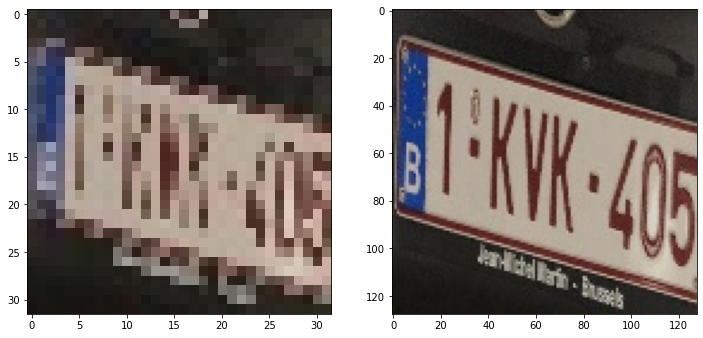

In [18]:
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [19]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.  #ranges b/w 0 to 255 if we r using tanh as activation fn for that it is different that values lies b/w -1 to 1 but wht we get here the values range b/w 0 to 1

### train_test split

In [20]:
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,test_size=0.20, random_state=42)

In [21]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3]) #basically we are getting the shape of low_res and high_res images

In [22]:
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [23]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])  #it uses binary cross entopy because it is binary class problem
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [24]:
vgg = build_vgg((128,128,3))  #here we are extracting the feture of hig_res image thats why we are using 128 and keeping that aside from generator we will getting images from there again we r xtracting the features and comparing the features
print(vgg.summary())
vgg.trainable = False

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [25]:
#now we r creating gan model
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)


In [26]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()
#why binary cross here in the sense check the gan model we have craeated there we use 'validity' as a loss fn-- that is basically output of the discriminator and mse for vgg... 

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

batch and epoches

In [27]:
batch_size = 1   #these gives the best result by read a couple of papers
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])  #or if we want we can create batches of images to train like 10 low_res images corresponding 10 high_res images 
#wht above code will do in the sense it will train 1 image at a time and send it to below i.e discriminator

In [28]:
epochs = 7

In [25]:
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []  #empty list to capture the looses as we mentione befor
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))): ##here we r going to each batch i.e each of 634 imgs
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images ##as w.k we r supplying low_res image to generator it will presict on it and then it will pass to discriminator
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label) #for comparing purposes we taken high_res img
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. ##if generator trained only discrimator will do his job na
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)  #discrimator loss and ...
        g_losses.append(g_loss)
    
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)  #at the end of each epoch we r avg. them
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 7 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")


  0%|                                                                                          | 0/507 [00:00<?, ?it/s]

1/1 [==============================] - 0s 94ms/step


  0%|▏                                                                               | 1/507 [00:07<1:01:28,  7.29s/it]

1/1 [==============================] - 0s 47ms/step


  0%|▎                                                                                 | 2/507 [00:09<36:02,  4.28s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▍                                                                                 | 3/507 [00:11<27:58,  3.33s/it]

1/1 [==============================] - 0s 31ms/step


  1%|▋                                                                                 | 4/507 [00:13<23:55,  2.85s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▊                                                                                 | 5/507 [00:16<22:05,  2.64s/it]

1/1 [==============================] - 0s 33ms/step


  1%|▉                                                                                 | 6/507 [00:18<20:38,  2.47s/it]

1/1 [==============================] - 0s 47ms/step


  1%|█▏                                                                                | 7/507 [00:20<19:58,  2.40s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▎                                                                                | 8/507 [00:22<19:09,  2.30s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▍                                                                                | 9/507 [00:24<18:30,  2.23s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▌                                                                               | 10/507 [00:26<18:05,  2.18s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▊                                                                               | 11/507 [00:28<17:51,  2.16s/it]

1/1 [==============================] - 0s 31ms/step


  2%|█▉                                                                               | 12/507 [00:30<17:36,  2.13s/it]

1/1 [==============================] - 0s 40ms/step


  3%|██                                                                               | 13/507 [00:32<17:25,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▏                                                                              | 14/507 [00:34<17:10,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▍                                                                              | 15/507 [00:37<17:03,  2.08s/it]

1/1 [==============================] - 0s 31ms/step


  3%|██▌                                                                              | 16/507 [00:39<16:54,  2.07s/it]

1/1 [==============================] - 0s 31ms/step


  3%|██▋                                                                              | 17/507 [00:41<16:52,  2.07s/it]

1/1 [==============================] - 0s 47ms/step


  4%|██▉                                                                              | 18/507 [00:43<16:53,  2.07s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███                                                                              | 19/507 [00:45<17:01,  2.09s/it]

1/1 [==============================] - 0s 34ms/step


  4%|███▏                                                                             | 20/507 [00:47<17:03,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▎                                                                             | 21/507 [00:49<17:14,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▌                                                                             | 22/507 [00:51<17:06,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


  5%|███▋                                                                             | 23/507 [00:53<16:56,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▊                                                                             | 24/507 [00:55<16:49,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▉                                                                             | 25/507 [00:57<16:40,  2.07s/it]

1/1 [==============================] - 0s 47ms/step


  5%|████▏                                                                            | 26/507 [01:00<17:10,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  5%|████▎                                                                            | 27/507 [01:02<17:06,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▍                                                                            | 28/507 [01:04<17:16,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▋                                                                            | 29/507 [01:07<18:32,  2.33s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▊                                                                            | 30/507 [01:09<18:56,  2.38s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▉                                                                            | 31/507 [01:11<18:16,  2.30s/it]

1/1 [==============================] - 0s 31ms/step


  6%|█████                                                                            | 32/507 [01:14<17:58,  2.27s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▎                                                                           | 33/507 [01:16<17:36,  2.23s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▍                                                                           | 34/507 [01:18<17:29,  2.22s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▌                                                                           | 35/507 [01:20<17:32,  2.23s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▊                                                                           | 36/507 [01:22<17:15,  2.20s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▉                                                                           | 37/507 [01:24<16:56,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


  7%|██████                                                                           | 38/507 [01:27<16:45,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▏                                                                          | 39/507 [01:29<16:36,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▍                                                                          | 40/507 [01:31<16:30,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▌                                                                          | 41/507 [01:33<16:22,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                          | 42/507 [01:35<16:18,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▊                                                                          | 43/507 [01:37<16:28,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████                                                                          | 44/507 [01:39<16:24,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████▏                                                                         | 45/507 [01:41<16:19,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████▎                                                                         | 46/507 [01:43<16:12,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


  9%|███████▌                                                                         | 47/507 [01:45<16:09,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████▋                                                                         | 48/507 [01:48<15:59,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


 10%|███████▊                                                                         | 49/507 [01:50<15:59,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


 10%|███████▉                                                                         | 50/507 [01:52<15:51,  2.08s/it]

1/1 [==============================] - 0s 35ms/step


 10%|████████▏                                                                        | 51/507 [01:54<15:50,  2.08s/it]

1/1 [==============================] - 0s 38ms/step


 10%|████████▎                                                                        | 52/507 [01:56<15:47,  2.08s/it]

1/1 [==============================] - 0s 31ms/step


 10%|████████▍                                                                        | 53/507 [01:58<15:46,  2.08s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▋                                                                        | 54/507 [02:00<15:46,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▊                                                                        | 55/507 [02:02<15:43,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▉                                                                        | 56/507 [02:04<15:43,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 11%|█████████                                                                        | 57/507 [02:07<16:13,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 11%|█████████▎                                                                       | 58/507 [02:09<17:08,  2.29s/it]

1/1 [==============================] - 0s 31ms/step


 12%|█████████▍                                                                       | 59/507 [02:11<17:06,  2.29s/it]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▌                                                                       | 60/507 [02:14<16:43,  2.25s/it]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▋                                                                       | 61/507 [02:16<16:31,  2.22s/it]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▉                                                                       | 62/507 [02:18<16:45,  2.26s/it]

1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                       | 63/507 [02:20<16:41,  2.26s/it]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▏                                                                      | 64/507 [02:23<16:52,  2.29s/it]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▍                                                                      | 65/507 [02:25<16:37,  2.26s/it]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▌                                                                      | 66/507 [02:27<16:30,  2.25s/it]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▋                                                                      | 67/507 [02:29<16:32,  2.26s/it]

1/1 [==============================] - 0s 58ms/step


 13%|██████████▊                                                                      | 68/507 [02:32<16:24,  2.24s/it]

1/1 [==============================] - 0s 47ms/step


 14%|███████████                                                                      | 69/507 [02:34<16:40,  2.28s/it]

1/1 [==============================] - 0s 47ms/step


 14%|███████████▏                                                                     | 70/507 [02:37<17:29,  2.40s/it]

1/1 [==============================] - 0s 50ms/step


 14%|███████████▎                                                                     | 71/507 [02:39<18:08,  2.50s/it]

1/1 [==============================] - 0s 32ms/step


 14%|███████████▌                                                                     | 72/507 [02:42<17:53,  2.47s/it]

1/1 [==============================] - 0s 49ms/step


 14%|███████████▋                                                                     | 73/507 [02:44<18:11,  2.51s/it]

1/1 [==============================] - 0s 48ms/step


 15%|███████████▊                                                                     | 74/507 [02:47<18:01,  2.50s/it]

1/1 [==============================] - 0s 55ms/step


 15%|███████████▉                                                                     | 75/507 [02:49<17:28,  2.43s/it]

1/1 [==============================] - 0s 31ms/step


 15%|████████████▏                                                                    | 76/507 [02:51<16:55,  2.36s/it]

1/1 [==============================] - 0s 47ms/step


 15%|████████████▎                                                                    | 77/507 [02:53<16:23,  2.29s/it]

1/1 [==============================] - 0s 47ms/step


 15%|████████████▍                                                                    | 78/507 [02:56<16:06,  2.25s/it]

1/1 [==============================] - 0s 47ms/step


 16%|████████████▌                                                                    | 79/507 [02:58<15:52,  2.23s/it]

1/1 [==============================] - 0s 47ms/step


 16%|████████████▊                                                                    | 80/507 [03:00<15:46,  2.22s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▉                                                                    | 81/507 [03:03<16:30,  2.33s/it]

1/1 [==============================] - 0s 47ms/step


 16%|█████████████                                                                    | 82/507 [03:05<17:08,  2.42s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 83/507 [03:08<17:08,  2.42s/it]

1/1 [==============================] - 0s 51ms/step


 17%|█████████████▍                                                                   | 84/507 [03:10<17:12,  2.44s/it]

1/1 [==============================] - 0s 47ms/step


 17%|█████████████▌                                                                   | 85/507 [03:12<17:00,  2.42s/it]

1/1 [==============================] - 0s 53ms/step


 17%|█████████████▋                                                                   | 86/507 [03:15<17:11,  2.45s/it]

1/1 [==============================] - 0s 45ms/step


 17%|█████████████▉                                                                   | 87/507 [03:17<16:38,  2.38s/it]

1/1 [==============================] - 0s 43ms/step


 17%|██████████████                                                                   | 88/507 [03:19<16:07,  2.31s/it]

1/1 [==============================] - 0s 44ms/step


 18%|██████████████▏                                                                  | 89/507 [03:21<15:42,  2.26s/it]

1/1 [==============================] - 0s 48ms/step


 18%|██████████████▍                                                                  | 90/507 [03:24<15:32,  2.24s/it]

1/1 [==============================] - 0s 43ms/step


 18%|██████████████▌                                                                  | 91/507 [03:26<15:27,  2.23s/it]

1/1 [==============================] - 0s 47ms/step


 18%|██████████████▋                                                                  | 92/507 [03:28<15:21,  2.22s/it]

1/1 [==============================] - 0s 47ms/step


 18%|██████████████▊                                                                  | 93/507 [03:30<15:06,  2.19s/it]

1/1 [==============================] - 0s 47ms/step


 19%|███████████████                                                                  | 94/507 [03:32<14:57,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 19%|███████████████▏                                                                 | 95/507 [03:34<14:48,  2.16s/it]

1/1 [==============================] - 0s 50ms/step


 19%|███████████████▎                                                                 | 96/507 [03:37<15:22,  2.25s/it]

1/1 [==============================] - 0s 43ms/step


 19%|███████████████▍                                                                 | 97/507 [03:39<15:23,  2.25s/it]

1/1 [==============================] - 0s 44ms/step


 19%|███████████████▋                                                                 | 98/507 [03:41<15:07,  2.22s/it]

1/1 [==============================] - 0s 43ms/step


 20%|███████████████▊                                                                 | 99/507 [03:43<14:53,  2.19s/it]

1/1 [==============================] - 0s 48ms/step


 20%|███████████████▊                                                                | 100/507 [03:46<14:55,  2.20s/it]

1/1 [==============================] - 0s 44ms/step


 20%|███████████████▉                                                                | 101/507 [03:48<14:45,  2.18s/it]

1/1 [==============================] - 0s 45ms/step


 20%|████████████████                                                                | 102/507 [03:50<14:38,  2.17s/it]

1/1 [==============================] - 0s 51ms/step


 20%|████████████████▎                                                               | 103/507 [03:52<14:38,  2.18s/it]

1/1 [==============================] - 0s 31ms/step


 21%|████████████████▍                                                               | 104/507 [03:54<14:30,  2.16s/it]

1/1 [==============================] - 0s 31ms/step


 21%|████████████████▌                                                               | 105/507 [03:56<14:21,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 21%|████████████████▋                                                               | 106/507 [03:58<14:15,  2.13s/it]

1/1 [==============================] - 0s 37ms/step


 21%|████████████████▉                                                               | 107/507 [04:01<14:09,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 21%|█████████████████                                                               | 108/507 [04:03<14:03,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 21%|█████████████████▏                                                              | 109/507 [04:05<13:58,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 22%|█████████████████▎                                                              | 110/507 [04:07<14:01,  2.12s/it]

1/1 [==============================] - 0s 44ms/step


 22%|█████████████████▌                                                              | 111/507 [04:09<14:01,  2.12s/it]

1/1 [==============================] - 0s 44ms/step


 22%|█████████████████▋                                                              | 112/507 [04:11<13:58,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


 22%|█████████████████▊                                                              | 113/507 [04:13<13:58,  2.13s/it]

1/1 [==============================] - 0s 44ms/step


 22%|█████████████████▉                                                              | 114/507 [04:15<13:55,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▏                                                             | 115/507 [04:17<13:48,  2.11s/it]

1/1 [==============================] - 0s 44ms/step


 23%|██████████████████▎                                                             | 116/507 [04:20<13:45,  2.11s/it]

1/1 [==============================] - 0s 44ms/step


 23%|██████████████████▍                                                             | 117/507 [04:22<13:42,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▌                                                             | 118/507 [04:24<13:35,  2.10s/it]

1/1 [==============================] - 0s 43ms/step


 23%|██████████████████▊                                                             | 119/507 [04:26<13:35,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 24%|██████████████████▉                                                             | 120/507 [04:28<13:34,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 24%|███████████████████                                                             | 121/507 [04:30<13:31,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▎                                                            | 122/507 [04:32<13:31,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▍                                                            | 123/507 [04:34<13:31,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 24%|███████████████████▌                                                            | 124/507 [04:36<13:28,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 25%|███████████████████▋                                                            | 125/507 [04:39<13:25,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 25%|███████████████████▉                                                            | 126/507 [04:41<13:22,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 25%|████████████████████                                                            | 127/507 [04:43<13:17,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 25%|████████████████████▏                                                           | 128/507 [04:45<13:28,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 25%|████████████████████▎                                                           | 129/507 [04:47<13:22,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 26%|████████████████████▌                                                           | 130/507 [04:49<13:23,  2.13s/it]

1/1 [==============================] - 0s 44ms/step


 26%|████████████████████▋                                                           | 131/507 [04:51<13:21,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 26%|████████████████████▊                                                           | 132/507 [04:53<13:18,  2.13s/it]

1/1 [==============================] - 0s 44ms/step


 26%|████████████████████▉                                                           | 133/507 [04:56<13:11,  2.12s/it]

1/1 [==============================] - 0s 44ms/step


 26%|█████████████████████▏                                                          | 134/507 [04:58<13:07,  2.11s/it]

1/1 [==============================] - 0s 44ms/step


 27%|█████████████████████▎                                                          | 135/507 [05:00<13:07,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 27%|█████████████████████▍                                                          | 136/507 [05:02<13:10,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 27%|█████████████████████▌                                                          | 137/507 [05:04<13:08,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 27%|█████████████████████▊                                                          | 138/507 [05:07<13:56,  2.27s/it]

1/1 [==============================] - 0s 47ms/step


 27%|█████████████████████▉                                                          | 139/507 [05:09<13:35,  2.22s/it]

1/1 [==============================] - 0s 31ms/step


 28%|██████████████████████                                                          | 140/507 [05:11<13:22,  2.19s/it]

1/1 [==============================] - 0s 47ms/step


 28%|██████████████████████▏                                                         | 141/507 [05:13<13:17,  2.18s/it]

1/1 [==============================] - 0s 47ms/step


 28%|██████████████████████▍                                                         | 142/507 [05:15<13:06,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 28%|██████████████████████▌                                                         | 143/507 [05:17<13:01,  2.15s/it]

1/1 [==============================] - 0s 45ms/step


 28%|██████████████████████▋                                                         | 144/507 [05:19<12:58,  2.15s/it]

1/1 [==============================] - 0s 44ms/step


 29%|██████████████████████▉                                                         | 145/507 [05:21<12:51,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 29%|███████████████████████                                                         | 146/507 [05:24<12:46,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 29%|███████████████████████▏                                                        | 147/507 [05:26<12:37,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 29%|███████████████████████▎                                                        | 148/507 [05:28<12:35,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 29%|███████████████████████▌                                                        | 149/507 [05:30<12:28,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 30%|███████████████████████▋                                                        | 150/507 [05:32<12:40,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 30%|███████████████████████▊                                                        | 151/507 [05:34<12:39,  2.13s/it]

1/1 [==============================] - 0s 31ms/step


 30%|███████████████████████▉                                                        | 152/507 [05:36<12:33,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▏                                                       | 153/507 [05:38<12:32,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▎                                                       | 154/507 [05:40<12:25,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▍                                                       | 155/507 [05:43<12:23,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▌                                                       | 156/507 [05:45<12:19,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▊                                                       | 157/507 [05:47<12:16,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▉                                                       | 158/507 [05:49<12:23,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 31%|█████████████████████████                                                       | 159/507 [05:51<12:19,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 32%|█████████████████████████▏                                                      | 160/507 [05:53<12:19,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 32%|█████████████████████████▍                                                      | 161/507 [05:55<12:18,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 32%|█████████████████████████▌                                                      | 162/507 [05:58<12:16,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 32%|█████████████████████████▋                                                      | 163/507 [06:00<12:13,  2.13s/it]

1/1 [==============================] - 0s 44ms/step


 32%|█████████████████████████▉                                                      | 164/507 [06:02<12:14,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 33%|██████████████████████████                                                      | 165/507 [06:04<12:09,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 33%|██████████████████████████▏                                                     | 166/507 [06:06<12:06,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 33%|██████████████████████████▎                                                     | 167/507 [06:08<12:03,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 33%|██████████████████████████▌                                                     | 168/507 [06:10<12:00,  2.13s/it]

1/1 [==============================] - 0s 44ms/step


 33%|██████████████████████████▋                                                     | 169/507 [06:12<11:59,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 34%|██████████████████████████▊                                                     | 170/507 [06:15<11:54,  2.12s/it]

1/1 [==============================] - 0s 44ms/step


 34%|██████████████████████████▉                                                     | 171/507 [06:17<11:49,  2.11s/it]

1/1 [==============================] - 0s 45ms/step


 34%|███████████████████████████▏                                                    | 172/507 [06:19<11:45,  2.11s/it]

1/1 [==============================] - 0s 55ms/step


 34%|███████████████████████████▎                                                    | 173/507 [06:21<11:42,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 34%|███████████████████████████▍                                                    | 174/507 [06:23<11:45,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 35%|███████████████████████████▌                                                    | 175/507 [06:25<11:43,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 35%|███████████████████████████▊                                                    | 176/507 [06:27<11:43,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 35%|███████████████████████████▉                                                    | 177/507 [06:29<11:41,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 35%|████████████████████████████                                                    | 178/507 [06:31<11:37,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▏                                                   | 179/507 [06:34<11:33,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 36%|████████████████████████████▍                                                   | 180/507 [06:36<11:29,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 36%|████████████████████████████▌                                                   | 181/507 [06:38<11:25,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 36%|████████████████████████████▋                                                   | 182/507 [06:40<11:18,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 36%|████████████████████████████▉                                                   | 183/507 [06:42<11:23,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 36%|█████████████████████████████                                                   | 184/507 [06:44<11:20,  2.11s/it]

1/1 [==============================] - 0s 39ms/step


 36%|█████████████████████████████▏                                                  | 185/507 [06:46<11:28,  2.14s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▎                                                  | 186/507 [06:49<11:42,  2.19s/it]

1/1 [==============================] - 0s 47ms/step


 37%|█████████████████████████████▌                                                  | 187/507 [06:51<11:35,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 37%|█████████████████████████████▋                                                  | 188/507 [06:53<11:23,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 37%|█████████████████████████████▊                                                  | 189/507 [06:55<11:22,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 37%|█████████████████████████████▉                                                  | 190/507 [06:57<11:15,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 38%|██████████████████████████████▏                                                 | 191/507 [06:59<11:13,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 38%|██████████████████████████████▎                                                 | 192/507 [07:01<11:08,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


 38%|██████████████████████████████▍                                                 | 193/507 [07:03<11:11,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 38%|██████████████████████████████▌                                                 | 194/507 [07:06<11:07,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 38%|██████████████████████████████▊                                                 | 195/507 [07:08<11:01,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 39%|██████████████████████████████▉                                                 | 196/507 [07:10<11:02,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 39%|███████████████████████████████                                                 | 197/507 [07:12<11:05,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 39%|███████████████████████████████▏                                                | 198/507 [07:14<11:00,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 39%|███████████████████████████████▍                                                | 199/507 [07:16<10:58,  2.14s/it]

1/1 [==============================] - 0s 44ms/step


 39%|███████████████████████████████▌                                                | 200/507 [07:18<10:55,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 40%|███████████████████████████████▋                                                | 201/507 [07:20<10:51,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 40%|███████████████████████████████▊                                                | 202/507 [07:23<10:45,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 40%|████████████████████████████████                                                | 203/507 [07:25<10:40,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 40%|████████████████████████████████▏                                               | 204/507 [07:27<10:37,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 40%|████████████████████████████████▎                                               | 205/507 [07:29<10:30,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 41%|████████████████████████████████▌                                               | 206/507 [07:31<10:33,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 41%|████████████████████████████████▋                                               | 207/507 [07:33<10:31,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 41%|████████████████████████████████▊                                               | 208/507 [07:35<10:30,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 41%|████████████████████████████████▉                                               | 209/507 [07:37<10:30,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 41%|█████████████████████████████████▏                                              | 210/507 [07:39<10:30,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 42%|█████████████████████████████████▎                                              | 211/507 [07:42<10:27,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 42%|█████████████████████████████████▍                                              | 212/507 [07:44<10:23,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 42%|█████████████████████████████████▌                                              | 213/507 [07:46<10:29,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 42%|█████████████████████████████████▊                                              | 214/507 [07:48<10:35,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 42%|█████████████████████████████████▉                                              | 215/507 [07:50<10:31,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████                                              | 216/507 [07:52<10:25,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████▏                                             | 217/507 [07:55<10:22,  2.15s/it]

1/1 [==============================] - 0s 31ms/step


 43%|██████████████████████████████████▍                                             | 218/507 [07:57<10:18,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████▌                                             | 219/507 [07:59<10:15,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████▋                                             | 220/507 [08:01<10:14,  2.14s/it]

1/1 [==============================] - 0s 31ms/step


 44%|██████████████████████████████████▊                                             | 221/507 [08:03<10:06,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 44%|███████████████████████████████████                                             | 222/507 [08:05<10:07,  2.13s/it]

1/1 [==============================] - 0s 38ms/step


 44%|███████████████████████████████████▏                                            | 223/507 [08:07<10:04,  2.13s/it]

1/1 [==============================] - 0s 31ms/step


 44%|███████████████████████████████████▎                                            | 224/507 [08:09<10:00,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 44%|███████████████████████████████████▌                                            | 225/507 [08:12<09:59,  2.13s/it]

1/1 [==============================] - 0s 51ms/step


 45%|███████████████████████████████████▋                                            | 226/507 [08:14<10:00,  2.14s/it]

1/1 [==============================] - 0s 62ms/step


 45%|███████████████████████████████████▊                                            | 227/507 [08:16<10:16,  2.20s/it]

1/1 [==============================] - 0s 47ms/step


 45%|███████████████████████████████████▉                                            | 228/507 [08:18<10:10,  2.19s/it]

1/1 [==============================] - 0s 47ms/step


 45%|████████████████████████████████████▏                                           | 229/507 [08:20<10:07,  2.19s/it]

1/1 [==============================] - 0s 47ms/step


 45%|████████████████████████████████████▎                                           | 230/507 [08:23<10:02,  2.18s/it]

1/1 [==============================] - 0s 47ms/step


 46%|████████████████████████████████████▍                                           | 231/507 [08:25<09:55,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 46%|████████████████████████████████████▌                                           | 232/507 [08:27<09:46,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 46%|████████████████████████████████████▊                                           | 233/507 [08:29<09:42,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 46%|████████████████████████████████████▉                                           | 234/507 [08:31<09:38,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


 46%|█████████████████████████████████████                                           | 235/507 [08:33<09:37,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 47%|█████████████████████████████████████▏                                          | 236/507 [08:35<09:43,  2.15s/it]

1/1 [==============================] - 0s 45ms/step


 47%|█████████████████████████████████████▍                                          | 237/507 [08:37<09:40,  2.15s/it]

1/1 [==============================] - 0s 44ms/step


 47%|█████████████████████████████████████▌                                          | 238/507 [08:40<09:35,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 47%|█████████████████████████████████████▋                                          | 239/507 [08:42<09:29,  2.12s/it]

1/1 [==============================] - 0s 44ms/step


 47%|█████████████████████████████████████▊                                          | 240/507 [08:44<09:27,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 48%|██████████████████████████████████████                                          | 241/507 [08:46<09:22,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 48%|██████████████████████████████████████▏                                         | 242/507 [08:48<09:17,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 48%|██████████████████████████████████████▎                                         | 243/507 [08:50<09:16,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 48%|██████████████████████████████████████▌                                         | 244/507 [08:52<09:15,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 48%|██████████████████████████████████████▋                                         | 245/507 [08:54<09:13,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 49%|██████████████████████████████████████▊                                         | 246/507 [08:56<09:13,  2.12s/it]

1/1 [==============================] - 0s 35ms/step


 49%|██████████████████████████████████████▉                                         | 247/507 [08:59<09:09,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 49%|███████████████████████████████████████▏                                        | 248/507 [09:01<09:06,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 49%|███████████████████████████████████████▎                                        | 249/507 [09:03<09:03,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 49%|███████████████████████████████████████▍                                        | 250/507 [09:05<09:02,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 50%|███████████████████████████████████████▌                                        | 251/507 [09:07<08:57,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 50%|███████████████████████████████████████▊                                        | 252/507 [09:09<09:05,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 50%|███████████████████████████████████████▉                                        | 253/507 [09:11<09:05,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 50%|████████████████████████████████████████                                        | 254/507 [09:13<09:00,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 50%|████████████████████████████████████████▏                                       | 255/507 [09:16<09:00,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 50%|████████████████████████████████████████▍                                       | 256/507 [09:18<08:53,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 51%|████████████████████████████████████████▌                                       | 257/507 [09:20<08:47,  2.11s/it]

1/1 [==============================] - 0s 46ms/step


 51%|████████████████████████████████████████▋                                       | 258/507 [09:22<08:46,  2.12s/it]

1/1 [==============================] - 0s 44ms/step


 51%|████████████████████████████████████████▊                                       | 259/507 [09:24<08:41,  2.10s/it]

1/1 [==============================] - 0s 46ms/step


 51%|█████████████████████████████████████████                                       | 260/507 [09:26<08:43,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


 51%|█████████████████████████████████████████▏                                      | 261/507 [09:28<08:41,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 52%|█████████████████████████████████████████▎                                      | 262/507 [09:30<08:40,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 52%|█████████████████████████████████████████▍                                      | 263/507 [09:32<08:38,  2.13s/it]

1/1 [==============================] - 0s 44ms/step


 52%|█████████████████████████████████████████▋                                      | 264/507 [09:35<08:35,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


 52%|█████████████████████████████████████████▊                                      | 265/507 [09:37<08:31,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


 52%|█████████████████████████████████████████▉                                      | 266/507 [09:39<08:30,  2.12s/it]

1/1 [==============================] - 0s 44ms/step


 53%|██████████████████████████████████████████▏                                     | 267/507 [09:41<08:26,  2.11s/it]

1/1 [==============================] - 0s 58ms/step


 53%|██████████████████████████████████████████▎                                     | 268/507 [09:43<08:29,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 53%|██████████████████████████████████████████▍                                     | 269/507 [09:45<08:28,  2.14s/it]

1/1 [==============================] - 0s 56ms/step


 53%|██████████████████████████████████████████▌                                     | 270/507 [09:47<08:26,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 53%|██████████████████████████████████████████▊                                     | 271/507 [09:49<08:23,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 54%|██████████████████████████████████████████▉                                     | 272/507 [09:52<08:18,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 54%|███████████████████████████████████████████                                     | 273/507 [09:54<08:16,  2.12s/it]

1/1 [==============================] - 0s 56ms/step


 54%|███████████████████████████████████████████▏                                    | 274/507 [09:56<08:14,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 54%|███████████████████████████████████████████▍                                    | 275/507 [09:58<08:10,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 54%|███████████████████████████████████████████▌                                    | 276/507 [10:00<08:12,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 55%|███████████████████████████████████████████▋                                    | 277/507 [10:02<08:09,  2.13s/it]

1/1 [==============================] - 0s 31ms/step


 55%|███████████████████████████████████████████▊                                    | 278/507 [10:04<08:08,  2.13s/it]

1/1 [==============================] - 0s 53ms/step


 55%|████████████████████████████████████████████                                    | 279/507 [10:07<08:09,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 55%|████████████████████████████████████████████▏                                   | 280/507 [10:09<08:04,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 55%|████████████████████████████████████████████▎                                   | 281/507 [10:11<07:59,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


 56%|████████████████████████████████████████████▍                                   | 282/507 [10:13<07:57,  2.12s/it]

1/1 [==============================] - 0s 44ms/step


 56%|████████████████████████████████████████████▋                                   | 283/507 [10:15<07:58,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 56%|████████████████████████████████████████████▊                                   | 284/507 [10:17<07:56,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 56%|████████████████████████████████████████████▉                                   | 285/507 [10:19<07:54,  2.14s/it]

1/1 [==============================] - 0s 59ms/step


 56%|█████████████████████████████████████████████▏                                  | 286/507 [10:21<07:53,  2.14s/it]

1/1 [==============================] - 0s 44ms/step


 57%|█████████████████████████████████████████████▎                                  | 287/507 [10:24<07:50,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 57%|█████████████████████████████████████████████▍                                  | 288/507 [10:26<07:46,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 57%|█████████████████████████████████████████████▌                                  | 289/507 [10:28<07:43,  2.12s/it]

1/1 [==============================] - 0s 49ms/step


 57%|█████████████████████████████████████████████▊                                  | 290/507 [10:30<07:38,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 57%|█████████████████████████████████████████████▉                                  | 291/507 [10:32<07:39,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 58%|██████████████████████████████████████████████                                  | 292/507 [10:34<07:38,  2.13s/it]

1/1 [==============================] - 0s 48ms/step


 58%|██████████████████████████████████████████████▏                                 | 293/507 [10:36<07:37,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 58%|██████████████████████████████████████████████▍                                 | 294/507 [10:39<07:36,  2.15s/it]

1/1 [==============================] - 0s 44ms/step


 58%|██████████████████████████████████████████████▌                                 | 295/507 [10:41<07:32,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 58%|██████████████████████████████████████████████▋                                 | 296/507 [10:43<07:30,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 59%|██████████████████████████████████████████████▊                                 | 297/507 [10:45<07:29,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 59%|███████████████████████████████████████████████                                 | 298/507 [10:47<07:25,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 59%|███████████████████████████████████████████████▏                                | 299/507 [10:49<07:25,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 59%|███████████████████████████████████████████████▎                                | 300/507 [10:51<07:21,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 59%|███████████████████████████████████████████████▍                                | 301/507 [10:54<07:22,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 60%|███████████████████████████████████████████████▋                                | 302/507 [10:56<07:18,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 60%|███████████████████████████████████████████████▊                                | 303/507 [10:58<07:13,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 60%|███████████████████████████████████████████████▉                                | 304/507 [11:00<07:10,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


 60%|████████████████████████████████████████████████▏                               | 305/507 [11:02<07:05,  2.11s/it]

1/1 [==============================] - 0s 46ms/step


 60%|████████████████████████████████████████████████▎                               | 306/507 [11:04<07:06,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 61%|████████████████████████████████████████████████▍                               | 307/507 [11:06<07:05,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 61%|████████████████████████████████████████████████▌                               | 308/507 [11:08<07:03,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 61%|████████████████████████████████████████████████▊                               | 309/507 [11:11<07:05,  2.15s/it]

1/1 [==============================] - 0s 51ms/step


 61%|████████████████████████████████████████████████▉                               | 310/507 [11:13<07:02,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 61%|█████████████████████████████████████████████████                               | 311/507 [11:15<06:58,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 62%|█████████████████████████████████████████████████▏                              | 312/507 [11:17<06:55,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 62%|█████████████████████████████████████████████████▍                              | 313/507 [11:19<06:49,  2.11s/it]

1/1 [==============================] - 0s 45ms/step


 62%|█████████████████████████████████████████████████▌                              | 314/507 [11:21<06:50,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 62%|█████████████████████████████████████████████████▋                              | 315/507 [11:23<06:48,  2.13s/it]

1/1 [==============================] - 0s 44ms/step


 62%|█████████████████████████████████████████████████▊                              | 316/507 [11:25<06:47,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 63%|██████████████████████████████████████████████████                              | 317/507 [11:28<06:46,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 63%|██████████████████████████████████████████████████▏                             | 318/507 [11:30<06:43,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 63%|██████████████████████████████████████████████████▎                             | 319/507 [11:32<06:40,  2.13s/it]

1/1 [==============================] - 0s 44ms/step


 63%|██████████████████████████████████████████████████▍                             | 320/507 [11:34<06:39,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 63%|██████████████████████████████████████████████████▋                             | 321/507 [11:36<06:34,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


 64%|██████████████████████████████████████████████████▊                             | 322/507 [11:38<06:35,  2.14s/it]

1/1 [==============================] - 0s 44ms/step


 64%|██████████████████████████████████████████████████▉                             | 323/507 [11:40<06:33,  2.14s/it]

1/1 [==============================] - 0s 44ms/step


 64%|███████████████████████████████████████████████████                             | 324/507 [11:42<06:31,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 64%|███████████████████████████████████████████████████▎                            | 325/507 [11:45<06:30,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 64%|███████████████████████████████████████████████████▍                            | 326/507 [11:47<06:26,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 64%|███████████████████████████████████████████████████▌                            | 327/507 [11:49<06:23,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 65%|███████████████████████████████████████████████████▊                            | 328/507 [11:51<06:20,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 65%|███████████████████████████████████████████████████▉                            | 329/507 [11:53<06:16,  2.11s/it]

1/1 [==============================] - 0s 45ms/step


 65%|████████████████████████████████████████████████████                            | 330/507 [11:55<06:15,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


 65%|████████████████████████████████████████████████████▏                           | 331/507 [11:57<06:13,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 65%|████████████████████████████████████████████████████▍                           | 332/507 [11:59<06:12,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 66%|████████████████████████████████████████████████████▌                           | 333/507 [12:02<06:11,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 66%|████████████████████████████████████████████████████▋                           | 334/507 [12:04<06:07,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 66%|████████████████████████████████████████████████████▊                           | 335/507 [12:06<06:04,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


 66%|█████████████████████████████████████████████████████                           | 336/507 [12:08<06:03,  2.13s/it]

1/1 [==============================] - 0s 48ms/step


 66%|█████████████████████████████████████████████████████▏                          | 337/507 [12:10<05:59,  2.12s/it]

1/1 [==============================] - 0s 59ms/step


 67%|█████████████████████████████████████████████████████▎                          | 338/507 [12:12<06:00,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 67%|█████████████████████████████████████████████████████▍                          | 339/507 [12:15<06:04,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 67%|█████████████████████████████████████████████████████▋                          | 340/507 [12:17<06:03,  2.18s/it]

1/1 [==============================] - 0s 47ms/step


 67%|█████████████████████████████████████████████████████▊                          | 341/507 [12:19<05:59,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 67%|█████████████████████████████████████████████████████▉                          | 342/507 [12:21<05:58,  2.17s/it]

1/1 [==============================] - 0s 44ms/step


 68%|██████████████████████████████████████████████████████                          | 343/507 [12:23<06:00,  2.20s/it]

1/1 [==============================] - 0s 44ms/step


 68%|██████████████████████████████████████████████████████▎                         | 344/507 [12:26<05:59,  2.21s/it]

1/1 [==============================] - 0s 51ms/step


 68%|██████████████████████████████████████████████████████▍                         | 345/507 [12:28<05:57,  2.20s/it]

1/1 [==============================] - 0s 45ms/step


 68%|██████████████████████████████████████████████████████▌                         | 346/507 [12:30<05:54,  2.20s/it]

1/1 [==============================] - 0s 50ms/step


 68%|██████████████████████████████████████████████████████▊                         | 347/507 [12:32<05:54,  2.22s/it]

1/1 [==============================] - 0s 49ms/step


 69%|██████████████████████████████████████████████████████▉                         | 348/507 [12:34<05:57,  2.25s/it]

1/1 [==============================] - 0s 50ms/step


 69%|███████████████████████████████████████████████████████                         | 349/507 [12:37<05:58,  2.27s/it]

1/1 [==============================] - 0s 50ms/step


 69%|███████████████████████████████████████████████████████▏                        | 350/507 [12:39<05:56,  2.27s/it]

1/1 [==============================] - 0s 49ms/step


 69%|███████████████████████████████████████████████████████▍                        | 351/507 [12:41<05:58,  2.29s/it]

1/1 [==============================] - 0s 49ms/step


 69%|███████████████████████████████████████████████████████▌                        | 352/507 [12:44<05:54,  2.29s/it]

1/1 [==============================] - 0s 48ms/step


 70%|███████████████████████████████████████████████████████▋                        | 353/507 [12:46<05:53,  2.29s/it]

1/1 [==============================] - 0s 47ms/step


 70%|███████████████████████████████████████████████████████▊                        | 354/507 [12:48<05:49,  2.28s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████                        | 355/507 [12:51<05:47,  2.28s/it]

1/1 [==============================] - 0s 47ms/step


 70%|████████████████████████████████████████████████████████▏                       | 356/507 [12:53<05:43,  2.28s/it]

1/1 [==============================] - 0s 47ms/step


 70%|████████████████████████████████████████████████████████▎                       | 357/507 [12:55<05:44,  2.29s/it]

1/1 [==============================] - 0s 47ms/step


 71%|████████████████████████████████████████████████████████▍                       | 358/507 [12:57<05:44,  2.31s/it]

1/1 [==============================] - 0s 47ms/step


 71%|████████████████████████████████████████████████████████▋                       | 359/507 [13:00<05:45,  2.33s/it]

1/1 [==============================] - 0s 47ms/step


 71%|████████████████████████████████████████████████████████▊                       | 360/507 [13:02<05:36,  2.29s/it]

1/1 [==============================] - 0s 47ms/step


 71%|████████████████████████████████████████████████████████▉                       | 361/507 [13:04<05:32,  2.28s/it]

1/1 [==============================] - 0s 47ms/step


 71%|█████████████████████████████████████████████████████████                       | 362/507 [13:07<05:28,  2.26s/it]

1/1 [==============================] - 0s 47ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 363/507 [13:09<05:27,  2.28s/it]

1/1 [==============================] - 0s 47ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 364/507 [13:11<05:20,  2.24s/it]

1/1 [==============================] - 0s 47ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 365/507 [13:13<05:13,  2.21s/it]

1/1 [==============================] - 0s 58ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 366/507 [13:15<05:07,  2.18s/it]

1/1 [==============================] - 0s 47ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 367/507 [13:17<05:03,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 73%|██████████████████████████████████████████████████████████                      | 368/507 [13:20<05:02,  2.17s/it]

1/1 [==============================] - 0s 46ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 369/507 [13:22<04:58,  2.16s/it]

1/1 [==============================] - 0s 46ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 370/507 [13:24<04:52,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 371/507 [13:26<04:52,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 372/507 [13:28<04:50,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 373/507 [13:30<04:48,  2.15s/it]

1/1 [==============================] - 0s 45ms/step


 74%|███████████████████████████████████████████████████████████                     | 374/507 [13:33<04:50,  2.19s/it]

1/1 [==============================] - 0s 51ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 375/507 [13:35<04:56,  2.24s/it]

1/1 [==============================] - 0s 47ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 376/507 [13:37<04:56,  2.26s/it]

1/1 [==============================] - 0s 47ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 377/507 [13:39<04:49,  2.23s/it]

1/1 [==============================] - 0s 47ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 378/507 [13:42<04:45,  2.22s/it]

1/1 [==============================] - 0s 47ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 379/507 [13:44<04:41,  2.20s/it]

1/1 [==============================] - 0s 61ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 380/507 [13:46<04:38,  2.19s/it]

1/1 [==============================] - 0s 47ms/step


 75%|████████████████████████████████████████████████████████████                    | 381/507 [13:48<04:38,  2.21s/it]

1/1 [==============================] - 0s 47ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 382/507 [13:50<04:30,  2.16s/it]

1/1 [==============================] - 0s 31ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 383/507 [13:52<04:25,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 384/507 [13:54<04:23,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 385/507 [13:57<04:20,  2.13s/it]

1/1 [==============================] - 0s 53ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 386/507 [13:59<04:17,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 76%|█████████████████████████████████████████████████████████████                   | 387/507 [14:01<04:15,  2.13s/it]

1/1 [==============================] - 0s 31ms/step


 77%|█████████████████████████████████████████████████████████████▏                  | 388/507 [14:03<04:11,  2.12s/it]

1/1 [==============================] - 0s 58ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 389/507 [14:05<04:09,  2.11s/it]

1/1 [==============================] - 0s 46ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 390/507 [14:07<04:06,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 391/507 [14:09<04:07,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 392/507 [14:11<04:05,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 78%|██████████████████████████████████████████████████████████████                  | 393/507 [14:14<04:03,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 394/507 [14:16<04:01,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 395/507 [14:18<03:59,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 396/507 [14:20<03:56,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 397/507 [14:22<03:54,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 398/507 [14:24<03:53,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 399/507 [14:26<03:50,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 79%|███████████████████████████████████████████████████████████████                 | 400/507 [14:28<03:48,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 401/507 [14:31<03:44,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 402/507 [14:33<03:43,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 403/507 [14:35<03:39,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 404/507 [14:37<03:37,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 405/507 [14:39<03:37,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 80%|████████████████████████████████████████████████████████████████                | 406/507 [14:41<03:35,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 407/507 [14:43<03:33,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 80%|████████████████████████████████████████████████████████████████▍               | 408/507 [14:45<03:30,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 409/507 [14:48<03:28,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 410/507 [14:50<03:26,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 411/507 [14:52<03:24,  2.13s/it]

1/1 [==============================] - 0s 54ms/step


 81%|█████████████████████████████████████████████████████████████████               | 412/507 [14:54<03:20,  2.11s/it]

1/1 [==============================] - 0s 49ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 413/507 [14:56<03:17,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 414/507 [14:58<03:15,  2.10s/it]

1/1 [==============================] - 0s 46ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 415/507 [15:00<03:12,  2.09s/it]

1/1 [==============================] - 0s 45ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 416/507 [15:02<03:11,  2.10s/it]

1/1 [==============================] - 0s 46ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 417/507 [15:04<03:09,  2.11s/it]

1/1 [==============================] - 0s 46ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 418/507 [15:07<03:07,  2.11s/it]

1/1 [==============================] - 0s 46ms/step


 83%|██████████████████████████████████████████████████████████████████              | 419/507 [15:09<03:06,  2.12s/it]

1/1 [==============================] - 0s 53ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 420/507 [15:11<03:05,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 421/507 [15:13<03:03,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 422/507 [15:15<03:00,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 423/507 [15:17<02:56,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 424/507 [15:19<02:55,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


 84%|███████████████████████████████████████████████████████████████████             | 425/507 [15:21<02:55,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 426/507 [15:24<02:52,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 427/507 [15:26<02:50,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 428/507 [15:28<02:48,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 429/507 [15:30<02:45,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 430/507 [15:32<02:43,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 85%|████████████████████████████████████████████████████████████████████            | 431/507 [15:34<02:40,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 432/507 [15:36<02:39,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 433/507 [15:38<02:37,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 434/507 [15:41<02:35,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 435/507 [15:43<02:33,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 436/507 [15:45<02:31,  2.13s/it]

1/1 [==============================] - 0s 49ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 437/507 [15:47<02:31,  2.16s/it]

1/1 [==============================] - 0s 43ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 438/507 [15:49<02:29,  2.17s/it]

1/1 [==============================] - 0s 46ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 439/507 [15:51<02:27,  2.16s/it]

1/1 [==============================] - 0s 58ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 440/507 [15:54<02:24,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 441/507 [15:56<02:22,  2.16s/it]

1/1 [==============================] - 0s 46ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 442/507 [15:58<02:19,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 443/507 [16:00<02:16,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 444/507 [16:02<02:14,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 445/507 [16:04<02:11,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 446/507 [16:06<02:10,  2.14s/it]

1/1 [==============================] - 0s 57ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 447/507 [16:08<02:08,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 448/507 [16:11<02:06,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 89%|██████████████████████████████████████████████████████████████████████▊         | 449/507 [16:13<02:04,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 450/507 [16:15<02:01,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 451/507 [16:17<01:58,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 452/507 [16:19<01:56,  2.12s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 453/507 [16:21<01:53,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 454/507 [16:23<01:53,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 455/507 [16:26<01:51,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 456/507 [16:28<01:48,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 457/507 [16:30<01:46,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 458/507 [16:32<01:43,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 459/507 [16:34<01:41,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 460/507 [16:36<01:39,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 461/507 [16:38<01:37,  2.11s/it]

1/1 [==============================] - 0s 46ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 462/507 [16:40<01:35,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 463/507 [16:42<01:33,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 92%|█████████████████████████████████████████████████████████████████████████▏      | 464/507 [16:45<01:31,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 465/507 [16:47<01:29,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 466/507 [16:49<01:27,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 467/507 [16:51<01:24,  2.12s/it]

1/1 [==============================] - 0s 44ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 468/507 [16:53<01:22,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 469/507 [16:55<01:20,  2.11s/it]

1/1 [==============================] - 0s 46ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 470/507 [16:57<01:18,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 471/507 [17:00<01:17,  2.14s/it]

1/1 [==============================] - 0s 31ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 472/507 [17:02<01:14,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 473/507 [17:04<01:12,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 93%|██████████████████████████████████████████████████████████████████████████▊     | 474/507 [17:06<01:10,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 475/507 [17:08<01:08,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 476/507 [17:10<01:06,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 477/507 [17:12<01:04,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 478/507 [17:15<01:02,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 479/507 [17:17<01:00,  2.14s/it]

1/1 [==============================] - 0s 31ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 480/507 [17:19<00:57,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 481/507 [17:21<00:55,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 482/507 [17:23<00:53,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 483/507 [17:25<00:51,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 484/507 [17:27<00:48,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 485/507 [17:29<00:46,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 486/507 [17:31<00:44,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 487/507 [17:34<00:42,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 488/507 [17:36<00:40,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 489/507 [17:38<00:38,  2.14s/it]

1/1 [==============================] - 0s 50ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 490/507 [17:40<00:36,  2.17s/it]

1/1 [==============================] - 0s 46ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 491/507 [17:42<00:34,  2.18s/it]

1/1 [==============================] - 0s 48ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 492/507 [17:45<00:32,  2.17s/it]

1/1 [==============================] - 0s 46ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 493/507 [17:47<00:30,  2.19s/it]

1/1 [==============================] - 0s 46ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 494/507 [17:49<00:28,  2.16s/it]

1/1 [==============================] - 0s 44ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 495/507 [17:51<00:25,  2.15s/it]

1/1 [==============================] - 0s 45ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 496/507 [17:53<00:23,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 497/507 [17:55<00:21,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 498/507 [17:57<00:19,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 499/507 [18:00<00:17,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 500/507 [18:02<00:14,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 501/507 [18:04<00:12,  2.16s/it]

1/1 [==============================] - 0s 46ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 502/507 [18:06<00:10,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 503/507 [18:08<00:08,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 504/507 [18:10<00:06,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 505/507 [18:12<00:04,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 506/507 [18:14<00:02,  2.14s/it]

1/1 [==============================] - 0s 44ms/step


  0%|                                                                                          | 0/507 [00:00<?, ?it/s]

epoch: 1 g_loss: 82.07611383818075 d_loss: [2.72057891 0.82642998]
1/1 [==============================] - 0s 47ms/step


  0%|▏                                                                                 | 1/507 [00:02<17:58,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


  0%|▎                                                                                 | 2/507 [00:04<18:03,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▍                                                                                 | 3/507 [00:06<17:54,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▋                                                                                 | 4/507 [00:08<17:46,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▊                                                                                 | 5/507 [00:10<17:45,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                                 | 6/507 [00:12<17:37,  2.11s/it]

1/1 [==============================] - 0s 45ms/step


  1%|█▏                                                                                | 7/507 [00:14<17:40,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▎                                                                                | 8/507 [00:17<17:41,  2.13s/it]

1/1 [==============================] - 0s 55ms/step


  2%|█▍                                                                                | 9/507 [00:19<17:58,  2.17s/it]

1/1 [==============================] - 0s 50ms/step


  2%|█▌                                                                               | 10/507 [00:21<18:03,  2.18s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▊                                                                               | 11/507 [00:23<17:50,  2.16s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▉                                                                               | 12/507 [00:25<17:37,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


  3%|██                                                                               | 13/507 [00:27<17:36,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


  3%|██▏                                                                              | 14/507 [00:29<17:32,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


  3%|██▍                                                                              | 15/507 [00:32<17:32,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▌                                                                              | 16/507 [00:34<17:29,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▋                                                                              | 17/507 [00:36<17:25,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▉                                                                              | 18/507 [00:38<17:18,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                              | 19/507 [00:40<17:15,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▏                                                                             | 20/507 [00:42<17:08,  2.11s/it]

1/1 [==============================] - 0s 44ms/step


  4%|███▎                                                                             | 21/507 [00:44<17:08,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▌                                                                             | 22/507 [00:46<17:09,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▋                                                                             | 23/507 [00:49<17:07,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▊                                                                             | 24/507 [00:51<17:05,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▉                                                                             | 25/507 [00:53<17:13,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  5%|████▏                                                                            | 26/507 [00:55<17:11,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


  5%|████▎                                                                            | 27/507 [00:57<17:02,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▍                                                                            | 28/507 [00:59<16:52,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▋                                                                            | 29/507 [01:01<16:50,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▊                                                                            | 30/507 [01:03<16:48,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▉                                                                            | 31/507 [01:06<16:47,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  6%|█████                                                                            | 32/507 [01:08<16:45,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▎                                                                           | 33/507 [01:10<16:45,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▍                                                                           | 34/507 [01:12<16:46,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▌                                                                           | 35/507 [01:14<16:40,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▊                                                                           | 36/507 [01:16<16:36,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


  7%|█████▉                                                                           | 37/507 [01:18<16:29,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


  7%|██████                                                                           | 38/507 [01:20<16:31,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▏                                                                          | 39/507 [01:22<16:31,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▍                                                                          | 40/507 [01:25<16:30,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▌                                                                          | 41/507 [01:27<16:30,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▋                                                                          | 42/507 [01:29<16:27,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▊                                                                          | 43/507 [01:31<16:22,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████                                                                          | 44/507 [01:33<16:18,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


  9%|███████▏                                                                         | 45/507 [01:35<16:13,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████▎                                                                         | 46/507 [01:37<16:06,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████▌                                                                         | 47/507 [01:39<16:10,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████▋                                                                         | 48/507 [01:41<16:10,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▊                                                                         | 49/507 [01:44<16:09,  2.12s/it]

1/1 [==============================] - 0s 52ms/step


 10%|███████▉                                                                         | 50/507 [01:46<16:11,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 10%|████████▏                                                                        | 51/507 [01:48<16:06,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 10%|████████▎                                                                        | 52/507 [01:50<16:00,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 10%|████████▍                                                                        | 53/507 [01:52<15:56,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▋                                                                        | 54/507 [01:54<15:53,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▊                                                                        | 55/507 [01:56<15:52,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▉                                                                        | 56/507 [01:58<15:53,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 11%|█████████                                                                        | 57/507 [02:01<15:53,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


 11%|█████████▎                                                                       | 58/507 [02:03<15:55,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 12%|█████████▍                                                                       | 59/507 [02:05<15:57,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 12%|█████████▌                                                                       | 60/507 [02:07<15:51,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 12%|█████████▋                                                                       | 61/507 [02:09<15:45,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


 12%|█████████▉                                                                       | 62/507 [02:11<15:41,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


 12%|██████████                                                                       | 63/507 [02:13<15:29,  2.09s/it]

1/1 [==============================] - 0s 59ms/step


 13%|██████████▏                                                                      | 64/507 [02:15<15:33,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▍                                                                      | 65/507 [02:17<15:32,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▌                                                                      | 66/507 [02:20<15:32,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▋                                                                      | 67/507 [02:22<15:32,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▊                                                                      | 68/507 [02:24<15:30,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 14%|███████████                                                                      | 69/507 [02:26<15:27,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 14%|███████████▏                                                                     | 70/507 [02:28<15:22,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 14%|███████████▎                                                                     | 71/507 [02:30<15:22,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 14%|███████████▌                                                                     | 72/507 [02:32<15:19,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 14%|███████████▋                                                                     | 73/507 [02:34<15:19,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 15%|███████████▊                                                                     | 74/507 [02:37<15:17,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 15%|███████████▉                                                                     | 75/507 [02:39<15:17,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 15%|████████████▏                                                                    | 76/507 [02:41<15:19,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 15%|████████████▎                                                                    | 77/507 [02:43<15:12,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 15%|████████████▍                                                                    | 78/507 [02:45<15:05,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 16%|████████████▌                                                                    | 79/507 [02:47<15:01,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 16%|████████████▊                                                                    | 80/507 [02:49<14:59,  2.11s/it]

1/1 [==============================] - 0s 45ms/step


 16%|████████████▉                                                                    | 81/507 [02:51<14:56,  2.10s/it]

1/1 [==============================] - 0s 49ms/step


 16%|█████████████                                                                    | 82/507 [02:54<15:11,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 16%|█████████████▎                                                                   | 83/507 [02:56<15:11,  2.15s/it]

1/1 [==============================] - 0s 43ms/step


 17%|█████████████▍                                                                   | 84/507 [02:58<15:08,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 17%|█████████████▌                                                                   | 85/507 [03:00<15:01,  2.14s/it]

1/1 [==============================] - 0s 52ms/step


 17%|█████████████▋                                                                   | 86/507 [03:02<14:55,  2.13s/it]

1/1 [==============================] - 0s 48ms/step


 17%|█████████████▉                                                                   | 87/507 [03:04<14:52,  2.12s/it]

1/1 [==============================] - 0s 48ms/step


 17%|██████████████                                                                   | 88/507 [03:06<14:50,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 18%|██████████████▏                                                                  | 89/507 [03:08<14:53,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 18%|██████████████▍                                                                  | 90/507 [03:11<14:50,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 18%|██████████████▌                                                                  | 91/507 [03:13<14:46,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 18%|██████████████▋                                                                  | 92/507 [03:15<14:46,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 18%|██████████████▊                                                                  | 93/507 [03:17<14:43,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 19%|███████████████                                                                  | 94/507 [03:19<14:40,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 19%|███████████████▏                                                                 | 95/507 [03:21<14:34,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 19%|███████████████▎                                                                 | 96/507 [03:23<14:35,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 19%|███████████████▍                                                                 | 97/507 [03:25<14:32,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 19%|███████████████▋                                                                 | 98/507 [03:28<14:30,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 20%|███████████████▊                                                                 | 99/507 [03:30<14:28,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 20%|███████████████▊                                                                | 100/507 [03:32<14:25,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 20%|███████████████▉                                                                | 101/507 [03:34<14:24,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 20%|████████████████                                                                | 102/507 [03:36<14:20,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 20%|████████████████▎                                                               | 103/507 [03:38<14:16,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 21%|████████████████▍                                                               | 104/507 [03:40<14:08,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 21%|████████████████▌                                                               | 105/507 [03:42<14:14,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 21%|████████████████▋                                                               | 106/507 [03:45<14:13,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 21%|████████████████▉                                                               | 107/507 [03:47<14:12,  2.13s/it]

1/1 [==============================] - 0s 49ms/step


 21%|█████████████████                                                               | 108/507 [03:49<14:13,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 21%|█████████████████▏                                                              | 109/507 [03:51<14:06,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 22%|█████████████████▎                                                              | 110/507 [03:53<14:07,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 22%|█████████████████▌                                                              | 111/507 [03:55<13:59,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 22%|█████████████████▋                                                              | 112/507 [03:57<14:00,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 22%|█████████████████▊                                                              | 113/507 [04:00<13:58,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 22%|█████████████████▉                                                              | 114/507 [04:02<13:55,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▏                                                             | 115/507 [04:04<13:54,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 23%|██████████████████▎                                                             | 116/507 [04:06<13:52,  2.13s/it]

1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▍                                                             | 117/507 [04:08<13:46,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▌                                                             | 118/507 [04:10<13:42,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▊                                                             | 119/507 [04:12<13:38,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 24%|██████████████████▉                                                             | 120/507 [04:14<13:33,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 24%|███████████████████                                                             | 121/507 [04:16<13:31,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 24%|███████████████████▎                                                            | 122/507 [04:19<13:33,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 24%|███████████████████▍                                                            | 123/507 [04:21<13:33,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 24%|███████████████████▌                                                            | 124/507 [04:23<13:32,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


 25%|███████████████████▋                                                            | 125/507 [04:25<13:34,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 25%|███████████████████▉                                                            | 126/507 [04:27<13:32,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 25%|████████████████████                                                            | 127/507 [04:29<13:31,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 25%|████████████████████▏                                                           | 128/507 [04:31<13:24,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 25%|████████████████████▎                                                           | 129/507 [04:33<13:24,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 26%|████████████████████▌                                                           | 130/507 [04:36<13:24,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 26%|████████████████████▋                                                           | 131/507 [04:38<13:23,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 26%|████████████████████▊                                                           | 132/507 [04:40<13:23,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 26%|████████████████████▉                                                           | 133/507 [04:42<13:19,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 26%|█████████████████████▏                                                          | 134/507 [04:44<13:15,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 27%|█████████████████████▎                                                          | 135/507 [04:46<13:13,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 27%|█████████████████████▍                                                          | 136/507 [04:48<13:12,  2.14s/it]

1/1 [==============================] - 0s 49ms/step


 27%|█████████████████████▌                                                          | 137/507 [04:51<13:13,  2.15s/it]

1/1 [==============================] - 0s 49ms/step


 27%|█████████████████████▊                                                          | 138/507 [04:53<13:23,  2.18s/it]

1/1 [==============================] - 0s 45ms/step


 27%|█████████████████████▉                                                          | 139/507 [04:55<13:24,  2.19s/it]

1/1 [==============================] - 0s 47ms/step


 28%|██████████████████████                                                          | 140/507 [04:57<13:16,  2.17s/it]

1/1 [==============================] - 0s 43ms/step


 28%|██████████████████████▏                                                         | 141/507 [04:59<13:13,  2.17s/it]

1/1 [==============================] - 0s 46ms/step


 28%|██████████████████████▍                                                         | 142/507 [05:01<13:06,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 28%|██████████████████████▌                                                         | 143/507 [05:04<13:00,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 28%|██████████████████████▋                                                         | 144/507 [05:06<12:56,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 29%|██████████████████████▉                                                         | 145/507 [05:08<12:53,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 29%|███████████████████████                                                         | 146/507 [05:10<12:51,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 29%|███████████████████████▏                                                        | 147/507 [05:12<12:47,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 29%|███████████████████████▎                                                        | 148/507 [05:14<12:42,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 29%|███████████████████████▌                                                        | 149/507 [05:16<12:42,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 30%|███████████████████████▋                                                        | 150/507 [05:19<12:48,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 30%|███████████████████████▊                                                        | 151/507 [05:21<12:46,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 30%|███████████████████████▉                                                        | 152/507 [05:23<12:43,  2.15s/it]

1/1 [==============================] - 0s 44ms/step


 30%|████████████████████████▏                                                       | 153/507 [05:25<12:40,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 30%|████████████████████████▎                                                       | 154/507 [05:27<12:36,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▍                                                       | 155/507 [05:29<12:32,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 31%|████████████████████████▌                                                       | 156/507 [05:31<12:25,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▊                                                       | 157/507 [05:33<12:24,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▉                                                       | 158/507 [05:36<12:24,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 31%|█████████████████████████                                                       | 159/507 [05:38<12:22,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 32%|█████████████████████████▏                                                      | 160/507 [05:40<12:22,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 32%|█████████████████████████▍                                                      | 161/507 [05:42<12:17,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 32%|█████████████████████████▌                                                      | 162/507 [05:44<12:13,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


 32%|█████████████████████████▋                                                      | 163/507 [05:46<12:07,  2.11s/it]

1/1 [==============================] - 0s 45ms/step


 32%|█████████████████████████▉                                                      | 164/507 [05:48<12:03,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 33%|██████████████████████████                                                      | 165/507 [05:50<12:05,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 33%|██████████████████████████▏                                                     | 166/507 [05:53<12:01,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 33%|██████████████████████████▎                                                     | 167/507 [05:55<12:02,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 33%|██████████████████████████▌                                                     | 168/507 [05:57<12:01,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 33%|██████████████████████████▋                                                     | 169/507 [05:59<11:59,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 34%|██████████████████████████▊                                                     | 170/507 [06:01<11:56,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 34%|██████████████████████████▉                                                     | 171/507 [06:03<11:54,  2.13s/it]

1/1 [==============================] - 0s 49ms/step


 34%|███████████████████████████▏                                                    | 172/507 [06:05<11:48,  2.11s/it]

1/1 [==============================] - 0s 45ms/step


 34%|███████████████████████████▎                                                    | 173/507 [06:08<11:52,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 34%|███████████████████████████▍                                                    | 174/507 [06:10<11:51,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 35%|███████████████████████████▌                                                    | 175/507 [06:12<11:50,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 35%|███████████████████████████▊                                                    | 176/507 [06:14<11:46,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 35%|███████████████████████████▉                                                    | 177/507 [06:16<11:42,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 35%|████████████████████████████                                                    | 178/507 [06:18<11:37,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


 35%|████████████████████████████▏                                                   | 179/507 [06:20<11:42,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 36%|████████████████████████████▍                                                   | 180/507 [06:22<11:36,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 36%|████████████████████████████▌                                                   | 181/507 [06:25<11:37,  2.14s/it]

1/1 [==============================] - 0s 49ms/step


 36%|████████████████████████████▋                                                   | 182/507 [06:27<11:35,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 36%|████████████████████████████▉                                                   | 183/507 [06:29<11:35,  2.15s/it]

1/1 [==============================] - 0s 45ms/step


 36%|█████████████████████████████                                                   | 184/507 [06:31<11:29,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 36%|█████████████████████████████▏                                                  | 185/507 [06:33<11:26,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 37%|█████████████████████████████▎                                                  | 186/507 [06:35<11:20,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 37%|█████████████████████████████▌                                                  | 187/507 [06:37<11:15,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 37%|█████████████████████████████▋                                                  | 188/507 [06:39<11:16,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


 37%|█████████████████████████████▊                                                  | 189/507 [06:42<11:15,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 37%|█████████████████████████████▉                                                  | 190/507 [06:44<11:16,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 38%|██████████████████████████████▏                                                 | 191/507 [06:46<11:15,  2.14s/it]

1/1 [==============================] - 0s 44ms/step


 38%|██████████████████████████████▎                                                 | 192/507 [06:48<11:12,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 38%|██████████████████████████████▍                                                 | 193/507 [06:50<11:06,  2.12s/it]

1/1 [==============================] - 0s 44ms/step


 38%|██████████████████████████████▌                                                 | 194/507 [06:52<11:18,  2.17s/it]

1/1 [==============================] - 0s 46ms/step


 38%|██████████████████████████████▊                                                 | 195/507 [06:54<11:10,  2.15s/it]

1/1 [==============================] - 0s 43ms/step


 39%|██████████████████████████████▉                                                 | 196/507 [06:57<11:13,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 39%|███████████████████████████████                                                 | 197/507 [06:59<11:07,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 39%|███████████████████████████████▏                                                | 198/507 [07:01<11:05,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 39%|███████████████████████████████▍                                                | 199/507 [07:03<11:01,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 39%|███████████████████████████████▌                                                | 200/507 [07:05<10:55,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 40%|███████████████████████████████▋                                                | 201/507 [07:07<10:49,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 40%|███████████████████████████████▊                                                | 202/507 [07:09<10:47,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 40%|████████████████████████████████                                                | 203/507 [07:12<10:45,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 40%|████████████████████████████████▏                                               | 204/507 [07:14<10:44,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 40%|████████████████████████████████▎                                               | 205/507 [07:16<10:42,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 41%|████████████████████████████████▌                                               | 206/507 [07:18<10:40,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 41%|████████████████████████████████▋                                               | 207/507 [07:20<10:40,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 41%|████████████████████████████████▊                                               | 208/507 [07:22<10:33,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


 41%|████████████████████████████████▉                                               | 209/507 [07:24<10:32,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


 41%|█████████████████████████████████▏                                              | 210/507 [07:26<10:30,  2.12s/it]

1/1 [==============================] - 0s 48ms/step


 42%|█████████████████████████████████▎                                              | 211/507 [07:29<10:32,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 42%|█████████████████████████████████▍                                              | 212/507 [07:31<10:34,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 42%|█████████████████████████████████▌                                              | 213/507 [07:33<10:32,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 42%|█████████████████████████████████▊                                              | 214/507 [07:35<10:27,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 42%|█████████████████████████████████▉                                              | 215/507 [07:37<10:22,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 43%|██████████████████████████████████                                              | 216/507 [07:39<10:18,  2.12s/it]

1/1 [==============================] - 0s 61ms/step


 43%|██████████████████████████████████▏                                             | 217/507 [07:41<10:14,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████▍                                             | 218/507 [07:44<10:15,  2.13s/it]

1/1 [==============================] - 0s 48ms/step


 43%|██████████████████████████████████▌                                             | 219/507 [07:46<10:14,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 43%|██████████████████████████████████▋                                             | 220/507 [07:48<10:13,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 44%|██████████████████████████████████▊                                             | 221/507 [07:50<10:12,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 44%|███████████████████████████████████                                             | 222/507 [07:52<10:09,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 44%|███████████████████████████████████▏                                            | 223/507 [07:54<10:04,  2.13s/it]

1/1 [==============================] - 0s 44ms/step


 44%|███████████████████████████████████▎                                            | 224/507 [07:56<10:00,  2.12s/it]

1/1 [==============================] - 0s 44ms/step


 44%|███████████████████████████████████▌                                            | 225/507 [07:58<09:56,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


 45%|███████████████████████████████████▋                                            | 226/507 [08:01<09:56,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


 45%|███████████████████████████████████▊                                            | 227/507 [08:03<09:54,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


 45%|███████████████████████████████████▉                                            | 228/507 [08:05<09:53,  2.13s/it]

1/1 [==============================] - 0s 50ms/step


 45%|████████████████████████████████████▏                                           | 229/507 [08:07<09:56,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 45%|████████████████████████████████████▎                                           | 230/507 [08:09<09:52,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 46%|████████████████████████████████████▍                                           | 231/507 [08:11<09:48,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 46%|████████████████████████████████████▌                                           | 232/507 [08:13<09:44,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 46%|████████████████████████████████████▊                                           | 233/507 [08:15<09:40,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 46%|████████████████████████████████████▉                                           | 234/507 [08:18<09:38,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 46%|█████████████████████████████████████                                           | 235/507 [08:20<09:37,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 47%|█████████████████████████████████████▏                                          | 236/507 [08:22<09:34,  2.12s/it]

1/1 [==============================] - 0s 32ms/step


 47%|█████████████████████████████████████▍                                          | 237/507 [08:24<09:35,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 47%|█████████████████████████████████████▌                                          | 238/507 [08:26<09:30,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 47%|█████████████████████████████████████▋                                          | 239/507 [08:28<09:29,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 47%|█████████████████████████████████████▊                                          | 240/507 [08:30<09:27,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 48%|██████████████████████████████████████                                          | 241/507 [08:32<09:20,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 48%|██████████████████████████████████████▏                                         | 242/507 [08:35<09:20,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 48%|██████████████████████████████████████▎                                         | 243/507 [08:37<09:18,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 48%|██████████████████████████████████████▌                                         | 244/507 [08:39<09:18,  2.12s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                         | 245/507 [08:41<09:23,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 49%|██████████████████████████████████████▊                                         | 246/507 [08:43<09:20,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 49%|██████████████████████████████████████▉                                         | 247/507 [08:45<09:17,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 49%|███████████████████████████████████████▏                                        | 248/507 [08:47<09:11,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 49%|███████████████████████████████████████▎                                        | 249/507 [08:49<09:09,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 49%|███████████████████████████████████████▍                                        | 250/507 [08:52<09:11,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 50%|███████████████████████████████████████▌                                        | 251/507 [08:54<09:15,  2.17s/it]

1/1 [==============================] - 0s 48ms/step


 50%|███████████████████████████████████████▊                                        | 252/507 [08:56<09:15,  2.18s/it]

1/1 [==============================] - 0s 46ms/step


 50%|███████████████████████████████████████▉                                        | 253/507 [08:58<09:09,  2.16s/it]

1/1 [==============================] - 0s 46ms/step


 50%|████████████████████████████████████████                                        | 254/507 [09:00<09:00,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 50%|████████████████████████████████████████▏                                       | 255/507 [09:02<08:55,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 50%|████████████████████████████████████████▍                                       | 256/507 [09:05<08:53,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 51%|████████████████████████████████████████▌                                       | 257/507 [09:07<08:52,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 51%|████████████████████████████████████████▋                                       | 258/507 [09:09<08:50,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 51%|████████████████████████████████████████▊                                       | 259/507 [09:11<08:48,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 51%|█████████████████████████████████████████                                       | 260/507 [09:13<08:46,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 51%|█████████████████████████████████████████▏                                      | 261/507 [09:15<08:42,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 52%|█████████████████████████████████████████▎                                      | 262/507 [09:17<08:39,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 52%|█████████████████████████████████████████▍                                      | 263/507 [09:19<08:36,  2.12s/it]

1/1 [==============================] - 0s 44ms/step


 52%|█████████████████████████████████████████▋                                      | 264/507 [09:22<08:35,  2.12s/it]

1/1 [==============================] - 0s 48ms/step


 52%|█████████████████████████████████████████▊                                      | 265/507 [09:24<08:36,  2.13s/it]

1/1 [==============================] - 0s 48ms/step


 52%|█████████████████████████████████████████▉                                      | 266/507 [09:26<08:35,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 53%|██████████████████████████████████████████▏                                     | 267/507 [09:28<08:35,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 53%|██████████████████████████████████████████▎                                     | 268/507 [09:30<08:30,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 53%|██████████████████████████████████████████▍                                     | 269/507 [09:32<08:27,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 53%|██████████████████████████████████████████▌                                     | 270/507 [09:34<08:24,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 53%|██████████████████████████████████████████▊                                     | 271/507 [09:36<08:20,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


 54%|██████████████████████████████████████████▉                                     | 272/507 [09:39<08:20,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 54%|███████████████████████████████████████████                                     | 273/507 [09:41<08:19,  2.13s/it]

1/1 [==============================] - 0s 53ms/step


 54%|███████████████████████████████████████████▏                                    | 274/507 [09:43<08:17,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 54%|███████████████████████████████████████████▍                                    | 275/507 [09:45<08:17,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 54%|███████████████████████████████████████████▌                                    | 276/507 [09:47<08:14,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 55%|███████████████████████████████████████████▋                                    | 277/507 [09:49<08:11,  2.14s/it]

1/1 [==============================] - 0s 54ms/step


 55%|███████████████████████████████████████████▊                                    | 278/507 [09:51<08:06,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 55%|████████████████████████████████████████████                                    | 279/507 [09:54<08:06,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 55%|████████████████████████████████████████████▏                                   | 280/507 [09:56<08:04,  2.13s/it]

1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▎                                   | 281/507 [09:58<08:05,  2.15s/it]

1/1 [==============================] - 0s 45ms/step


 56%|████████████████████████████████████████████▍                                   | 282/507 [10:00<08:02,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 56%|████████████████████████████████████████████▋                                   | 283/507 [10:02<07:59,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 56%|████████████████████████████████████████████▊                                   | 284/507 [10:04<07:56,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 56%|████████████████████████████████████████████▉                                   | 285/507 [10:06<07:51,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 56%|█████████████████████████████████████████████▏                                  | 286/507 [10:09<07:49,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 57%|█████████████████████████████████████████████▎                                  | 287/507 [10:11<07:47,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 57%|█████████████████████████████████████████████▍                                  | 288/507 [10:13<07:47,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 57%|█████████████████████████████████████████████▌                                  | 289/507 [10:15<07:43,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 57%|█████████████████████████████████████████████▊                                  | 290/507 [10:17<07:43,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 57%|█████████████████████████████████████████████▉                                  | 291/507 [10:19<07:40,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 58%|██████████████████████████████████████████████                                  | 292/507 [10:21<07:37,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 58%|██████████████████████████████████████████████▏                                 | 293/507 [10:23<07:34,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 58%|██████████████████████████████████████████████▍                                 | 294/507 [10:25<07:29,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 58%|██████████████████████████████████████████████▌                                 | 295/507 [10:28<07:30,  2.12s/it]

1/1 [==============================] - 0s 50ms/step


 58%|██████████████████████████████████████████████▋                                 | 296/507 [10:30<07:30,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 59%|██████████████████████████████████████████████▊                                 | 297/507 [10:32<07:30,  2.14s/it]

1/1 [==============================] - 0s 55ms/step


 59%|███████████████████████████████████████████████                                 | 298/507 [10:34<07:30,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 59%|███████████████████████████████████████████████▏                                | 299/507 [10:36<07:26,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 59%|███████████████████████████████████████████████▎                                | 300/507 [10:38<07:22,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 59%|███████████████████████████████████████████████▍                                | 301/507 [10:41<07:19,  2.13s/it]

1/1 [==============================] - 0s 45ms/step


 60%|███████████████████████████████████████████████▋                                | 302/507 [10:43<07:17,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 60%|███████████████████████████████████████████████▊                                | 303/507 [10:45<07:16,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 60%|███████████████████████████████████████████████▉                                | 304/507 [10:47<07:15,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 60%|████████████████████████████████████████████████▏                               | 305/507 [10:49<07:14,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 60%|████████████████████████████████████████████████▎                               | 306/507 [10:51<07:10,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 61%|████████████████████████████████████████████████▍                               | 307/507 [10:53<07:14,  2.17s/it]

1/1 [==============================] - 0s 46ms/step


 61%|████████████████████████████████████████████████▌                               | 308/507 [10:56<07:13,  2.18s/it]

1/1 [==============================] - 0s 47ms/step


 61%|████████████████████████████████████████████████▊                               | 309/507 [10:58<07:08,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 61%|████████████████████████████████████████████████▉                               | 310/507 [11:00<07:04,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 61%|█████████████████████████████████████████████████                               | 311/507 [11:02<07:02,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 62%|█████████████████████████████████████████████████▏                              | 312/507 [11:04<07:00,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 62%|█████████████████████████████████████████████████▍                              | 313/507 [11:06<06:55,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 62%|█████████████████████████████████████████████████▌                              | 314/507 [11:09<06:56,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 62%|█████████████████████████████████████████████████▋                              | 315/507 [11:11<06:52,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 62%|█████████████████████████████████████████████████▊                              | 316/507 [11:13<06:50,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 63%|██████████████████████████████████████████████████                              | 317/507 [11:15<06:48,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 63%|██████████████████████████████████████████████████▏                             | 318/507 [11:17<06:45,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 63%|██████████████████████████████████████████████████▎                             | 319/507 [11:19<06:49,  2.18s/it]

1/1 [==============================] - 0s 47ms/step


 63%|██████████████████████████████████████████████████▍                             | 320/507 [11:22<06:48,  2.18s/it]

1/1 [==============================] - 0s 47ms/step


 63%|██████████████████████████████████████████████████▋                             | 321/507 [11:24<06:41,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 64%|██████████████████████████████████████████████████▊                             | 322/507 [11:26<06:38,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 64%|██████████████████████████████████████████████████▉                             | 323/507 [11:28<06:36,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 64%|███████████████████████████████████████████████████                             | 324/507 [11:30<06:34,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 64%|███████████████████████████████████████████████████▎                            | 325/507 [11:32<06:30,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 64%|███████████████████████████████████████████████████▍                            | 326/507 [11:34<06:26,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 64%|███████████████████████████████████████████████████▌                            | 327/507 [11:36<06:22,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 65%|███████████████████████████████████████████████████▊                            | 328/507 [11:39<06:19,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 65%|███████████████████████████████████████████████████▉                            | 329/507 [11:41<06:17,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 65%|████████████████████████████████████████████████████                            | 330/507 [11:43<06:16,  2.13s/it]

1/1 [==============================] - 0s 49ms/step


 65%|████████████████████████████████████████████████████▏                           | 331/507 [11:45<06:15,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 65%|████████████████████████████████████████████████████▍                           | 332/507 [11:47<06:14,  2.14s/it]

1/1 [==============================] - 0s 49ms/step


 66%|████████████████████████████████████████████████████▌                           | 333/507 [11:49<06:12,  2.14s/it]

1/1 [==============================] - 0s 44ms/step


 66%|████████████████████████████████████████████████████▋                           | 334/507 [11:51<06:10,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 66%|████████████████████████████████████████████████████▊                           | 335/507 [11:54<06:06,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 66%|█████████████████████████████████████████████████████                           | 336/507 [11:56<06:04,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 66%|█████████████████████████████████████████████████████▏                          | 337/507 [11:58<06:02,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 67%|█████████████████████████████████████████████████████▎                          | 338/507 [12:00<06:00,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 67%|█████████████████████████████████████████████████████▍                          | 339/507 [12:02<05:58,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 67%|█████████████████████████████████████████████████████▋                          | 340/507 [12:04<05:58,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 67%|█████████████████████████████████████████████████████▊                          | 341/507 [12:06<05:54,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 67%|█████████████████████████████████████████████████████▉                          | 342/507 [12:09<05:52,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 68%|██████████████████████████████████████████████████████                          | 343/507 [12:11<05:50,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 68%|██████████████████████████████████████████████████████▎                         | 344/507 [12:13<05:45,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


 68%|██████████████████████████████████████████████████████▍                         | 345/507 [12:15<05:44,  2.13s/it]

1/1 [==============================] - 0s 48ms/step


 68%|██████████████████████████████████████████████████████▌                         | 346/507 [12:17<05:44,  2.14s/it]

1/1 [==============================] - 0s 49ms/step


 68%|██████████████████████████████████████████████████████▊                         | 347/507 [12:19<05:43,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 69%|██████████████████████████████████████████████████████▉                         | 348/507 [12:21<05:39,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 69%|███████████████████████████████████████████████████████                         | 349/507 [12:23<05:36,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 69%|███████████████████████████████████████████████████████▏                        | 350/507 [12:26<05:36,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 69%|███████████████████████████████████████████████████████▍                        | 351/507 [12:28<05:32,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 69%|███████████████████████████████████████████████████████▌                        | 352/507 [12:30<05:31,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 70%|███████████████████████████████████████████████████████▋                        | 353/507 [12:32<05:30,  2.15s/it]

1/1 [==============================] - 0s 45ms/step


 70%|███████████████████████████████████████████████████████▊                        | 354/507 [12:34<05:29,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 70%|████████████████████████████████████████████████████████                        | 355/507 [12:36<05:26,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 70%|████████████████████████████████████████████████████████▏                       | 356/507 [12:38<05:22,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 70%|████████████████████████████████████████████████████████▎                       | 357/507 [12:41<05:19,  2.13s/it]

1/1 [==============================] - 0s 48ms/step


 71%|████████████████████████████████████████████████████████▍                       | 358/507 [12:43<05:16,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 71%|████████████████████████████████████████████████████████▋                       | 359/507 [12:45<05:14,  2.13s/it]

1/1 [==============================] - 0s 48ms/step


 71%|████████████████████████████████████████████████████████▊                       | 360/507 [12:47<05:13,  2.13s/it]

1/1 [==============================] - 0s 48ms/step


 71%|████████████████████████████████████████████████████████▉                       | 361/507 [12:49<05:12,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 71%|█████████████████████████████████████████████████████████                       | 362/507 [12:51<05:11,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 363/507 [12:53<05:12,  2.17s/it]

1/1 [==============================] - 0s 43ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 364/507 [12:56<05:08,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 365/507 [12:58<05:06,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 366/507 [13:00<05:03,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 367/507 [13:02<05:01,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 73%|██████████████████████████████████████████████████████████                      | 368/507 [13:04<04:59,  2.16s/it]

1/1 [==============================] - 0s 49ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 369/507 [13:06<04:57,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 370/507 [13:08<04:52,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 371/507 [13:11<04:50,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 372/507 [13:13<04:45,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 373/507 [13:15<04:44,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 74%|███████████████████████████████████████████████████████████                     | 374/507 [13:17<04:42,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 375/507 [13:19<04:41,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 376/507 [13:21<04:40,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 377/507 [13:23<04:37,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 378/507 [13:26<04:35,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 379/507 [13:28<04:32,  2.13s/it]

1/1 [==============================] - 0s 48ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 380/507 [13:30<04:31,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 75%|████████████████████████████████████████████████████████████                    | 381/507 [13:32<04:30,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 382/507 [13:34<04:29,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 383/507 [13:36<04:26,  2.15s/it]

1/1 [==============================] - 0s 45ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 384/507 [13:38<04:24,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 385/507 [13:41<04:21,  2.14s/it]

1/1 [==============================] - 0s 50ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 386/507 [13:43<04:18,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 76%|█████████████████████████████████████████████████████████████                   | 387/507 [13:45<04:17,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 77%|█████████████████████████████████████████████████████████████▏                  | 388/507 [13:47<04:15,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 389/507 [13:49<04:13,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 390/507 [13:51<04:12,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 391/507 [13:53<04:09,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 392/507 [13:56<04:07,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 78%|██████████████████████████████████████████████████████████████                  | 393/507 [13:58<04:03,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 394/507 [14:00<04:01,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 395/507 [14:02<03:59,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 396/507 [14:04<03:57,  2.14s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 397/507 [14:06<03:55,  2.14s/it]

1/1 [==============================] - 0s 49ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 398/507 [14:08<03:52,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 399/507 [14:11<03:49,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 79%|███████████████████████████████████████████████████████████████                 | 400/507 [14:13<03:47,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 401/507 [14:15<03:43,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 402/507 [14:17<03:42,  2.12s/it]

1/1 [==============================] - 0s 53ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 403/507 [14:19<03:40,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 404/507 [14:21<03:39,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 405/507 [14:23<03:37,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 80%|████████████████████████████████████████████████████████████████                | 406/507 [14:26<03:39,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 407/507 [14:28<03:35,  2.16s/it]

1/1 [==============================] - 0s 45ms/step


 80%|████████████████████████████████████████████████████████████████▍               | 408/507 [14:30<03:33,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 409/507 [14:32<03:31,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 410/507 [14:34<03:28,  2.15s/it]

1/1 [==============================] - 0s 45ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 411/507 [14:36<03:26,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 81%|█████████████████████████████████████████████████████████████████               | 412/507 [14:38<03:23,  2.15s/it]

1/1 [==============================] - 0s 45ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 413/507 [14:41<03:20,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 414/507 [14:43<03:18,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 415/507 [14:45<03:15,  2.12s/it]

1/1 [==============================] - 0s 48ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 416/507 [14:47<03:14,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 417/507 [14:49<03:12,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 418/507 [14:51<03:10,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 83%|██████████████████████████████████████████████████████████████████              | 419/507 [14:53<03:11,  2.18s/it]

1/1 [==============================] - 0s 47ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 420/507 [14:56<03:08,  2.17s/it]

1/1 [==============================] - 0s 46ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 421/507 [14:58<03:04,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 422/507 [15:00<03:03,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 423/507 [15:02<03:00,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 424/507 [15:04<02:58,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 84%|███████████████████████████████████████████████████████████████████             | 425/507 [15:06<02:56,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 426/507 [15:08<02:53,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 427/507 [15:11<02:51,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 428/507 [15:13<02:47,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 429/507 [15:15<02:46,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 430/507 [15:17<02:43,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 85%|████████████████████████████████████████████████████████████████████            | 431/507 [15:19<02:44,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 432/507 [15:21<02:42,  2.16s/it]

1/1 [==============================] - 0s 46ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 433/507 [15:23<02:39,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 434/507 [15:26<02:35,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 435/507 [15:28<02:34,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 436/507 [15:30<02:32,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 437/507 [15:32<02:30,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 438/507 [15:34<02:28,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 439/507 [15:36<02:26,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 440/507 [15:38<02:23,  2.14s/it]

1/1 [==============================] - 0s 52ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 441/507 [15:41<02:22,  2.17s/it]

1/1 [==============================] - 0s 48ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 442/507 [15:43<02:19,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 443/507 [15:45<02:17,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 444/507 [15:47<02:14,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 445/507 [15:49<02:12,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 446/507 [15:51<02:10,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 447/507 [15:53<02:07,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 448/507 [15:56<02:05,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 89%|██████████████████████████████████████████████████████████████████████▊         | 449/507 [15:58<02:03,  2.12s/it]

1/1 [==============================] - 0s 48ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 450/507 [16:00<02:01,  2.13s/it]

1/1 [==============================] - 0s 49ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 451/507 [16:02<02:00,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 452/507 [16:04<01:58,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 453/507 [16:06<01:56,  2.16s/it]

1/1 [==============================] - 0s 49ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 454/507 [16:09<01:53,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 455/507 [16:11<01:51,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 456/507 [16:13<01:48,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 457/507 [16:15<01:47,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 458/507 [16:17<01:45,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 459/507 [16:19<01:43,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 460/507 [16:21<01:41,  2.16s/it]

1/1 [==============================] - 0s 49ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 461/507 [16:24<01:38,  2.15s/it]

1/1 [==============================] - 0s 45ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 462/507 [16:26<01:36,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 463/507 [16:28<01:33,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 92%|█████████████████████████████████████████████████████████████████████████▏      | 464/507 [16:30<01:31,  2.14s/it]

1/1 [==============================] - 0s 50ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 465/507 [16:32<01:30,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 466/507 [16:34<01:27,  2.14s/it]

1/1 [==============================] - 0s 49ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 467/507 [16:36<01:25,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 468/507 [16:39<01:23,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 469/507 [16:41<01:21,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 470/507 [16:43<01:18,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 471/507 [16:45<01:17,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 472/507 [16:47<01:15,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 473/507 [16:49<01:12,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 93%|██████████████████████████████████████████████████████████████████████████▊     | 474/507 [16:51<01:10,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 475/507 [16:54<01:09,  2.19s/it]

1/1 [==============================] - 0s 47ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 476/507 [16:56<01:07,  2.18s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 477/507 [16:58<01:04,  2.15s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 478/507 [17:00<01:02,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 479/507 [17:02<01:00,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 480/507 [17:04<00:57,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 481/507 [17:06<00:55,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 482/507 [17:09<00:53,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 483/507 [17:11<00:51,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 484/507 [17:13<00:48,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 485/507 [17:15<00:46,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 486/507 [17:17<00:44,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 487/507 [17:19<00:42,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 488/507 [17:21<00:40,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 489/507 [17:24<00:38,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 490/507 [17:26<00:36,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 491/507 [17:28<00:34,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 492/507 [17:30<00:32,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 493/507 [17:32<00:30,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 494/507 [17:34<00:27,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 495/507 [17:36<00:25,  2.15s/it]

1/1 [==============================] - 0s 45ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 496/507 [17:39<00:23,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 497/507 [17:41<00:21,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 498/507 [17:43<00:19,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 499/507 [17:45<00:17,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 500/507 [17:47<00:14,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 501/507 [17:49<00:12,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 502/507 [17:51<00:10,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 503/507 [17:54<00:08,  2.13s/it]

1/1 [==============================] - 0s 60ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 504/507 [17:56<00:06,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 505/507 [17:58<00:04,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 506/507 [18:00<00:02,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


  0%|                                                                                          | 0/507 [00:00<?, ?it/s]

epoch: 2 g_loss: 56.18250664780596 d_loss: [0.97898522 0.88658777]
1/1 [==============================] - 0s 47ms/step


  0%|▏                                                                                 | 1/507 [00:02<18:05,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  0%|▎                                                                                 | 2/507 [00:04<18:13,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▍                                                                                 | 3/507 [00:06<18:04,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▋                                                                                 | 4/507 [00:08<17:56,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▊                                                                                 | 5/507 [00:10<17:50,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▉                                                                                 | 6/507 [00:12<17:45,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  1%|█▏                                                                                | 7/507 [00:14<17:47,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▎                                                                                | 8/507 [00:17<17:49,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


  2%|█▍                                                                                | 9/507 [00:19<17:50,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▌                                                                               | 10/507 [00:21<17:50,  2.15s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▊                                                                               | 11/507 [00:23<17:43,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▉                                                                               | 12/507 [00:25<17:39,  2.14s/it]

1/1 [==============================] - 0s 49ms/step


  3%|██                                                                               | 13/507 [00:27<17:32,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▏                                                                              | 14/507 [00:29<17:30,  2.13s/it]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                              | 15/507 [00:32<17:30,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▌                                                                              | 16/507 [00:34<17:31,  2.14s/it]

1/1 [==============================] - 0s 41ms/step


  3%|██▋                                                                              | 17/507 [00:36<17:31,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  4%|██▉                                                                              | 18/507 [00:38<17:22,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███                                                                              | 19/507 [00:40<17:25,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▏                                                                             | 20/507 [00:42<17:21,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▎                                                                             | 21/507 [00:44<17:11,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▌                                                                             | 22/507 [00:47<17:13,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▋                                                                             | 23/507 [00:49<17:13,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


  5%|███▊                                                                             | 24/507 [00:51<17:38,  2.19s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▉                                                                             | 25/507 [00:53<17:32,  2.18s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████▏                                                                            | 26/507 [00:55<17:22,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


  5%|████▎                                                                            | 27/507 [00:57<17:10,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▍                                                                            | 28/507 [01:00<17:07,  2.14s/it]

1/1 [==============================] - 0s 49ms/step


  6%|████▋                                                                            | 29/507 [01:02<17:03,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


  6%|████▊                                                                            | 30/507 [01:04<17:02,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▉                                                                            | 31/507 [01:06<17:02,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


  6%|█████                                                                            | 32/507 [01:08<16:57,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▎                                                                           | 33/507 [01:10<16:51,  2.13s/it]

1/1 [==============================] - 0s 31ms/step


  7%|█████▍                                                                           | 34/507 [01:12<16:53,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▌                                                                           | 35/507 [01:14<16:39,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▊                                                                           | 36/507 [01:17<16:43,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▉                                                                           | 37/507 [01:19<16:46,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  7%|██████                                                                           | 38/507 [01:21<16:43,  2.14s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▏                                                                          | 39/507 [01:23<16:42,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▍                                                                          | 40/507 [01:25<16:40,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▌                                                                          | 41/507 [01:27<16:33,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▋                                                                          | 42/507 [01:29<16:25,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▊                                                                          | 43/507 [01:32<16:28,  2.13s/it]

1/1 [==============================] - 0s 49ms/step


  9%|███████                                                                          | 44/507 [01:34<16:30,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


  9%|███████▏                                                                         | 45/507 [01:36<16:28,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


  9%|███████▎                                                                         | 46/507 [01:38<16:28,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████▌                                                                         | 47/507 [01:40<16:28,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


  9%|███████▋                                                                         | 48/507 [01:42<16:26,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▊                                                                         | 49/507 [01:44<16:16,  2.13s/it]

1/1 [==============================] - 0s 49ms/step


 10%|███████▉                                                                         | 50/507 [01:47<16:18,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 10%|████████▏                                                                        | 51/507 [01:49<16:17,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 10%|████████▎                                                                        | 52/507 [01:51<16:18,  2.15s/it]

1/1 [==============================] - 0s 45ms/step


 10%|████████▍                                                                        | 53/507 [01:53<16:17,  2.15s/it]

1/1 [==============================] - 0s 45ms/step


 11%|████████▋                                                                        | 54/507 [01:55<16:21,  2.17s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▊                                                                        | 55/507 [01:57<16:21,  2.17s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▉                                                                        | 56/507 [02:00<16:25,  2.18s/it]

1/1 [==============================] - 0s 48ms/step


 11%|█████████                                                                        | 57/507 [02:02<16:23,  2.19s/it]

1/1 [==============================] - 0s 48ms/step


 11%|█████████▎                                                                       | 58/507 [02:04<16:21,  2.18s/it]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▍                                                                       | 59/507 [02:06<16:12,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▌                                                                       | 60/507 [02:08<16:11,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▋                                                                       | 61/507 [02:10<16:03,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▉                                                                       | 62/507 [02:13<16:01,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 12%|██████████                                                                       | 63/507 [02:15<16:00,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 13%|██████████▏                                                                      | 64/507 [02:17<16:35,  2.25s/it]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▍                                                                      | 65/507 [02:19<16:31,  2.24s/it]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▌                                                                      | 66/507 [02:22<16:17,  2.22s/it]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▋                                                                      | 67/507 [02:24<16:05,  2.19s/it]

1/1 [==============================] - 0s 50ms/step


 13%|██████████▊                                                                      | 68/507 [02:26<16:02,  2.19s/it]

1/1 [==============================] - 0s 47ms/step


 14%|███████████                                                                      | 69/507 [02:28<15:52,  2.18s/it]

1/1 [==============================] - 0s 48ms/step


 14%|███████████▏                                                                     | 70/507 [02:30<15:44,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 14%|███████████▎                                                                     | 71/507 [02:32<15:41,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 14%|███████████▌                                                                     | 72/507 [02:34<15:32,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 14%|███████████▋                                                                     | 73/507 [02:37<15:31,  2.15s/it]

1/1 [==============================] - 0s 45ms/step


 15%|███████████▊                                                                     | 74/507 [02:39<15:30,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 15%|███████████▉                                                                     | 75/507 [02:41<15:31,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 15%|████████████▏                                                                    | 76/507 [02:43<15:26,  2.15s/it]

1/1 [==============================] - 0s 44ms/step


 15%|████████████▎                                                                    | 77/507 [02:45<15:19,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 15%|████████████▍                                                                    | 78/507 [02:47<15:25,  2.16s/it]

1/1 [==============================] - 0s 49ms/step


 16%|████████████▌                                                                    | 79/507 [02:50<15:36,  2.19s/it]

1/1 [==============================] - 0s 47ms/step


 16%|████████████▊                                                                    | 80/507 [02:52<15:40,  2.20s/it]

1/1 [==============================] - 0s 50ms/step


 16%|████████████▉                                                                    | 81/507 [02:54<15:34,  2.19s/it]

1/1 [==============================] - 0s 45ms/step


 16%|█████████████                                                                    | 82/507 [02:56<15:25,  2.18s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█████████████▎                                                                   | 83/507 [02:58<15:18,  2.17s/it]

1/1 [==============================] - 0s 49ms/step


 17%|█████████████▍                                                                   | 84/507 [03:00<15:11,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 17%|█████████████▌                                                                   | 85/507 [03:03<15:09,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 17%|█████████████▋                                                                   | 86/507 [03:05<15:04,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 17%|█████████████▉                                                                   | 87/507 [03:07<15:02,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 17%|██████████████                                                                   | 88/507 [03:09<15:01,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 18%|██████████████▏                                                                  | 89/507 [03:11<14:59,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 18%|██████████████▍                                                                  | 90/507 [03:13<14:57,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 18%|██████████████▌                                                                  | 91/507 [03:16<14:51,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 18%|██████████████▋                                                                  | 92/507 [03:18<14:57,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 18%|██████████████▊                                                                  | 93/507 [03:20<14:54,  2.16s/it]

1/1 [==============================] - 0s 39ms/step


 19%|███████████████                                                                  | 94/507 [03:22<14:50,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 19%|███████████████▏                                                                 | 95/507 [03:24<14:46,  2.15s/it]

1/1 [==============================] - 0s 49ms/step


 19%|███████████████▎                                                                 | 96/507 [03:26<14:46,  2.16s/it]

1/1 [==============================] - 0s 61ms/step


 19%|███████████████▍                                                                 | 97/507 [03:28<14:41,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 19%|███████████████▋                                                                 | 98/507 [03:31<14:38,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 20%|███████████████▊                                                                 | 99/507 [03:33<14:39,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 20%|███████████████▊                                                                | 100/507 [03:35<14:33,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 20%|███████████████▉                                                                | 101/507 [03:37<14:34,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 20%|████████████████                                                                | 102/507 [03:39<14:30,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 20%|████████████████▎                                                               | 103/507 [03:41<14:24,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 21%|████████████████▍                                                               | 104/507 [03:43<14:19,  2.13s/it]

1/1 [==============================] - 0s 48ms/step


 21%|████████████████▌                                                               | 105/507 [03:46<14:20,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 21%|████████████████▋                                                               | 106/507 [03:48<14:19,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 21%|████████████████▉                                                               | 107/507 [03:50<14:18,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 21%|█████████████████                                                               | 108/507 [03:52<14:19,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 21%|█████████████████▏                                                              | 109/507 [03:54<14:19,  2.16s/it]

1/1 [==============================] - 0s 49ms/step


 22%|█████████████████▎                                                              | 110/507 [03:56<14:15,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 22%|█████████████████▌                                                              | 111/507 [03:59<14:08,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 22%|█████████████████▋                                                              | 112/507 [04:01<14:06,  2.14s/it]

1/1 [==============================] - 0s 50ms/step


 22%|█████████████████▊                                                              | 113/507 [04:03<14:07,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 22%|█████████████████▉                                                              | 114/507 [04:05<14:08,  2.16s/it]

1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▏                                                             | 115/507 [04:07<14:04,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 23%|██████████████████▎                                                             | 116/507 [04:09<14:00,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▍                                                             | 117/507 [04:11<13:56,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▌                                                             | 118/507 [04:14<13:50,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▊                                                             | 119/507 [04:16<13:49,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 24%|██████████████████▉                                                             | 120/507 [04:18<13:49,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 24%|███████████████████                                                             | 121/507 [04:20<13:46,  2.14s/it]

1/1 [==============================] - 0s 44ms/step


 24%|███████████████████▎                                                            | 122/507 [04:22<13:47,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 24%|███████████████████▍                                                            | 123/507 [04:24<13:42,  2.14s/it]

1/1 [==============================] - 0s 50ms/step


 24%|███████████████████▌                                                            | 124/507 [04:26<13:43,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 25%|███████████████████▋                                                            | 125/507 [04:29<13:38,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 25%|███████████████████▉                                                            | 126/507 [04:31<13:38,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 25%|████████████████████                                                            | 127/507 [04:33<14:27,  2.28s/it]

1/1 [==============================] - 0s 47ms/step


 25%|████████████████████▏                                                           | 128/507 [04:35<14:09,  2.24s/it]

1/1 [==============================] - 0s 48ms/step


 25%|████████████████████▎                                                           | 129/507 [04:38<13:55,  2.21s/it]

1/1 [==============================] - 0s 48ms/step


 26%|████████████████████▌                                                           | 130/507 [04:40<13:48,  2.20s/it]

1/1 [==============================] - 0s 48ms/step


 26%|████████████████████▋                                                           | 131/507 [04:42<13:43,  2.19s/it]

1/1 [==============================] - 0s 47ms/step


 26%|████████████████████▊                                                           | 132/507 [04:44<13:37,  2.18s/it]

1/1 [==============================] - 0s 31ms/step


 26%|████████████████████▉                                                           | 133/507 [04:46<13:30,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 26%|█████████████████████▏                                                          | 134/507 [04:48<13:31,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 27%|█████████████████████▎                                                          | 135/507 [04:51<13:32,  2.18s/it]

1/1 [==============================] - 0s 49ms/step


 27%|█████████████████████▍                                                          | 136/507 [04:53<13:33,  2.19s/it]

1/1 [==============================] - 0s 48ms/step


 27%|█████████████████████▌                                                          | 137/507 [04:55<13:31,  2.19s/it]

1/1 [==============================] - 0s 49ms/step


 27%|█████████████████████▊                                                          | 138/507 [04:57<13:24,  2.18s/it]

1/1 [==============================] - 0s 48ms/step


 27%|█████████████████████▉                                                          | 139/507 [04:59<13:18,  2.17s/it]

1/1 [==============================] - 0s 49ms/step


 28%|██████████████████████                                                          | 140/507 [05:01<13:12,  2.16s/it]

1/1 [==============================] - 0s 45ms/step


 28%|██████████████████████▏                                                         | 141/507 [05:04<13:16,  2.18s/it]

1/1 [==============================] - 0s 46ms/step


 28%|██████████████████████▍                                                         | 142/507 [05:06<13:13,  2.17s/it]

1/1 [==============================] - 0s 49ms/step


 28%|██████████████████████▌                                                         | 143/507 [05:08<13:10,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 28%|██████████████████████▋                                                         | 144/507 [05:10<13:07,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 29%|██████████████████████▉                                                         | 145/507 [05:12<13:01,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 29%|███████████████████████                                                         | 146/507 [05:14<12:58,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 29%|███████████████████████▏                                                        | 147/507 [05:17<12:53,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 29%|███████████████████████▎                                                        | 148/507 [05:19<12:52,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 29%|███████████████████████▌                                                        | 149/507 [05:21<12:53,  2.16s/it]

1/1 [==============================] - 0s 46ms/step


 30%|███████████████████████▋                                                        | 150/507 [05:23<12:55,  2.17s/it]

1/1 [==============================] - 0s 49ms/step


 30%|███████████████████████▊                                                        | 151/507 [05:25<12:51,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 30%|███████████████████████▉                                                        | 152/507 [05:27<12:48,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 30%|████████████████████████▏                                                       | 153/507 [05:30<12:41,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 30%|████████████████████████▎                                                       | 154/507 [05:32<12:40,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 31%|████████████████████████▍                                                       | 155/507 [05:34<12:40,  2.16s/it]

1/1 [==============================] - 0s 49ms/step


 31%|████████████████████████▌                                                       | 156/507 [05:36<12:40,  2.17s/it]

1/1 [==============================] - 0s 50ms/step


 31%|████████████████████████▊                                                       | 157/507 [05:38<12:36,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▉                                                       | 158/507 [05:40<12:34,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 31%|█████████████████████████                                                       | 159/507 [05:43<12:30,  2.16s/it]

1/1 [==============================] - 0s 49ms/step


 32%|█████████████████████████▏                                                      | 160/507 [05:45<12:26,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 32%|█████████████████████████▍                                                      | 161/507 [05:47<12:28,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 32%|█████████████████████████▌                                                      | 162/507 [05:49<12:26,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 32%|█████████████████████████▋                                                      | 163/507 [05:51<12:24,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 32%|█████████████████████████▉                                                      | 164/507 [05:53<12:18,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 33%|██████████████████████████                                                      | 165/507 [05:55<12:16,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 33%|██████████████████████████▏                                                     | 166/507 [05:58<12:10,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 33%|██████████████████████████▎                                                     | 167/507 [06:00<12:11,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 33%|██████████████████████████▌                                                     | 168/507 [06:02<12:11,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 33%|██████████████████████████▋                                                     | 169/507 [06:04<12:12,  2.17s/it]

1/1 [==============================] - 0s 48ms/step


 34%|██████████████████████████▊                                                     | 170/507 [06:06<12:08,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 34%|██████████████████████████▉                                                     | 171/507 [06:08<12:01,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▏                                                    | 172/507 [06:11<11:56,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▎                                                    | 173/507 [06:13<11:57,  2.15s/it]

1/1 [==============================] - 0s 49ms/step


 34%|███████████████████████████▍                                                    | 174/507 [06:15<11:56,  2.15s/it]

1/1 [==============================] - 0s 49ms/step


 35%|███████████████████████████▌                                                    | 175/507 [06:17<11:59,  2.17s/it]

1/1 [==============================] - 0s 48ms/step


 35%|███████████████████████████▊                                                    | 176/507 [06:19<11:57,  2.17s/it]

1/1 [==============================] - 0s 58ms/step


 35%|███████████████████████████▉                                                    | 177/507 [06:21<11:52,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 35%|████████████████████████████                                                    | 178/507 [06:24<11:54,  2.17s/it]

1/1 [==============================] - 0s 50ms/step


 35%|████████████████████████████▏                                                   | 179/507 [06:26<11:52,  2.17s/it]

1/1 [==============================] - 0s 49ms/step


 36%|████████████████████████████▍                                                   | 180/507 [06:28<11:50,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 36%|████████████████████████████▌                                                   | 181/507 [06:30<11:47,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 36%|████████████████████████████▋                                                   | 182/507 [06:32<11:45,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 36%|████████████████████████████▉                                                   | 183/507 [06:34<11:42,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 36%|█████████████████████████████                                                   | 184/507 [06:37<11:40,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 36%|█████████████████████████████▏                                                  | 185/507 [06:39<11:36,  2.16s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▎                                                  | 186/507 [06:41<11:33,  2.16s/it]

1/1 [==============================] - 0s 50ms/step


 37%|█████████████████████████████▌                                                  | 187/507 [06:43<11:33,  2.17s/it]

1/1 [==============================] - 0s 48ms/step


 37%|█████████████████████████████▋                                                  | 188/507 [06:45<11:33,  2.17s/it]

1/1 [==============================] - 0s 48ms/step


 37%|█████████████████████████████▊                                                  | 189/507 [06:47<11:31,  2.18s/it]

1/1 [==============================] - 0s 49ms/step


 37%|█████████████████████████████▉                                                  | 190/507 [06:50<11:35,  2.20s/it]

1/1 [==============================] - 0s 51ms/step


 38%|██████████████████████████████▏                                                 | 191/507 [06:52<11:37,  2.21s/it]

1/1 [==============================] - 0s 47ms/step


 38%|██████████████████████████████▎                                                 | 192/507 [06:54<11:35,  2.21s/it]

1/1 [==============================] - 0s 45ms/step


 38%|██████████████████████████████▍                                                 | 193/507 [06:56<11:27,  2.19s/it]

1/1 [==============================] - 0s 48ms/step


 38%|██████████████████████████████▌                                                 | 194/507 [06:58<11:16,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 38%|██████████████████████████████▊                                                 | 195/507 [07:01<11:16,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 39%|██████████████████████████████▉                                                 | 196/507 [07:03<11:07,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 39%|███████████████████████████████                                                 | 197/507 [07:05<11:07,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 39%|███████████████████████████████▏                                                | 198/507 [07:07<11:05,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 39%|███████████████████████████████▍                                                | 199/507 [07:09<11:05,  2.16s/it]

1/1 [==============================] - 0s 49ms/step


 39%|███████████████████████████████▌                                                | 200/507 [07:11<11:04,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 40%|███████████████████████████████▋                                                | 201/507 [07:13<10:59,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 40%|███████████████████████████████▊                                                | 202/507 [07:16<11:02,  2.17s/it]

1/1 [==============================] - 0s 49ms/step


 40%|████████████████████████████████                                                | 203/507 [07:18<11:01,  2.18s/it]

1/1 [==============================] - 0s 48ms/step


 40%|████████████████████████████████▏                                               | 204/507 [07:20<10:57,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 40%|████████████████████████████████▎                                               | 205/507 [07:22<10:54,  2.17s/it]

1/1 [==============================] - 0s 44ms/step


 41%|████████████████████████████████▌                                               | 206/507 [07:24<10:52,  2.17s/it]

1/1 [==============================] - 0s 57ms/step


 41%|████████████████████████████████▋                                               | 207/507 [07:27<10:50,  2.17s/it]

1/1 [==============================] - 0s 44ms/step


 41%|████████████████████████████████▊                                               | 208/507 [07:29<10:41,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 41%|████████████████████████████████▉                                               | 209/507 [07:31<10:46,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 41%|█████████████████████████████████▏                                              | 210/507 [07:33<11:01,  2.23s/it]

1/1 [==============================] - 0s 47ms/step


 42%|█████████████████████████████████▎                                              | 211/507 [07:35<10:50,  2.20s/it]

1/1 [==============================] - 0s 47ms/step


 42%|█████████████████████████████████▍                                              | 212/507 [07:37<10:42,  2.18s/it]

1/1 [==============================] - 0s 60ms/step


 42%|█████████████████████████████████▌                                              | 213/507 [07:40<10:38,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 42%|█████████████████████████████████▊                                              | 214/507 [07:42<10:34,  2.17s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▉                                              | 215/507 [07:44<10:30,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████                                              | 216/507 [07:46<10:27,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████▏                                             | 217/507 [07:48<10:25,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████▍                                             | 218/507 [07:50<10:22,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████▌                                             | 219/507 [07:53<10:19,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████▋                                             | 220/507 [07:55<10:16,  2.15s/it]

1/1 [==============================] - 0s 62ms/step


 44%|██████████████████████████████████▊                                             | 221/507 [07:57<10:21,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 44%|███████████████████████████████████                                             | 222/507 [07:59<10:17,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 44%|███████████████████████████████████▏                                            | 223/507 [08:01<10:14,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 44%|███████████████████████████████████▎                                            | 224/507 [08:03<10:10,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 44%|███████████████████████████████████▌                                            | 225/507 [08:05<10:06,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 45%|███████████████████████████████████▋                                            | 226/507 [08:08<10:08,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 45%|███████████████████████████████████▊                                            | 227/507 [08:10<10:05,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 45%|███████████████████████████████████▉                                            | 228/507 [08:12<10:04,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 45%|████████████████████████████████████▏                                           | 229/507 [08:14<10:03,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 45%|████████████████████████████████████▎                                           | 230/507 [08:16<10:01,  2.17s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▍                                           | 231/507 [08:19<10:00,  2.18s/it]

1/1 [==============================] - 0s 47ms/step


 46%|████████████████████████████████████▌                                           | 232/507 [08:21<10:01,  2.19s/it]

1/1 [==============================] - 0s 48ms/step


 46%|████████████████████████████████████▊                                           | 233/507 [08:23<09:57,  2.18s/it]

1/1 [==============================] - 0s 48ms/step


 46%|████████████████████████████████████▉                                           | 234/507 [08:25<09:54,  2.18s/it]

1/1 [==============================] - 0s 49ms/step


 46%|█████████████████████████████████████                                           | 235/507 [08:27<09:52,  2.18s/it]

1/1 [==============================] - 0s 48ms/step


 47%|█████████████████████████████████████▏                                          | 236/507 [08:29<09:47,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 47%|█████████████████████████████████████▍                                          | 237/507 [08:32<09:44,  2.16s/it]

1/1 [==============================] - 0s 45ms/step


 47%|█████████████████████████████████████▌                                          | 238/507 [08:34<09:39,  2.15s/it]

1/1 [==============================] - 0s 50ms/step


 47%|█████████████████████████████████████▋                                          | 239/507 [08:36<09:38,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 47%|█████████████████████████████████████▊                                          | 240/507 [08:38<09:38,  2.17s/it]

1/1 [==============================] - 0s 31ms/step


 48%|██████████████████████████████████████                                          | 241/507 [08:40<09:36,  2.17s/it]

1/1 [==============================] - 0s 31ms/step


 48%|██████████████████████████████████████▏                                         | 242/507 [08:42<09:31,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 48%|██████████████████████████████████████▎                                         | 243/507 [08:44<09:27,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 48%|██████████████████████████████████████▌                                         | 244/507 [08:47<09:24,  2.15s/it]

1/1 [==============================] - 0s 31ms/step


 48%|██████████████████████████████████████▋                                         | 245/507 [08:49<09:18,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 49%|██████████████████████████████████████▊                                         | 246/507 [08:51<09:24,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 49%|██████████████████████████████████████▉                                         | 247/507 [08:53<09:31,  2.20s/it]

1/1 [==============================] - 0s 47ms/step


 49%|███████████████████████████████████████▏                                        | 248/507 [08:55<09:24,  2.18s/it]

1/1 [==============================] - 0s 47ms/step


 49%|███████████████████████████████████████▎                                        | 249/507 [08:58<09:19,  2.17s/it]

1/1 [==============================] - 0s 48ms/step


 49%|███████████████████████████████████████▍                                        | 250/507 [09:00<09:13,  2.15s/it]

1/1 [==============================] - 0s 49ms/step


 50%|███████████████████████████████████████▌                                        | 251/507 [09:02<09:10,  2.15s/it]

1/1 [==============================] - 0s 49ms/step


 50%|███████████████████████████████████████▊                                        | 252/507 [09:04<09:09,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 50%|███████████████████████████████████████▉                                        | 253/507 [09:06<09:09,  2.16s/it]

1/1 [==============================] - 0s 49ms/step


 50%|████████████████████████████████████████                                        | 254/507 [09:08<09:07,  2.17s/it]

1/1 [==============================] - 0s 48ms/step


 50%|████████████████████████████████████████▏                                       | 255/507 [09:10<09:05,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 50%|████████████████████████████████████████▍                                       | 256/507 [09:13<09:02,  2.16s/it]

1/1 [==============================] - 0s 45ms/step


 51%|████████████████████████████████████████▌                                       | 257/507 [09:15<08:56,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 51%|████████████████████████████████████████▋                                       | 258/507 [09:17<08:55,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 51%|████████████████████████████████████████▊                                       | 259/507 [09:19<08:55,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 51%|█████████████████████████████████████████                                       | 260/507 [09:21<08:54,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 51%|█████████████████████████████████████████▏                                      | 261/507 [09:23<08:51,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 52%|█████████████████████████████████████████▎                                      | 262/507 [09:26<08:48,  2.16s/it]

1/1 [==============================] - 0s 49ms/step


 52%|█████████████████████████████████████████▍                                      | 263/507 [09:28<08:44,  2.15s/it]

1/1 [==============================] - 0s 49ms/step


 52%|█████████████████████████████████████████▋                                      | 264/507 [09:30<08:45,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 52%|█████████████████████████████████████████▊                                      | 265/507 [09:32<08:44,  2.17s/it]

1/1 [==============================] - 0s 49ms/step


 52%|█████████████████████████████████████████▉                                      | 266/507 [09:34<08:43,  2.17s/it]

1/1 [==============================] - 0s 50ms/step


 53%|██████████████████████████████████████████▏                                     | 267/507 [09:36<08:40,  2.17s/it]

1/1 [==============================] - 0s 48ms/step


 53%|██████████████████████████████████████████▎                                     | 268/507 [09:39<08:36,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 53%|██████████████████████████████████████████▍                                     | 269/507 [09:41<08:31,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 53%|██████████████████████████████████████████▌                                     | 270/507 [09:43<08:31,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 53%|██████████████████████████████████████████▊                                     | 271/507 [09:45<08:29,  2.16s/it]

1/1 [==============================] - 0s 48ms/step


 54%|██████████████████████████████████████████▉                                     | 272/507 [09:47<08:27,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 54%|███████████████████████████████████████████                                     | 273/507 [09:49<08:25,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 54%|███████████████████████████████████████████▏                                    | 274/507 [09:51<08:22,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 54%|███████████████████████████████████████████▍                                    | 275/507 [09:54<08:19,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 54%|███████████████████████████████████████████▌                                    | 276/507 [09:56<08:12,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 55%|███████████████████████████████████████████▋                                    | 277/507 [09:58<08:11,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 55%|███████████████████████████████████████████▊                                    | 278/507 [10:00<08:08,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 55%|████████████████████████████████████████████                                    | 279/507 [10:02<08:06,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 55%|████████████████████████████████████████████▏                                   | 280/507 [10:04<08:08,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 55%|████████████████████████████████████████████▎                                   | 281/507 [10:06<08:03,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 56%|████████████████████████████████████████████▍                                   | 282/507 [10:09<07:59,  2.13s/it]

1/1 [==============================] - 0s 48ms/step


 56%|████████████████████████████████████████████▋                                   | 283/507 [10:11<07:57,  2.13s/it]

1/1 [==============================] - 0s 31ms/step


 56%|████████████████████████████████████████████▊                                   | 284/507 [10:13<07:52,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 56%|████████████████████████████████████████████▉                                   | 285/507 [10:15<07:50,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 56%|█████████████████████████████████████████████▏                                  | 286/507 [10:17<07:49,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 57%|█████████████████████████████████████████████▎                                  | 287/507 [10:19<07:47,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 57%|█████████████████████████████████████████████▍                                  | 288/507 [10:21<07:46,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 57%|█████████████████████████████████████████████▌                                  | 289/507 [10:23<07:42,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 57%|█████████████████████████████████████████████▊                                  | 290/507 [10:25<07:38,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 57%|█████████████████████████████████████████████▉                                  | 291/507 [10:28<07:35,  2.11s/it]

1/1 [==============================] - 0s 36ms/step


 58%|██████████████████████████████████████████████                                  | 292/507 [10:30<07:31,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 58%|██████████████████████████████████████████████▏                                 | 293/507 [10:32<07:29,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 58%|██████████████████████████████████████████████▍                                 | 294/507 [10:34<07:28,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 58%|██████████████████████████████████████████████▌                                 | 295/507 [10:36<07:26,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 58%|██████████████████████████████████████████████▋                                 | 296/507 [10:38<07:25,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 59%|██████████████████████████████████████████████▊                                 | 297/507 [10:40<07:26,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 59%|███████████████████████████████████████████████                                 | 298/507 [10:42<07:23,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 59%|███████████████████████████████████████████████▏                                | 299/507 [10:44<07:19,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 59%|███████████████████████████████████████████████▎                                | 300/507 [10:47<07:17,  2.11s/it]

1/1 [==============================] - 0s 44ms/step


 59%|███████████████████████████████████████████████▍                                | 301/507 [10:49<07:15,  2.11s/it]

1/1 [==============================] - 0s 44ms/step


 60%|███████████████████████████████████████████████▋                                | 302/507 [10:51<07:19,  2.14s/it]

1/1 [==============================] - 0s 44ms/step


 60%|███████████████████████████████████████████████▊                                | 303/507 [10:53<07:17,  2.14s/it]

1/1 [==============================] - 0s 45ms/step


 60%|███████████████████████████████████████████████▉                                | 304/507 [10:55<07:16,  2.15s/it]

1/1 [==============================] - 0s 42ms/step


 60%|████████████████████████████████████████████████▏                               | 305/507 [10:57<07:12,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 60%|████████████████████████████████████████████████▎                               | 306/507 [10:59<07:08,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 61%|████████████████████████████████████████████████▍                               | 307/507 [11:02<07:03,  2.12s/it]

1/1 [==============================] - 0s 44ms/step


 61%|████████████████████████████████████████████████▌                               | 308/507 [11:04<07:00,  2.11s/it]

1/1 [==============================] - 0s 44ms/step


 61%|████████████████████████████████████████████████▊                               | 309/507 [11:06<06:55,  2.10s/it]

1/1 [==============================] - 0s 44ms/step


 61%|████████████████████████████████████████████████▉                               | 310/507 [11:08<06:54,  2.10s/it]

1/1 [==============================] - 0s 44ms/step


 61%|█████████████████████████████████████████████████                               | 311/507 [11:10<06:53,  2.11s/it]

1/1 [==============================] - 0s 44ms/step


 62%|█████████████████████████████████████████████████▏                              | 312/507 [11:12<06:52,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 62%|█████████████████████████████████████████████████▍                              | 313/507 [11:14<06:50,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 62%|█████████████████████████████████████████████████▌                              | 314/507 [11:16<06:47,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 62%|█████████████████████████████████████████████████▋                              | 315/507 [11:18<06:44,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 62%|█████████████████████████████████████████████████▊                              | 316/507 [11:20<06:41,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 63%|██████████████████████████████████████████████████                              | 317/507 [11:23<06:38,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 63%|██████████████████████████████████████████████████▏                             | 318/507 [11:25<06:42,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 63%|██████████████████████████████████████████████████▎                             | 319/507 [11:27<06:40,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 63%|██████████████████████████████████████████████████▍                             | 320/507 [11:29<06:37,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 63%|██████████████████████████████████████████████████▋                             | 321/507 [11:31<06:34,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 64%|██████████████████████████████████████████████████▊                             | 322/507 [11:33<06:30,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 64%|██████████████████████████████████████████████████▉                             | 323/507 [11:35<06:27,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 64%|███████████████████████████████████████████████████                             | 324/507 [11:37<06:23,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 64%|███████████████████████████████████████████████████▎                            | 325/507 [11:39<06:22,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 64%|███████████████████████████████████████████████████▍                            | 326/507 [11:42<06:19,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 64%|███████████████████████████████████████████████████▌                            | 327/507 [11:44<06:15,  2.08s/it]

1/1 [==============================] - 0s 47ms/step


 65%|███████████████████████████████████████████████████▊                            | 328/507 [11:46<06:13,  2.08s/it]

1/1 [==============================] - 0s 31ms/step


 65%|███████████████████████████████████████████████████▉                            | 329/507 [11:48<06:12,  2.09s/it]

1/1 [==============================] - 0s 57ms/step


 65%|████████████████████████████████████████████████████                            | 330/507 [11:50<06:11,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 65%|████████████████████████████████████████████████████▏                           | 331/507 [11:52<06:10,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 65%|████████████████████████████████████████████████████▍                           | 332/507 [11:54<06:10,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 66%|████████████████████████████████████████████████████▌                           | 333/507 [11:56<06:09,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 66%|████████████████████████████████████████████████████▋                           | 334/507 [11:58<06:05,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 66%|████████████████████████████████████████████████████▊                           | 335/507 [12:00<06:02,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 66%|█████████████████████████████████████████████████████                           | 336/507 [12:03<06:00,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 66%|█████████████████████████████████████████████████████▏                          | 337/507 [12:05<05:59,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 67%|█████████████████████████████████████████████████████▎                          | 338/507 [12:07<05:54,  2.10s/it]

1/1 [==============================] - 0s 43ms/step


 67%|█████████████████████████████████████████████████████▍                          | 339/507 [12:09<05:54,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 67%|█████████████████████████████████████████████████████▋                          | 340/507 [12:11<05:52,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 67%|█████████████████████████████████████████████████████▊                          | 341/507 [12:13<05:49,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 67%|█████████████████████████████████████████████████████▉                          | 342/507 [12:15<05:52,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 68%|██████████████████████████████████████████████████████                          | 343/507 [12:17<05:48,  2.13s/it]

1/1 [==============================] - 0s 44ms/step


 68%|██████████████████████████████████████████████████████▎                         | 344/507 [12:20<05:45,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 68%|██████████████████████████████████████████████████████▍                         | 345/507 [12:22<05:41,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 68%|██████████████████████████████████████████████████████▌                         | 346/507 [12:24<05:38,  2.10s/it]

1/1 [==============================] - 0s 45ms/step


 68%|██████████████████████████████████████████████████████▊                         | 347/507 [12:26<05:35,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 69%|██████████████████████████████████████████████████████▉                         | 348/507 [12:28<05:34,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 69%|███████████████████████████████████████████████████████                         | 349/507 [12:30<05:31,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 69%|███████████████████████████████████████████████████████▏                        | 350/507 [12:32<05:29,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 69%|███████████████████████████████████████████████████████▍                        | 351/507 [12:34<05:27,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 69%|███████████████████████████████████████████████████████▌                        | 352/507 [12:36<05:25,  2.10s/it]

1/1 [==============================] - 0s 50ms/step


 70%|███████████████████████████████████████████████████████▋                        | 353/507 [12:38<05:22,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 70%|███████████████████████████████████████████████████████▊                        | 354/507 [12:40<05:19,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 70%|████████████████████████████████████████████████████████                        | 355/507 [12:43<05:16,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 70%|████████████████████████████████████████████████████████▏                       | 356/507 [12:45<05:14,  2.08s/it]

1/1 [==============================] - 0s 31ms/step


 70%|████████████████████████████████████████████████████████▎                       | 357/507 [12:47<05:12,  2.08s/it]

1/1 [==============================] - 0s 47ms/step


 71%|████████████████████████████████████████████████████████▍                       | 358/507 [12:49<05:08,  2.07s/it]

1/1 [==============================] - 0s 47ms/step


 71%|████████████████████████████████████████████████████████▋                       | 359/507 [12:51<05:12,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 71%|████████████████████████████████████████████████████████▊                       | 360/507 [12:53<05:10,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 71%|████████████████████████████████████████████████████████▉                       | 361/507 [12:55<05:06,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 71%|█████████████████████████████████████████████████████████                       | 362/507 [12:57<05:05,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 363/507 [12:59<05:03,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 364/507 [13:01<05:00,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 365/507 [13:04<04:57,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 366/507 [13:06<04:54,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 367/507 [13:08<04:51,  2.08s/it]

1/1 [==============================] - 0s 41ms/step


 73%|██████████████████████████████████████████████████████████                      | 368/507 [13:10<04:48,  2.07s/it]

1/1 [==============================] - 0s 31ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 369/507 [13:12<04:47,  2.08s/it]

1/1 [==============================] - 0s 31ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 370/507 [13:14<04:45,  2.08s/it]

1/1 [==============================] - 0s 47ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 371/507 [13:16<04:44,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 372/507 [13:18<04:43,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 373/507 [13:20<04:40,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 74%|███████████████████████████████████████████████████████████                     | 374/507 [13:22<04:39,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 375/507 [13:24<04:35,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 376/507 [13:27<04:34,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 377/507 [13:29<04:31,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 378/507 [13:31<04:28,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 379/507 [13:33<04:26,  2.08s/it]

1/1 [==============================] - 0s 47ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 380/507 [13:35<04:24,  2.08s/it]

1/1 [==============================] - 0s 47ms/step


 75%|████████████████████████████████████████████████████████████                    | 381/507 [13:37<04:23,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 382/507 [13:39<04:21,  2.09s/it]

1/1 [==============================] - 0s 42ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 383/507 [13:41<04:26,  2.15s/it]

1/1 [==============================] - 0s 48ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 384/507 [13:44<04:38,  2.26s/it]

1/1 [==============================] - 0s 53ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 385/507 [13:46<04:45,  2.34s/it]

1/1 [==============================] - 0s 46ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 386/507 [13:49<04:39,  2.31s/it]

1/1 [==============================] - 0s 42ms/step


 76%|█████████████████████████████████████████████████████████████                   | 387/507 [13:51<04:31,  2.26s/it]

1/1 [==============================] - 0s 42ms/step


 77%|█████████████████████████████████████████████████████████████▏                  | 388/507 [13:53<04:26,  2.24s/it]

1/1 [==============================] - 0s 44ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 389/507 [13:55<04:21,  2.22s/it]

1/1 [==============================] - 0s 60ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 390/507 [13:58<04:30,  2.31s/it]

1/1 [==============================] - 0s 47ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 391/507 [14:00<04:29,  2.32s/it]

1/1 [==============================] - 0s 45ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 392/507 [14:02<04:27,  2.32s/it]

1/1 [==============================] - 0s 48ms/step


 78%|██████████████████████████████████████████████████████████████                  | 393/507 [14:05<04:22,  2.30s/it]

1/1 [==============================] - 0s 55ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 394/507 [14:07<04:29,  2.39s/it]

1/1 [==============================] - 0s 54ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 395/507 [14:10<04:37,  2.47s/it]

1/1 [==============================] - 0s 59ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 396/507 [14:12<04:39,  2.52s/it]

1/1 [==============================] - 0s 55ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 397/507 [14:15<04:41,  2.56s/it]

1/1 [==============================] - 0s 31ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 398/507 [14:18<04:36,  2.53s/it]

1/1 [==============================] - 0s 56ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 399/507 [14:20<04:31,  2.51s/it]

1/1 [==============================] - 0s 58ms/step


 79%|███████████████████████████████████████████████████████████████                 | 400/507 [14:22<04:19,  2.43s/it]

1/1 [==============================] - 0s 47ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 401/507 [14:24<04:08,  2.34s/it]

1/1 [==============================] - 0s 50ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 402/507 [14:27<04:01,  2.30s/it]

1/1 [==============================] - 0s 47ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 403/507 [14:29<03:54,  2.25s/it]

1/1 [==============================] - 0s 44ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 404/507 [14:31<03:48,  2.22s/it]

1/1 [==============================] - 0s 42ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 405/507 [14:33<03:44,  2.20s/it]

1/1 [==============================] - 0s 43ms/step


 80%|████████████████████████████████████████████████████████████████                | 406/507 [14:35<03:40,  2.18s/it]

1/1 [==============================] - 0s 43ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 407/507 [14:37<03:37,  2.17s/it]

1/1 [==============================] - 0s 43ms/step


 80%|████████████████████████████████████████████████████████████████▍               | 408/507 [14:40<03:35,  2.18s/it]

1/1 [==============================] - 0s 42ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 409/507 [14:42<03:31,  2.16s/it]

1/1 [==============================] - 0s 42ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 410/507 [14:44<03:27,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 411/507 [14:46<03:25,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 81%|█████████████████████████████████████████████████████████████████               | 412/507 [14:48<03:22,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 413/507 [14:50<03:23,  2.17s/it]

1/1 [==============================] - 0s 53ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 414/507 [14:52<03:21,  2.16s/it]

1/1 [==============================] - 0s 45ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 415/507 [14:55<03:18,  2.15s/it]

1/1 [==============================] - 0s 42ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 416/507 [14:57<03:14,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 417/507 [14:59<03:10,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 418/507 [15:01<03:08,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 83%|██████████████████████████████████████████████████████████████████              | 419/507 [15:03<03:06,  2.12s/it]

1/1 [==============================] - 0s 51ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 420/507 [15:05<03:04,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 421/507 [15:07<03:02,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 422/507 [15:09<03:00,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 423/507 [15:11<02:57,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 424/507 [15:14<02:55,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 84%|███████████████████████████████████████████████████████████████████             | 425/507 [15:16<02:52,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 426/507 [15:18<02:50,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 427/507 [15:20<02:48,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 428/507 [15:22<02:46,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 429/507 [15:24<02:45,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 430/507 [15:26<02:43,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 85%|████████████████████████████████████████████████████████████████████            | 431/507 [15:28<02:41,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 432/507 [15:30<02:38,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 433/507 [15:33<02:35,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 434/507 [15:35<02:33,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 435/507 [15:37<02:31,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 436/507 [15:39<02:28,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 437/507 [15:41<02:27,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 438/507 [15:43<02:25,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 439/507 [15:45<02:23,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 440/507 [15:47<02:21,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 441/507 [15:49<02:19,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 442/507 [15:52<02:17,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 443/507 [15:54<02:14,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 444/507 [15:56<02:12,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 445/507 [15:58<02:10,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 446/507 [16:00<02:08,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 447/507 [16:02<02:06,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 448/507 [16:04<02:04,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 89%|██████████████████████████████████████████████████████████████████████▊         | 449/507 [16:06<02:02,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 450/507 [16:08<02:00,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 451/507 [16:11<01:57,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 452/507 [16:13<01:55,  2.10s/it]

1/1 [==============================] - 0s 43ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 453/507 [16:15<01:54,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 454/507 [16:17<01:51,  2.10s/it]

1/1 [==============================] - 0s 43ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 455/507 [16:19<01:49,  2.11s/it]

1/1 [==============================] - 0s 44ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 456/507 [16:21<01:47,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 457/507 [16:23<01:46,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 458/507 [16:25<01:44,  2.13s/it]

1/1 [==============================] - 0s 44ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 459/507 [16:27<01:42,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 460/507 [16:30<01:39,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 461/507 [16:32<01:37,  2.13s/it]

1/1 [==============================] - 0s 40ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 462/507 [16:34<01:35,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 463/507 [16:36<01:33,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 92%|█████████████████████████████████████████████████████████████████████████▏      | 464/507 [16:38<01:31,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 465/507 [16:40<01:29,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 466/507 [16:42<01:27,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 467/507 [16:45<01:25,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 468/507 [16:47<01:23,  2.13s/it]

1/1 [==============================] - 0s 31ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 469/507 [16:49<01:20,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 470/507 [16:51<01:19,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 471/507 [16:53<01:17,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 472/507 [16:55<01:15,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 473/507 [16:57<01:12,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 93%|██████████████████████████████████████████████████████████████████████████▊     | 474/507 [17:00<01:10,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 475/507 [17:02<01:08,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 476/507 [17:04<01:05,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 477/507 [17:06<01:03,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 478/507 [17:08<01:01,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 479/507 [17:10<00:59,  2.13s/it]

1/1 [==============================] - 0s 40ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 480/507 [17:12<00:57,  2.13s/it]

1/1 [==============================] - 0s 41ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 481/507 [17:14<00:55,  2.13s/it]

1/1 [==============================] - 0s 40ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 482/507 [17:17<00:53,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 483/507 [17:19<00:51,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 484/507 [17:21<00:48,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 485/507 [17:23<00:46,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 486/507 [17:25<00:44,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 487/507 [17:27<00:42,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 488/507 [17:29<00:40,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 489/507 [17:31<00:38,  2.12s/it]

1/1 [==============================] - 0s 44ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 490/507 [17:34<00:36,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 491/507 [17:36<00:33,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 492/507 [17:38<00:31,  2.10s/it]

1/1 [==============================] - 0s 42ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 493/507 [17:40<00:29,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 494/507 [17:42<00:27,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 495/507 [17:44<00:25,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 496/507 [17:46<00:23,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 497/507 [17:48<00:21,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 498/507 [17:50<00:19,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 499/507 [17:53<00:16,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 500/507 [17:55<00:14,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 501/507 [17:57<00:12,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 502/507 [17:59<00:10,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 503/507 [18:01<00:08,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 504/507 [18:03<00:06,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 505/507 [18:05<00:04,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 506/507 [18:07<00:02,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


  0%|                                                                                          | 0/507 [00:00<?, ?it/s]

epoch: 3 g_loss: 50.201660991420404 d_loss: [0.70144064 0.93589744]
1/1 [==============================] - 0s 47ms/step


  0%|▏                                                                                 | 1/507 [00:02<17:59,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  0%|▎                                                                                 | 2/507 [00:04<17:46,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


  1%|▍                                                                                 | 3/507 [00:06<17:43,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▋                                                                                 | 4/507 [00:08<17:53,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▊                                                                                 | 5/507 [00:10<17:45,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▉                                                                                 | 6/507 [00:12<17:41,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


  1%|█▏                                                                                | 7/507 [00:14<17:37,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


  2%|█▎                                                                                | 8/507 [00:16<17:38,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


  2%|█▍                                                                                | 9/507 [00:19<17:33,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▌                                                                               | 10/507 [00:21<17:25,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


  2%|█▊                                                                               | 11/507 [00:23<17:22,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▉                                                                               | 12/507 [00:25<17:14,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


  3%|██                                                                               | 13/507 [00:27<17:14,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▏                                                                              | 14/507 [00:29<17:14,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▍                                                                              | 15/507 [00:31<17:23,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


  3%|██▌                                                                              | 16/507 [00:33<17:48,  2.18s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▋                                                                              | 17/507 [00:36<17:37,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


  4%|██▉                                                                              | 18/507 [00:38<17:25,  2.14s/it]

1/1 [==============================] - 0s 31ms/step


  4%|███                                                                              | 19/507 [00:40<17:32,  2.16s/it]

1/1 [==============================] - 0s 31ms/step


  4%|███▏                                                                             | 20/507 [00:42<17:41,  2.18s/it]

1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                             | 21/507 [00:44<17:35,  2.17s/it]

1/1 [==============================] - 0s 31ms/step


  4%|███▌                                                                             | 22/507 [00:46<17:23,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▋                                                                             | 23/507 [00:49<17:19,  2.15s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                             | 24/507 [00:51<17:11,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▉                                                                             | 25/507 [00:53<17:05,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  5%|████▏                                                                            | 26/507 [00:55<17:07,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


  5%|████▎                                                                            | 27/507 [00:57<17:02,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


  6%|████▍                                                                            | 28/507 [00:59<16:59,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


  6%|████▋                                                                            | 29/507 [01:01<16:57,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


  6%|████▊                                                                            | 30/507 [01:03<16:56,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


  6%|████▉                                                                            | 31/507 [01:06<16:51,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


  6%|█████                                                                            | 32/507 [01:08<16:46,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


  7%|█████▎                                                                           | 33/507 [01:10<16:42,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


  7%|█████▍                                                                           | 34/507 [01:12<16:43,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▌                                                                           | 35/507 [01:14<16:36,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▊                                                                           | 36/507 [01:16<16:35,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


  7%|█████▉                                                                           | 37/507 [01:18<16:36,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


  7%|██████                                                                           | 38/507 [01:20<16:32,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▏                                                                          | 39/507 [01:22<16:31,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▍                                                                          | 40/507 [01:25<16:23,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▌                                                                          | 41/507 [01:27<16:20,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▋                                                                          | 42/507 [01:29<16:17,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▊                                                                          | 43/507 [01:31<16:14,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████                                                                          | 44/507 [01:33<16:05,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


  9%|███████▏                                                                         | 45/507 [01:35<16:07,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████▎                                                                         | 46/507 [01:37<16:08,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


  9%|███████▌                                                                         | 47/507 [01:39<16:07,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████▋                                                                         | 48/507 [01:41<16:03,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▊                                                                         | 49/507 [01:43<16:04,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 10%|███████▉                                                                         | 50/507 [01:45<15:59,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 10%|████████▏                                                                        | 51/507 [01:48<15:54,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


 10%|████████▎                                                                        | 52/507 [01:50<15:55,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 10%|████████▍                                                                        | 53/507 [01:52<15:49,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▋                                                                        | 54/507 [01:54<15:54,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▊                                                                        | 55/507 [01:56<15:54,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 11%|████████▉                                                                        | 56/507 [01:58<15:50,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 11%|█████████                                                                        | 57/507 [02:00<15:47,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 11%|█████████▎                                                                       | 58/507 [02:02<15:46,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 12%|█████████▍                                                                       | 59/507 [02:04<15:44,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▌                                                                       | 60/507 [02:07<15:43,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▋                                                                       | 61/507 [02:09<15:38,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▉                                                                       | 62/507 [02:11<15:33,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 12%|██████████                                                                       | 63/507 [02:13<15:30,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


 13%|██████████▏                                                                      | 64/507 [02:15<15:26,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▍                                                                      | 65/507 [02:17<15:26,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▌                                                                      | 66/507 [02:19<15:24,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▋                                                                      | 67/507 [02:21<15:24,  2.10s/it]

1/1 [==============================] - 0s 50ms/step


 13%|██████████▊                                                                      | 68/507 [02:23<15:22,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 14%|███████████                                                                      | 69/507 [02:25<15:26,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▏                                                                     | 70/507 [02:28<15:24,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 14%|███████████▎                                                                     | 71/507 [02:30<15:23,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 14%|███████████▌                                                                     | 72/507 [02:32<15:22,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▋                                                                     | 73/507 [02:34<15:15,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 15%|███████████▊                                                                     | 74/507 [02:36<15:15,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 15%|███████████▉                                                                     | 75/507 [02:38<15:15,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 15%|████████████▏                                                                    | 76/507 [02:40<15:24,  2.14s/it]

1/1 [==============================] - 0s 44ms/step


 15%|████████████▎                                                                    | 77/507 [02:43<15:26,  2.16s/it]

1/1 [==============================] - 0s 41ms/step


 15%|████████████▍                                                                    | 78/507 [02:45<15:19,  2.14s/it]

1/1 [==============================] - 0s 41ms/step


 16%|████████████▌                                                                    | 79/507 [02:47<15:12,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 16%|████████████▊                                                                    | 80/507 [02:49<15:02,  2.11s/it]

1/1 [==============================] - 0s 40ms/step


 16%|████████████▉                                                                    | 81/507 [02:51<15:01,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 16%|█████████████                                                                    | 82/507 [02:53<15:00,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 16%|█████████████▎                                                                   | 83/507 [02:55<14:59,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 17%|█████████████▍                                                                   | 84/507 [02:57<14:56,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 17%|█████████████▌                                                                   | 85/507 [03:00<15:00,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 17%|█████████████▋                                                                   | 86/507 [03:02<14:54,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 17%|█████████████▉                                                                   | 87/507 [03:04<14:51,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 17%|██████████████                                                                   | 88/507 [03:06<14:47,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 18%|██████████████▏                                                                  | 89/507 [03:08<14:39,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 18%|██████████████▍                                                                  | 90/507 [03:10<14:40,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 18%|██████████████▌                                                                  | 91/507 [03:12<14:39,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 18%|██████████████▋                                                                  | 92/507 [03:14<14:36,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 18%|██████████████▊                                                                  | 93/507 [03:16<14:35,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 19%|███████████████                                                                  | 94/507 [03:19<14:33,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 19%|███████████████▏                                                                 | 95/507 [03:21<14:34,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 19%|███████████████▎                                                                 | 96/507 [03:23<14:45,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 19%|███████████████▍                                                                 | 97/507 [03:25<14:39,  2.15s/it]

1/1 [==============================] - 0s 31ms/step


 19%|███████████████▋                                                                 | 98/507 [03:27<14:31,  2.13s/it]

1/1 [==============================] - 0s 31ms/step


 20%|███████████████▊                                                                 | 99/507 [03:29<14:28,  2.13s/it]

1/1 [==============================] - 0s 31ms/step


 20%|███████████████▊                                                                | 100/507 [03:31<14:32,  2.14s/it]

1/1 [==============================] - 0s 48ms/step


 20%|███████████████▉                                                                | 101/507 [03:34<14:25,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 20%|████████████████                                                                | 102/507 [03:36<14:21,  2.13s/it]

1/1 [==============================] - 0s 31ms/step


 20%|████████████████▎                                                               | 103/507 [03:38<14:13,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 21%|████████████████▍                                                               | 104/507 [03:40<14:11,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 21%|████████████████▌                                                               | 105/507 [03:42<14:04,  2.10s/it]

1/1 [==============================] - 0s 42ms/step


 21%|████████████████▋                                                               | 106/507 [03:44<14:06,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 21%|████████████████▉                                                               | 107/507 [03:46<14:05,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 21%|█████████████████                                                               | 108/507 [03:48<14:03,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 21%|█████████████████▏                                                              | 109/507 [03:50<14:02,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 22%|█████████████████▎                                                              | 110/507 [03:53<14:03,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 22%|█████████████████▌                                                              | 111/507 [03:55<14:01,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 22%|█████████████████▋                                                              | 112/507 [03:57<13:55,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 22%|█████████████████▊                                                              | 113/507 [03:59<13:52,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 22%|█████████████████▉                                                              | 114/507 [04:01<13:45,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▏                                                             | 115/507 [04:03<13:43,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▎                                                             | 116/507 [04:05<13:47,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▍                                                             | 117/507 [04:07<13:58,  2.15s/it]

1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▌                                                             | 118/507 [04:10<13:53,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▊                                                             | 119/507 [04:12<13:50,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 24%|██████████████████▉                                                             | 120/507 [04:14<13:44,  2.13s/it]

1/1 [==============================] - 0s 49ms/step


 24%|███████████████████                                                             | 121/507 [04:16<13:51,  2.15s/it]

1/1 [==============================] - 0s 43ms/step


 24%|███████████████████▎                                                            | 122/507 [04:18<13:54,  2.17s/it]

1/1 [==============================] - 0s 42ms/step


 24%|███████████████████▍                                                            | 123/507 [04:20<13:49,  2.16s/it]

1/1 [==============================] - 0s 42ms/step


 24%|███████████████████▌                                                            | 124/507 [04:22<13:44,  2.15s/it]

1/1 [==============================] - 0s 42ms/step


 25%|███████████████████▋                                                            | 125/507 [04:25<13:38,  2.14s/it]

1/1 [==============================] - 0s 41ms/step


 25%|███████████████████▉                                                            | 126/507 [04:27<13:32,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 25%|████████████████████                                                            | 127/507 [04:29<13:26,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▏                                                           | 128/507 [04:31<13:19,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 25%|████████████████████▎                                                           | 129/507 [04:33<13:18,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 26%|████████████████████▌                                                           | 130/507 [04:35<13:17,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 26%|████████████████████▋                                                           | 131/507 [04:37<13:16,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 26%|████████████████████▊                                                           | 132/507 [04:39<13:19,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 26%|████████████████████▉                                                           | 133/507 [04:42<13:24,  2.15s/it]

1/1 [==============================] - 0s 43ms/step


 26%|█████████████████████▏                                                          | 134/507 [04:44<13:20,  2.15s/it]

1/1 [==============================] - 0s 42ms/step


 27%|█████████████████████▎                                                          | 135/507 [04:46<13:11,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 27%|█████████████████████▍                                                          | 136/507 [04:48<13:05,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 27%|█████████████████████▌                                                          | 137/507 [04:50<13:01,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 27%|█████████████████████▊                                                          | 138/507 [04:52<12:59,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 27%|█████████████████████▉                                                          | 139/507 [04:54<12:57,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 28%|██████████████████████                                                          | 140/507 [04:56<12:55,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 28%|██████████████████████▏                                                         | 141/507 [04:58<12:53,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 28%|██████████████████████▍                                                         | 142/507 [05:01<12:50,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 28%|██████████████████████▌                                                         | 143/507 [05:03<12:46,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 28%|██████████████████████▋                                                         | 144/507 [05:05<12:42,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 29%|██████████████████████▉                                                         | 145/507 [05:07<12:36,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 29%|███████████████████████                                                         | 146/507 [05:09<12:35,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 29%|███████████████████████▏                                                        | 147/507 [05:11<12:35,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 29%|███████████████████████▎                                                        | 148/507 [05:13<12:34,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 29%|███████████████████████▌                                                        | 149/507 [05:15<12:33,  2.10s/it]

1/1 [==============================] - 0s 50ms/step


 30%|███████████████████████▋                                                        | 150/507 [05:17<12:32,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 30%|███████████████████████▊                                                        | 151/507 [05:19<12:30,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 30%|███████████████████████▉                                                        | 152/507 [05:22<12:27,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▏                                                       | 153/507 [05:24<12:30,  2.12s/it]

1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████▎                                                       | 154/507 [05:26<12:30,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▍                                                       | 155/507 [05:28<12:20,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 31%|████████████████████████▌                                                       | 156/507 [05:30<12:20,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 31%|████████████████████████▊                                                       | 157/507 [05:32<12:17,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▉                                                       | 158/507 [05:34<12:15,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 31%|█████████████████████████                                                       | 159/507 [05:36<12:14,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 32%|█████████████████████████▏                                                      | 160/507 [05:39<12:14,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 32%|█████████████████████████▍                                                      | 161/507 [05:41<12:09,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 32%|█████████████████████████▌                                                      | 162/507 [05:43<12:06,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 32%|█████████████████████████▋                                                      | 163/507 [05:45<12:03,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 32%|█████████████████████████▉                                                      | 164/507 [05:47<12:01,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 33%|██████████████████████████                                                      | 165/507 [05:49<11:54,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


 33%|██████████████████████████▏                                                     | 166/507 [05:51<11:54,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 33%|██████████████████████████▎                                                     | 167/507 [05:53<11:56,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 33%|██████████████████████████▌                                                     | 168/507 [05:55<11:57,  2.12s/it]

1/1 [==============================] - 0s 40ms/step


 33%|██████████████████████████▋                                                     | 169/507 [05:57<11:57,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 34%|██████████████████████████▊                                                     | 170/507 [06:00<11:53,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 34%|██████████████████████████▉                                                     | 171/507 [06:02<11:49,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 34%|███████████████████████████▏                                                    | 172/507 [06:04<11:45,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 34%|███████████████████████████▎                                                    | 173/507 [06:06<11:43,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▍                                                    | 174/507 [06:08<11:40,  2.10s/it]

1/1 [==============================] - 0s 42ms/step


 35%|███████████████████████████▌                                                    | 175/507 [06:10<11:40,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 35%|███████████████████████████▊                                                    | 176/507 [06:12<11:39,  2.11s/it]

1/1 [==============================] - 0s 40ms/step


 35%|███████████████████████████▉                                                    | 177/507 [06:14<11:38,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████                                                    | 178/507 [06:16<11:39,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 35%|████████████████████████████▏                                                   | 179/507 [06:19<11:36,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 36%|████████████████████████████▍                                                   | 180/507 [06:21<11:30,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 36%|████████████████████████████▌                                                   | 181/507 [06:23<11:28,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 36%|████████████████████████████▋                                                   | 182/507 [06:25<11:23,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 36%|████████████████████████████▉                                                   | 183/507 [06:27<11:23,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████                                                   | 184/507 [06:29<11:21,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 36%|█████████████████████████████▏                                                  | 185/507 [06:31<11:18,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 37%|█████████████████████████████▎                                                  | 186/507 [06:33<11:18,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 37%|█████████████████████████████▌                                                  | 187/507 [06:35<11:15,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 37%|█████████████████████████████▋                                                  | 188/507 [06:38<11:13,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 37%|█████████████████████████████▊                                                  | 189/507 [06:40<11:19,  2.14s/it]

1/1 [==============================] - 0s 46ms/step


 37%|█████████████████████████████▉                                                  | 190/507 [06:42<11:16,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 38%|██████████████████████████████▏                                                 | 191/507 [06:44<11:14,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 38%|██████████████████████████████▎                                                 | 192/507 [06:46<11:12,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 38%|██████████████████████████████▍                                                 | 193/507 [06:48<11:08,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 38%|██████████████████████████████▌                                                 | 194/507 [06:50<11:08,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 38%|██████████████████████████████▊                                                 | 195/507 [06:53<11:05,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 39%|██████████████████████████████▉                                                 | 196/507 [06:55<11:03,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 39%|███████████████████████████████                                                 | 197/507 [06:57<10:58,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 39%|███████████████████████████████▏                                                | 198/507 [06:59<10:54,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▍                                                | 199/507 [07:01<10:49,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▌                                                | 200/507 [07:03<10:49,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 40%|███████████████████████████████▋                                                | 201/507 [07:05<10:47,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 40%|███████████████████████████████▊                                                | 202/507 [07:07<10:45,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 40%|████████████████████████████████                                                | 203/507 [07:09<10:45,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 40%|████████████████████████████████▏                                               | 204/507 [07:12<10:41,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 40%|████████████████████████████████▎                                               | 205/507 [07:14<10:39,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 41%|████████████████████████████████▌                                               | 206/507 [07:16<10:36,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 41%|████████████████████████████████▋                                               | 207/507 [07:18<10:36,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 41%|████████████████████████████████▊                                               | 208/507 [07:20<10:38,  2.13s/it]

1/1 [==============================] - 0s 31ms/step


 41%|████████████████████████████████▉                                               | 209/507 [07:22<10:37,  2.14s/it]

1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████▏                                              | 210/507 [07:24<10:35,  2.14s/it]

1/1 [==============================] - 0s 38ms/step


 42%|█████████████████████████████████▎                                              | 211/507 [07:27<10:30,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 42%|█████████████████████████████████▍                                              | 212/507 [07:29<10:23,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 42%|█████████████████████████████████▌                                              | 213/507 [07:31<10:22,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 42%|█████████████████████████████████▊                                              | 214/507 [07:33<10:20,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 42%|█████████████████████████████████▉                                              | 215/507 [07:35<10:20,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████                                              | 216/507 [07:37<10:16,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████▏                                             | 217/507 [07:39<10:13,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████▍                                             | 218/507 [07:41<10:12,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████▌                                             | 219/507 [07:43<10:08,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████▋                                             | 220/507 [07:46<10:06,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 44%|██████████████████████████████████▊                                             | 221/507 [07:48<10:02,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 44%|███████████████████████████████████                                             | 222/507 [07:50<09:58,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 44%|███████████████████████████████████▏                                            | 223/507 [07:52<09:53,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


 44%|███████████████████████████████████▎                                            | 224/507 [07:54<09:52,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


 44%|███████████████████████████████████▌                                            | 225/507 [07:56<09:46,  2.08s/it]

1/1 [==============================] - 0s 31ms/step


 45%|███████████████████████████████████▋                                            | 226/507 [07:58<09:47,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 45%|███████████████████████████████████▊                                            | 227/507 [08:00<09:47,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 45%|███████████████████████████████████▉                                            | 228/507 [08:02<09:46,  2.10s/it]

1/1 [==============================] - 0s 42ms/step


 45%|████████████████████████████████████▏                                           | 229/507 [08:04<09:47,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 45%|████████████████████████████████████▎                                           | 230/507 [08:07<09:47,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 46%|████████████████████████████████████▍                                           | 231/507 [08:09<09:43,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 46%|████████████████████████████████████▌                                           | 232/507 [08:11<09:39,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 46%|████████████████████████████████████▊                                           | 233/507 [08:13<09:37,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 46%|████████████████████████████████████▉                                           | 234/507 [08:15<09:34,  2.10s/it]

1/1 [==============================] - 0s 43ms/step


 46%|█████████████████████████████████████                                           | 235/507 [08:17<09:40,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 47%|█████████████████████████████████████▏                                          | 236/507 [08:19<09:42,  2.15s/it]

1/1 [==============================] - 0s 41ms/step


 47%|█████████████████████████████████████▍                                          | 237/507 [08:21<09:37,  2.14s/it]

1/1 [==============================] - 0s 31ms/step


 47%|█████████████████████████████████████▌                                          | 238/507 [08:24<09:35,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 47%|█████████████████████████████████████▋                                          | 239/507 [08:26<09:28,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 47%|█████████████████████████████████████▊                                          | 240/507 [08:28<09:25,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 48%|██████████████████████████████████████                                          | 241/507 [08:30<09:20,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 48%|██████████████████████████████████████▏                                         | 242/507 [08:32<09:16,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 48%|██████████████████████████████████████▎                                         | 243/507 [08:34<09:14,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 48%|██████████████████████████████████████▌                                         | 244/507 [08:36<09:11,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 48%|██████████████████████████████████████▋                                         | 245/507 [08:38<09:10,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 49%|██████████████████████████████████████▊                                         | 246/507 [08:40<09:13,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 49%|██████████████████████████████████████▉                                         | 247/507 [08:43<09:17,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 49%|███████████████████████████████████████▏                                        | 248/507 [08:45<09:12,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 49%|███████████████████████████████████████▎                                        | 249/507 [08:47<09:05,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 49%|███████████████████████████████████████▍                                        | 250/507 [08:49<09:03,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 50%|███████████████████████████████████████▌                                        | 251/507 [08:51<08:57,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 50%|███████████████████████████████████████▊                                        | 252/507 [08:53<08:55,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 50%|███████████████████████████████████████▉                                        | 253/507 [08:55<08:53,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 50%|████████████████████████████████████████                                        | 254/507 [08:57<08:52,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 50%|████████████████████████████████████████▏                                       | 255/507 [08:59<08:51,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 50%|████████████████████████████████████████▍                                       | 256/507 [09:02<08:51,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 51%|████████████████████████████████████████▌                                       | 257/507 [09:04<08:47,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 51%|████████████████████████████████████████▋                                       | 258/507 [09:06<08:47,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 51%|████████████████████████████████████████▊                                       | 259/507 [09:08<08:40,  2.10s/it]

1/1 [==============================] - 0s 48ms/step


 51%|█████████████████████████████████████████                                       | 260/507 [09:10<08:40,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 51%|█████████████████████████████████████████▏                                      | 261/507 [09:12<08:37,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 52%|█████████████████████████████████████████▎                                      | 262/507 [09:14<08:37,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 52%|█████████████████████████████████████████▍                                      | 263/507 [09:16<08:35,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 52%|█████████████████████████████████████████▋                                      | 264/507 [09:18<08:35,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 52%|█████████████████████████████████████████▊                                      | 265/507 [09:21<08:34,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 52%|█████████████████████████████████████████▉                                      | 266/507 [09:23<08:29,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 53%|██████████████████████████████████████████▏                                     | 267/507 [09:25<08:23,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 53%|██████████████████████████████████████████▎                                     | 268/507 [09:27<08:20,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 53%|██████████████████████████████████████████▍                                     | 269/507 [09:29<08:23,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 53%|██████████████████████████████████████████▌                                     | 270/507 [09:31<08:20,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 53%|██████████████████████████████████████████▊                                     | 271/507 [09:33<08:20,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 54%|██████████████████████████████████████████▉                                     | 272/507 [09:35<08:18,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 54%|███████████████████████████████████████████                                     | 273/507 [09:37<08:16,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 54%|███████████████████████████████████████████▏                                    | 274/507 [09:40<08:14,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 54%|███████████████████████████████████████████▍                                    | 275/507 [09:42<08:15,  2.13s/it]

1/1 [==============================] - 0s 31ms/step


 54%|███████████████████████████████████████████▌                                    | 276/507 [09:44<08:12,  2.13s/it]

1/1 [==============================] - 0s 31ms/step


 55%|███████████████████████████████████████████▋                                    | 277/507 [09:46<08:11,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 55%|███████████████████████████████████████████▊                                    | 278/507 [09:48<08:06,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 55%|████████████████████████████████████████████                                    | 279/507 [09:50<08:03,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 55%|████████████████████████████████████████████▏                                   | 280/507 [09:52<08:00,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 55%|████████████████████████████████████████████▎                                   | 281/507 [09:54<07:58,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 56%|████████████████████████████████████████████▍                                   | 282/507 [09:57<07:56,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 56%|████████████████████████████████████████████▋                                   | 283/507 [09:59<07:53,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 56%|████████████████████████████████████████████▊                                   | 284/507 [10:01<07:51,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 56%|████████████████████████████████████████████▉                                   | 285/507 [10:03<07:48,  2.11s/it]

1/1 [==============================] - 0s 40ms/step


 56%|█████████████████████████████████████████████▏                                  | 286/507 [10:05<07:44,  2.10s/it]

1/1 [==============================] - 0s 41ms/step


 57%|█████████████████████████████████████████████▎                                  | 287/507 [10:07<07:42,  2.10s/it]

1/1 [==============================] - 0s 42ms/step


 57%|█████████████████████████████████████████████▍                                  | 288/507 [10:09<07:43,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 57%|█████████████████████████████████████████████▌                                  | 289/507 [10:11<07:42,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 57%|█████████████████████████████████████████████▊                                  | 290/507 [10:14<07:41,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 57%|█████████████████████████████████████████████▉                                  | 291/507 [10:16<07:39,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 58%|██████████████████████████████████████████████                                  | 292/507 [10:18<07:36,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 58%|██████████████████████████████████████████████▏                                 | 293/507 [10:20<07:32,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 58%|██████████████████████████████████████████████▍                                 | 294/507 [10:22<07:28,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 58%|██████████████████████████████████████████████▌                                 | 295/507 [10:24<07:23,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 58%|██████████████████████████████████████████████▋                                 | 296/507 [10:26<07:22,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 59%|██████████████████████████████████████████████▊                                 | 297/507 [10:28<07:20,  2.10s/it]

1/1 [==============================] - 0s 41ms/step


 59%|███████████████████████████████████████████████                                 | 298/507 [10:30<07:19,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 59%|███████████████████████████████████████████████▏                                | 299/507 [10:32<07:19,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 59%|███████████████████████████████████████████████▎                                | 300/507 [10:35<07:19,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 59%|███████████████████████████████████████████████▍                                | 301/507 [10:37<07:17,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 60%|███████████████████████████████████████████████▋                                | 302/507 [10:39<07:13,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 60%|███████████████████████████████████████████████▊                                | 303/507 [10:41<07:14,  2.13s/it]

1/1 [==============================] - 0s 49ms/step


 60%|███████████████████████████████████████████████▉                                | 304/507 [10:43<07:14,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 60%|████████████████████████████████████████████████▏                               | 305/507 [10:45<07:11,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 60%|████████████████████████████████████████████████▎                               | 306/507 [10:47<07:09,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 61%|████████████████████████████████████████████████▍                               | 307/507 [10:50<07:06,  2.13s/it]

1/1 [==============================] - 0s 44ms/step


 61%|████████████████████████████████████████████████▌                               | 308/507 [10:52<07:02,  2.12s/it]

1/1 [==============================] - 0s 44ms/step


 61%|████████████████████████████████████████████████▊                               | 309/507 [10:54<06:59,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 61%|████████████████████████████████████████████████▉                               | 310/507 [10:56<06:56,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 61%|█████████████████████████████████████████████████                               | 311/507 [10:58<06:54,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 62%|█████████████████████████████████████████████████▏                              | 312/507 [11:00<06:50,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 62%|█████████████████████████████████████████████████▍                              | 313/507 [11:02<06:50,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 62%|█████████████████████████████████████████████████▌                              | 314/507 [11:04<06:48,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 62%|█████████████████████████████████████████████████▋                              | 315/507 [11:06<06:47,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 62%|█████████████████████████████████████████████████▊                              | 316/507 [11:09<06:44,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 63%|██████████████████████████████████████████████████                              | 317/507 [11:11<06:41,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 63%|██████████████████████████████████████████████████▏                             | 318/507 [11:13<06:39,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 63%|██████████████████████████████████████████████████▎                             | 319/507 [11:15<06:36,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 63%|██████████████████████████████████████████████████▍                             | 320/507 [11:17<06:33,  2.10s/it]

1/1 [==============================] - 0s 48ms/step


 63%|██████████████████████████████████████████████████▋                             | 321/507 [11:19<06:33,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 64%|██████████████████████████████████████████████████▊                             | 322/507 [11:21<06:32,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 64%|██████████████████████████████████████████████████▉                             | 323/507 [11:23<06:30,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 64%|███████████████████████████████████████████████████                             | 324/507 [11:25<06:28,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 64%|███████████████████████████████████████████████████▎                            | 325/507 [11:28<06:26,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 64%|███████████████████████████████████████████████████▍                            | 326/507 [11:30<06:24,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 64%|███████████████████████████████████████████████████▌                            | 327/507 [11:32<06:21,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 65%|███████████████████████████████████████████████████▊                            | 328/507 [11:34<06:17,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 65%|███████████████████████████████████████████████████▉                            | 329/507 [11:36<06:13,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 65%|████████████████████████████████████████████████████                            | 330/507 [11:38<06:11,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 65%|████████████████████████████████████████████████████▏                           | 331/507 [11:40<06:10,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 65%|████████████████████████████████████████████████████▍                           | 332/507 [11:42<06:08,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 66%|████████████████████████████████████████████████████▌                           | 333/507 [11:44<06:06,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 66%|████████████████████████████████████████████████████▋                           | 334/507 [11:47<06:04,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 66%|████████████████████████████████████████████████████▊                           | 335/507 [11:49<06:02,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 66%|█████████████████████████████████████████████████████                           | 336/507 [11:51<05:58,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 66%|█████████████████████████████████████████████████████▏                          | 337/507 [11:53<05:55,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 67%|█████████████████████████████████████████████████████▎                          | 338/507 [11:55<05:54,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 67%|█████████████████████████████████████████████████████▍                          | 339/507 [11:57<05:50,  2.08s/it]

1/1 [==============================] - 0s 31ms/step


 67%|█████████████████████████████████████████████████████▋                          | 340/507 [11:59<05:48,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


 67%|█████████████████████████████████████████████████████▊                          | 341/507 [12:01<05:48,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 67%|█████████████████████████████████████████████████████▉                          | 342/507 [12:03<05:45,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


 68%|██████████████████████████████████████████████████████                          | 343/507 [12:05<05:45,  2.10s/it]

1/1 [==============================] - 0s 43ms/step


 68%|██████████████████████████████████████████████████████▎                         | 344/507 [12:08<05:43,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 68%|██████████████████████████████████████████████████████▍                         | 345/507 [12:10<05:41,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 68%|██████████████████████████████████████████████████████▌                         | 346/507 [12:12<05:39,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 68%|██████████████████████████████████████████████████████▊                         | 347/507 [12:14<05:37,  2.11s/it]

1/1 [==============================] - 0s 44ms/step


 69%|██████████████████████████████████████████████████████▉                         | 348/507 [12:16<05:35,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 69%|███████████████████████████████████████████████████████                         | 349/507 [12:18<05:35,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 69%|███████████████████████████████████████████████████████▏                        | 350/507 [12:20<05:33,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 69%|███████████████████████████████████████████████████████▍                        | 351/507 [12:22<05:32,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 69%|███████████████████████████████████████████████████████▌                        | 352/507 [12:25<05:32,  2.14s/it]

1/1 [==============================] - 0s 41ms/step


 70%|███████████████████████████████████████████████████████▋                        | 353/507 [12:27<05:28,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 70%|███████████████████████████████████████████████████████▊                        | 354/507 [12:29<05:26,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 70%|████████████████████████████████████████████████████████                        | 355/507 [12:31<05:24,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 70%|████████████████████████████████████████████████████████▏                       | 356/507 [12:33<05:20,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 70%|████████████████████████████████████████████████████████▎                       | 357/507 [12:35<05:18,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 71%|████████████████████████████████████████████████████████▍                       | 358/507 [12:37<05:16,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 71%|████████████████████████████████████████████████████████▋                       | 359/507 [12:39<05:16,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 71%|████████████████████████████████████████████████████████▊                       | 360/507 [12:42<05:16,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 71%|████████████████████████████████████████████████████████▉                       | 361/507 [12:44<05:13,  2.15s/it]

1/1 [==============================] - 0s 31ms/step


 71%|█████████████████████████████████████████████████████████                       | 362/507 [12:46<05:09,  2.14s/it]

1/1 [==============================] - 0s 31ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 363/507 [12:48<05:06,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 364/507 [12:50<05:03,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 365/507 [12:52<05:00,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 366/507 [12:54<04:58,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 367/507 [12:56<04:56,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 73%|██████████████████████████████████████████████████████████                      | 368/507 [12:59<04:55,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 369/507 [13:01<04:51,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 370/507 [13:03<04:48,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 371/507 [13:05<04:45,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 372/507 [13:07<04:43,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 373/507 [13:09<04:39,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


 74%|███████████████████████████████████████████████████████████                     | 374/507 [13:11<04:38,  2.09s/it]

1/1 [==============================] - 0s 41ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 375/507 [13:13<04:37,  2.10s/it]

1/1 [==============================] - 0s 42ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 376/507 [13:15<04:36,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 377/507 [13:17<04:35,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 378/507 [13:20<04:33,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 379/507 [13:22<04:30,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 380/507 [13:24<04:28,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 75%|████████████████████████████████████████████████████████████                    | 381/507 [13:26<04:25,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 382/507 [13:28<04:22,  2.10s/it]

1/1 [==============================] - 0s 42ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 383/507 [13:30<04:21,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 384/507 [13:32<04:19,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 385/507 [13:34<04:18,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 386/507 [13:37<04:16,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 76%|█████████████████████████████████████████████████████████████                   | 387/507 [13:39<04:14,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 77%|█████████████████████████████████████████████████████████████▏                  | 388/507 [13:41<04:12,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 389/507 [13:43<04:09,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 390/507 [13:45<04:07,  2.11s/it]

1/1 [==============================] - 0s 40ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 391/507 [13:47<04:03,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 392/507 [13:49<04:01,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 78%|██████████████████████████████████████████████████████████████                  | 393/507 [13:51<04:00,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 394/507 [13:53<03:58,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 395/507 [13:56<03:57,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 396/507 [13:58<03:54,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 397/507 [14:00<03:52,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 398/507 [14:02<03:49,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 399/507 [14:04<03:47,  2.10s/it]

1/1 [==============================] - 0s 43ms/step


 79%|███████████████████████████████████████████████████████████████                 | 400/507 [14:06<03:47,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 401/507 [14:08<03:45,  2.13s/it]

1/1 [==============================] - 0s 41ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 402/507 [14:10<03:43,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 403/507 [14:12<03:41,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 404/507 [14:15<03:40,  2.14s/it]

1/1 [==============================] - 0s 41ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 405/507 [14:17<03:37,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 80%|████████████████████████████████████████████████████████████████                | 406/507 [14:19<03:34,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 407/507 [14:21<03:31,  2.12s/it]

1/1 [==============================] - 0s 55ms/step


 80%|████████████████████████████████████████████████████████████████▍               | 408/507 [14:23<03:28,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 409/507 [14:25<03:26,  2.11s/it]

1/1 [==============================] - 0s 44ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 410/507 [14:27<03:25,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 411/507 [14:29<03:23,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 81%|█████████████████████████████████████████████████████████████████               | 412/507 [14:32<03:20,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 413/507 [14:34<03:18,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 414/507 [14:36<03:16,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 415/507 [14:38<03:13,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 416/507 [14:40<03:12,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 417/507 [14:42<03:10,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 418/507 [14:44<03:08,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 83%|██████████████████████████████████████████████████████████████████              | 419/507 [14:46<03:06,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 420/507 [14:48<03:04,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 421/507 [14:51<03:01,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 422/507 [14:53<02:59,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 423/507 [14:55<02:56,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 424/507 [14:57<02:54,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 84%|███████████████████████████████████████████████████████████████████             | 425/507 [14:59<02:51,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 426/507 [15:01<02:49,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 427/507 [15:03<02:47,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 428/507 [15:05<02:45,  2.10s/it]

1/1 [==============================] - 0s 42ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 429/507 [15:07<02:44,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 430/507 [15:10<02:43,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 85%|████████████████████████████████████████████████████████████████████            | 431/507 [15:12<02:42,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 432/507 [15:14<02:39,  2.12s/it]

1/1 [==============================] - 0s 50ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 433/507 [15:16<02:36,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 434/507 [15:18<02:34,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 435/507 [15:20<02:33,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 436/507 [15:22<02:31,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 437/507 [15:24<02:29,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 438/507 [15:27<02:27,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 439/507 [15:29<02:25,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 440/507 [15:31<02:22,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 441/507 [15:33<02:20,  2.13s/it]

1/1 [==============================] - 0s 31ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 442/507 [15:35<02:17,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 443/507 [15:37<02:15,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 444/507 [15:39<02:13,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 445/507 [15:41<02:11,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 446/507 [15:43<02:08,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 447/507 [15:46<02:06,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 448/507 [15:48<02:04,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 89%|██████████████████████████████████████████████████████████████████████▊         | 449/507 [15:50<02:01,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 450/507 [15:52<01:59,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 451/507 [15:54<01:57,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 452/507 [15:56<01:56,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 453/507 [15:58<01:54,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 454/507 [16:00<01:52,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 455/507 [16:03<01:50,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 456/507 [16:05<01:48,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 457/507 [16:07<01:45,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 458/507 [16:09<01:43,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 459/507 [16:11<01:40,  2.10s/it]

1/1 [==============================] - 0s 41ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 460/507 [16:13<01:38,  2.10s/it]

1/1 [==============================] - 0s 42ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 461/507 [16:15<01:37,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 462/507 [16:17<01:35,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 463/507 [16:19<01:33,  2.13s/it]

1/1 [==============================] - 0s 44ms/step


 92%|█████████████████████████████████████████████████████████████████████████▏      | 464/507 [16:22<01:31,  2.13s/it]

1/1 [==============================] - 0s 41ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 465/507 [16:24<01:29,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 466/507 [16:26<01:26,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 467/507 [16:28<01:24,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 468/507 [16:30<01:21,  2.10s/it]

1/1 [==============================] - 0s 42ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 469/507 [16:32<01:20,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 470/507 [16:34<01:18,  2.12s/it]

1/1 [==============================] - 0s 44ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 471/507 [16:36<01:16,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 472/507 [16:38<01:14,  2.13s/it]

1/1 [==============================] - 0s 46ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 473/507 [16:41<01:13,  2.16s/it]

1/1 [==============================] - 0s 46ms/step


 93%|██████████████████████████████████████████████████████████████████████████▊     | 474/507 [16:43<01:11,  2.15s/it]

1/1 [==============================] - 0s 42ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 475/507 [16:45<01:08,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 476/507 [16:47<01:06,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 477/507 [16:49<01:04,  2.13s/it]

1/1 [==============================] - 0s 41ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 478/507 [16:51<01:01,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 479/507 [16:53<00:59,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 480/507 [16:56<00:57,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 481/507 [16:58<00:55,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 482/507 [17:00<00:53,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 483/507 [17:02<00:50,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 484/507 [17:04<00:48,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 485/507 [17:06<00:46,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 486/507 [17:08<00:44,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 487/507 [17:10<00:42,  2.11s/it]

1/1 [==============================] - 0s 46ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 488/507 [17:12<00:40,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 489/507 [17:15<00:38,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 490/507 [17:17<00:35,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 491/507 [17:19<00:33,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 492/507 [17:21<00:31,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 493/507 [17:23<00:29,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 494/507 [17:25<00:27,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 495/507 [17:27<00:25,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 496/507 [17:29<00:23,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 497/507 [17:31<00:21,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 498/507 [17:33<00:18,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 499/507 [17:36<00:16,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 500/507 [17:38<00:14,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 501/507 [17:40<00:12,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 502/507 [17:42<00:10,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 503/507 [17:44<00:08,  2.10s/it]

1/1 [==============================] - 0s 42ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 504/507 [17:46<00:06,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 505/507 [17:48<00:04,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 506/507 [17:50<00:02,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


  0%|                                                                                          | 0/507 [00:00<?, ?it/s]

epoch: 4 g_loss: 46.60875528850969 d_loss: [0.56497794 0.96942801]
1/1 [==============================] - 0s 43ms/step


  0%|▏                                                                                 | 1/507 [00:02<18:03,  2.14s/it]

1/1 [==============================] - 0s 41ms/step


  0%|▎                                                                                 | 2/507 [00:04<17:53,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


  1%|▍                                                                                 | 3/507 [00:06<17:46,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


  1%|▋                                                                                 | 4/507 [00:08<17:37,  2.10s/it]

1/1 [==============================] - 0s 42ms/step


  1%|▊                                                                                 | 5/507 [00:10<17:41,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


  1%|▉                                                                                 | 6/507 [00:12<17:40,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


  1%|█▏                                                                                | 7/507 [00:14<17:43,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


  2%|█▎                                                                                | 8/507 [00:16<17:39,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


  2%|█▍                                                                                | 9/507 [00:19<17:42,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


  2%|█▌                                                                               | 10/507 [00:21<17:34,  2.12s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▊                                                                               | 11/507 [00:23<17:31,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▉                                                                               | 12/507 [00:25<17:21,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


  3%|██                                                                               | 13/507 [00:27<17:14,  2.09s/it]

1/1 [==============================] - 0s 49ms/step


  3%|██▏                                                                              | 14/507 [00:29<17:12,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▍                                                                              | 15/507 [00:31<17:12,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▌                                                                              | 16/507 [00:33<17:12,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


  3%|██▋                                                                              | 17/507 [00:35<17:11,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


  4%|██▉                                                                              | 18/507 [00:38<17:12,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


  4%|███                                                                              | 19/507 [00:40<17:10,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


  4%|███▏                                                                             | 20/507 [00:42<17:07,  2.11s/it]

1/1 [==============================] - 0s 46ms/step


  4%|███▎                                                                             | 21/507 [00:44<17:07,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


  4%|███▌                                                                             | 22/507 [00:46<17:00,  2.10s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▋                                                                             | 23/507 [00:48<17:11,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▊                                                                             | 24/507 [00:50<17:14,  2.14s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▉                                                                             | 25/507 [00:52<17:13,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


  5%|████▏                                                                            | 26/507 [00:55<17:11,  2.14s/it]

1/1 [==============================] - 0s 31ms/step


  5%|████▎                                                                            | 27/507 [00:57<17:00,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▍                                                                            | 28/507 [00:59<16:54,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▋                                                                            | 29/507 [01:01<16:48,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


  6%|████▊                                                                            | 30/507 [01:03<16:39,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▉                                                                            | 31/507 [01:05<16:42,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


  6%|█████                                                                            | 32/507 [01:07<16:36,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▎                                                                           | 33/507 [01:09<16:39,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


  7%|█████▍                                                                           | 34/507 [01:11<16:37,  2.11s/it]

1/1 [==============================] - 0s 50ms/step


  7%|█████▌                                                                           | 35/507 [01:14<16:50,  2.14s/it]

1/1 [==============================] - 0s 41ms/step


  7%|█████▊                                                                           | 36/507 [01:16<16:40,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▉                                                                           | 37/507 [01:18<16:33,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


  7%|██████                                                                           | 38/507 [01:20<16:28,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


  8%|██████▏                                                                          | 39/507 [01:22<16:25,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


  8%|██████▍                                                                          | 40/507 [01:24<16:25,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


  8%|██████▌                                                                          | 41/507 [01:26<16:24,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▋                                                                          | 42/507 [01:28<16:24,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████▊                                                                          | 43/507 [01:30<16:20,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


  9%|███████                                                                          | 44/507 [01:33<16:21,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████▏                                                                         | 45/507 [01:35<16:16,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


  9%|███████▎                                                                         | 46/507 [01:37<16:10,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


  9%|███████▌                                                                         | 47/507 [01:39<16:07,  2.10s/it]

1/1 [==============================] - 0s 31ms/step


  9%|███████▋                                                                         | 48/507 [01:41<16:01,  2.09s/it]

1/1 [==============================] - 0s 37ms/step


 10%|███████▊                                                                         | 49/507 [01:43<16:04,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 10%|███████▉                                                                         | 50/507 [01:45<16:03,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 10%|████████▏                                                                        | 51/507 [01:47<16:03,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 10%|████████▎                                                                        | 52/507 [01:49<16:01,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 10%|████████▍                                                                        | 53/507 [01:52<16:00,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▋                                                                        | 54/507 [01:54<15:55,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▊                                                                        | 55/507 [01:56<15:53,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▉                                                                        | 56/507 [01:58<15:49,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 11%|█████████                                                                        | 57/507 [02:00<15:48,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 11%|█████████▎                                                                       | 58/507 [02:02<15:38,  2.09s/it]

1/1 [==============================] - 0s 31ms/step


 12%|█████████▍                                                                       | 59/507 [02:04<15:40,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▌                                                                       | 60/507 [02:06<15:39,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▋                                                                       | 61/507 [02:08<15:38,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▉                                                                       | 62/507 [02:10<15:38,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 12%|██████████                                                                       | 63/507 [02:13<15:39,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 13%|██████████▏                                                                      | 64/507 [02:15<15:39,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 13%|██████████▍                                                                      | 65/507 [02:17<15:37,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 13%|██████████▌                                                                      | 66/507 [02:19<15:35,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 13%|██████████▋                                                                      | 67/507 [02:21<15:35,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 13%|██████████▊                                                                      | 68/507 [02:23<15:38,  2.14s/it]

1/1 [==============================] - 0s 41ms/step


 14%|███████████                                                                      | 69/507 [02:25<15:39,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▏                                                                     | 70/507 [02:28<15:37,  2.15s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                     | 71/507 [02:30<15:32,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▌                                                                     | 72/507 [02:32<15:30,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▋                                                                     | 73/507 [02:34<15:28,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 15%|███████████▊                                                                     | 74/507 [02:36<15:22,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 15%|███████████▉                                                                     | 75/507 [02:38<15:20,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 15%|████████████▏                                                                    | 76/507 [02:40<15:18,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 15%|████████████▎                                                                    | 77/507 [02:42<15:16,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 15%|████████████▍                                                                    | 78/507 [02:45<15:16,  2.14s/it]

1/1 [==============================] - 0s 31ms/step


 16%|████████████▌                                                                    | 79/507 [02:47<15:17,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 16%|████████████▊                                                                    | 80/507 [02:49<15:12,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 16%|████████████▉                                                                    | 81/507 [02:51<15:14,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 16%|█████████████                                                                    | 82/507 [02:53<15:14,  2.15s/it]

1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                   | 83/507 [02:55<15:07,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 17%|█████████████▍                                                                   | 84/507 [02:57<15:01,  2.13s/it]

1/1 [==============================] - 0s 31ms/step


 17%|█████████████▌                                                                   | 85/507 [03:00<15:03,  2.14s/it]

1/1 [==============================] - 0s 31ms/step


 17%|█████████████▋                                                                   | 86/507 [03:02<14:54,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 17%|█████████████▉                                                                   | 87/507 [03:04<14:48,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 17%|██████████████                                                                   | 88/507 [03:06<14:45,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 18%|██████████████▏                                                                  | 89/507 [03:08<14:39,  2.10s/it]

1/1 [==============================] - 0s 40ms/step


 18%|██████████████▍                                                                  | 90/507 [03:10<14:39,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 18%|██████████████▌                                                                  | 91/507 [03:12<14:38,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 18%|██████████████▋                                                                  | 92/507 [03:14<14:36,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 18%|██████████████▊                                                                  | 93/507 [03:16<14:37,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 19%|███████████████                                                                  | 94/507 [03:19<14:37,  2.13s/it]

1/1 [==============================] - 0s 43ms/step


 19%|███████████████▏                                                                 | 95/507 [03:21<14:32,  2.12s/it]

1/1 [==============================] - 0s 46ms/step


 19%|███████████████▎                                                                 | 96/507 [03:23<14:27,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 19%|███████████████▍                                                                 | 97/507 [03:25<14:24,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 19%|███████████████▋                                                                 | 98/507 [03:27<14:23,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 20%|███████████████▊                                                                 | 99/507 [03:29<14:20,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 20%|███████████████▊                                                                | 100/507 [03:31<14:19,  2.11s/it]

1/1 [==============================] - 0s 31ms/step


 20%|███████████████▉                                                                | 101/507 [03:33<14:16,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 20%|████████████████                                                                | 102/507 [03:36<14:16,  2.12s/it]

1/1 [==============================] - 0s 32ms/step


 20%|████████████████▎                                                               | 103/507 [03:38<14:14,  2.11s/it]

1/1 [==============================] - 0s 40ms/step


 21%|████████████████▍                                                               | 104/507 [03:40<14:11,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 21%|████████████████▌                                                               | 105/507 [03:42<14:08,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 21%|████████████████▋                                                               | 106/507 [03:44<14:08,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 21%|████████████████▉                                                               | 107/507 [03:46<13:59,  2.10s/it]

1/1 [==============================] - 0s 42ms/step


 21%|█████████████████                                                               | 108/507 [03:48<13:59,  2.10s/it]

1/1 [==============================] - 0s 51ms/step


 21%|█████████████████▏                                                              | 109/507 [03:50<13:59,  2.11s/it]

1/1 [==============================] - 0s 43ms/step


 22%|█████████████████▎                                                              | 110/507 [03:52<14:00,  2.12s/it]

1/1 [==============================] - 0s 44ms/step


 22%|█████████████████▌                                                              | 111/507 [03:55<14:00,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 22%|█████████████████▋                                                              | 112/507 [03:57<13:56,  2.12s/it]

1/1 [==============================] - 0s 43ms/step


 22%|█████████████████▊                                                              | 113/507 [03:59<13:54,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 22%|█████████████████▉                                                              | 114/507 [04:01<13:50,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▏                                                             | 115/507 [04:03<13:42,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▎                                                             | 116/507 [04:05<13:40,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▍                                                             | 117/507 [04:07<13:42,  2.11s/it]

1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▌                                                             | 118/507 [04:09<13:43,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▊                                                             | 119/507 [04:11<13:43,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 24%|██████████████████▉                                                             | 120/507 [04:14<13:41,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 24%|███████████████████                                                             | 121/507 [04:16<13:38,  2.12s/it]

1/1 [==============================] - 0s 41ms/step


 24%|███████████████████▎                                                            | 122/507 [04:18<13:35,  2.12s/it]

1/1 [==============================] - 0s 42ms/step


 24%|███████████████████▍                                                            | 123/507 [04:20<13:31,  2.11s/it]

1/1 [==============================] - 0s 42ms/step


 24%|███████████████████▌                                                            | 124/507 [04:22<13:29,  2.11s/it]

1/1 [==============================] - 0s 41ms/step


 25%|███████████████████▋                                                            | 125/507 [04:25<14:16,  2.24s/it]

1/1 [==============================] - 0s 43ms/step


 25%|███████████████████▉                                                            | 126/507 [04:27<14:00,  2.21s/it]

1/1 [==============================] - 0s 43ms/step


 25%|████████████████████                                                            | 127/507 [04:29<13:49,  2.18s/it]

1/1 [==============================] - 0s 44ms/step


 25%|████████████████████▏                                                           | 128/507 [04:31<13:41,  2.17s/it]

1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▎                                                           | 129/507 [04:33<13:30,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 26%|████████████████████▌                                                           | 130/507 [04:35<13:27,  2.14s/it]

1/1 [==============================] - 0s 41ms/step


 26%|████████████████████▋                                                           | 131/507 [04:37<13:24,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 26%|████████████████████▊                                                           | 132/507 [04:39<13:20,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 26%|████████████████████▉                                                           | 133/507 [04:42<13:21,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 26%|█████████████████████▏                                                          | 134/507 [04:44<13:14,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 27%|█████████████████████▎                                                          | 135/507 [04:46<13:09,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 27%|█████████████████████▍                                                          | 136/507 [04:48<13:18,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 27%|█████████████████████▌                                                          | 137/507 [04:50<13:28,  2.18s/it]

1/1 [==============================] - 0s 47ms/step


 27%|█████████████████████▊                                                          | 138/507 [04:52<13:24,  2.18s/it]

1/1 [==============================] - 0s 47ms/step


 27%|█████████████████████▉                                                          | 139/507 [04:55<13:20,  2.17s/it]

1/1 [==============================] - 0s 47ms/step


 28%|██████████████████████                                                          | 140/507 [04:57<13:12,  2.16s/it]

1/1 [==============================] - 0s 31ms/step


 28%|██████████████████████▏                                                         | 141/507 [04:59<13:05,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 28%|██████████████████████▍                                                         | 142/507 [05:01<13:02,  2.15s/it]

1/1 [==============================] - 0s 43ms/step


 28%|██████████████████████▌                                                         | 143/507 [05:03<13:02,  2.15s/it]

1/1 [==============================] - 0s 43ms/step


 28%|██████████████████████▋                                                         | 144/507 [05:05<13:00,  2.15s/it]

1/1 [==============================] - 0s 43ms/step


 29%|██████████████████████▉                                                         | 145/507 [05:07<12:57,  2.15s/it]

1/1 [==============================] - 0s 43ms/step


 29%|███████████████████████                                                         | 146/507 [05:10<12:56,  2.15s/it]

1/1 [==============================] - 0s 42ms/step


 29%|███████████████████████▏                                                        | 147/507 [05:12<12:53,  2.15s/it]

1/1 [==============================] - 0s 42ms/step


 29%|███████████████████████▎                                                        | 148/507 [05:14<12:50,  2.15s/it]

1/1 [==============================] - 0s 43ms/step


 29%|███████████████████████▌                                                        | 149/507 [05:16<12:45,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 30%|███████████████████████▋                                                        | 150/507 [05:18<12:43,  2.14s/it]

1/1 [==============================] - 0s 42ms/step


 30%|███████████████████████▊                                                        | 151/507 [05:20<12:40,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 30%|███████████████████████▉                                                        | 152/507 [05:22<12:36,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▏                                                       | 153/507 [05:24<12:33,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▎                                                       | 154/507 [05:27<12:40,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▍                                                       | 155/507 [05:29<12:40,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▌                                                       | 156/507 [05:31<12:29,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▊                                                       | 157/507 [05:33<12:28,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▉                                                       | 158/507 [05:35<12:26,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 31%|█████████████████████████                                                       | 159/507 [05:37<12:31,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 32%|█████████████████████████▏                                                      | 160/507 [05:40<12:44,  2.20s/it]

1/1 [==============================] - 0s 47ms/step


 32%|█████████████████████████▍                                                      | 161/507 [05:42<12:45,  2.21s/it]

1/1 [==============================] - 0s 47ms/step


 32%|█████████████████████████▌                                                      | 162/507 [05:44<12:58,  2.26s/it]

1/1 [==============================] - 0s 47ms/step


 32%|█████████████████████████▋                                                      | 163/507 [05:47<13:09,  2.29s/it]

1/1 [==============================] - 0s 48ms/step


 32%|█████████████████████████▉                                                      | 164/507 [05:49<13:09,  2.30s/it]

1/1 [==============================] - 0s 47ms/step


 33%|██████████████████████████                                                      | 165/507 [05:51<13:10,  2.31s/it]

1/1 [==============================] - 0s 48ms/step


 33%|██████████████████████████▏                                                     | 166/507 [05:54<13:13,  2.33s/it]

1/1 [==============================] - 0s 48ms/step


 33%|██████████████████████████▎                                                     | 167/507 [05:56<13:04,  2.31s/it]

1/1 [==============================] - 0s 43ms/step


 33%|██████████████████████████▌                                                     | 168/507 [05:58<12:50,  2.27s/it]

1/1 [==============================] - 0s 42ms/step


 33%|██████████████████████████▋                                                     | 169/507 [06:00<12:35,  2.24s/it]

1/1 [==============================] - 0s 42ms/step


 34%|██████████████████████████▊                                                     | 170/507 [06:03<12:26,  2.22s/it]

1/1 [==============================] - 0s 42ms/step


 34%|██████████████████████████▉                                                     | 171/507 [06:05<12:16,  2.19s/it]

1/1 [==============================] - 0s 44ms/step


 34%|███████████████████████████▏                                                    | 172/507 [06:07<12:11,  2.18s/it]

1/1 [==============================] - 0s 43ms/step


 34%|███████████████████████████▎                                                    | 173/507 [06:09<12:06,  2.18s/it]

1/1 [==============================] - 0s 45ms/step


 34%|███████████████████████████▍                                                    | 174/507 [06:11<12:00,  2.16s/it]

1/1 [==============================] - 0s 56ms/step


 35%|███████████████████████████▌                                                    | 175/507 [06:13<12:09,  2.20s/it]

1/1 [==============================] - 0s 43ms/step


 35%|███████████████████████████▊                                                    | 176/507 [06:16<12:11,  2.21s/it]

1/1 [==============================] - 0s 42ms/step


 35%|███████████████████████████▉                                                    | 177/507 [06:18<12:03,  2.19s/it]

1/1 [==============================] - 0s 41ms/step


 35%|████████████████████████████                                                    | 178/507 [06:20<11:54,  2.17s/it]

1/1 [==============================] - 0s 44ms/step


 35%|████████████████████████████▏                                                   | 179/507 [06:22<11:50,  2.17s/it]

1/1 [==============================] - 0s 43ms/step


 36%|████████████████████████████▍                                                   | 180/507 [06:24<11:47,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 36%|████████████████████████████▌                                                   | 181/507 [06:26<11:43,  2.16s/it]

1/1 [==============================] - 0s 47ms/step


 36%|████████████████████████████▋                                                   | 182/507 [06:28<11:38,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 36%|████████████████████████████▉                                                   | 183/507 [06:31<11:34,  2.14s/it]

1/1 [==============================] - 0s 35ms/step


 36%|█████████████████████████████                                                   | 184/507 [06:33<11:32,  2.14s/it]

1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████▏                                                  | 185/507 [06:35<11:28,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 37%|█████████████████████████████▎                                                  | 186/507 [06:37<11:25,  2.14s/it]

1/1 [==============================] - 0s 47ms/step


 37%|█████████████████████████████▌                                                  | 187/507 [06:39<11:23,  2.14s/it]

1/1 [==============================] - 0s 44ms/step


 37%|█████████████████████████████▋                                                  | 188/507 [06:41<11:24,  2.14s/it]

1/1 [==============================] - 0s 44ms/step


 37%|█████████████████████████████▊                                                  | 189/507 [06:43<11:23,  2.15s/it]

1/1 [==============================] - 0s 47ms/step


 37%|█████████████████████████████▉                                                  | 190/507 [06:46<11:21,  2.15s/it]

1/1 [==============================] - 0s 46ms/step


 38%|██████████████████████████████▏                                                 | 191/507 [06:48<11:26,  2.17s/it]

1/1 [==============================] - 0s 48ms/step


 38%|██████████████████████████████▎                                                 | 192/507 [06:50<11:22,  2.17s/it]

1/1 [==============================] - 0s 43ms/step


 38%|██████████████████████████████▍                                                 | 193/507 [06:52<11:19,  2.16s/it]

1/1 [==============================] - 0s 42ms/step


 38%|██████████████████████████████▌                                                 | 194/507 [06:54<11:15,  2.16s/it]

1/1 [==============================] - 0s 43ms/step


 38%|██████████████████████████████▊                                                 | 195/507 [06:56<11:11,  2.15s/it]

1/1 [==============================] - 0s 44ms/step


 39%|██████████████████████████████▉                                                 | 196/507 [06:59<11:08,  2.15s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████                                                 | 197/507 [07:01<11:02,  2.14s/it]

1/1 [==============================] - 0s 43ms/step


 39%|███████████████████████████████▏                                                | 198/507 [07:03<10:57,  2.13s/it]

1/1 [==============================] - 0s 47ms/step


 39%|███████████████████████████████▍                                                | 199/507 [07:05<10:52,  2.12s/it]

1/1 [==============================] - 0s 47ms/step


 39%|███████████████████████████████▌                                                | 200/507 [07:07<10:49,  2.12s/it]

1/1 [==============================] - 0s 31ms/step


 40%|███████████████████████████████▋                                                | 201/507 [07:09<10:42,  2.10s/it]

1/1 [==============================] - 0s 47ms/step


 40%|███████████████████████████████▊                                                | 202/507 [07:11<10:43,  2.11s/it]

1/1 [==============================] - 0s 94ms/step


 40%|████████████████████████████████                                                | 203/507 [07:14<12:00,  2.37s/it]

1/1 [==============================] - 0s 69ms/step


 40%|████████████████████████████████▏                                               | 204/507 [07:17<12:26,  2.46s/it]

1/1 [==============================] - 0s 67ms/step


 40%|████████████████████████████████▎                                               | 205/507 [07:19<12:31,  2.49s/it]

1/1 [==============================] - 0s 70ms/step


 41%|████████████████████████████████▌                                               | 206/507 [07:22<12:44,  2.54s/it]

1/1 [==============================] - 0s 69ms/step


 41%|████████████████████████████████▋                                               | 207/507 [07:25<12:43,  2.55s/it]

1/1 [==============================] - 0s 68ms/step


 41%|████████████████████████████████▊                                               | 208/507 [07:27<12:42,  2.55s/it]

1/1 [==============================] - 0s 71ms/step


 41%|████████████████████████████████▉                                               | 209/507 [07:30<12:45,  2.57s/it]

1/1 [==============================] - 0s 67ms/step


 41%|█████████████████████████████████▏                                              | 210/507 [07:32<12:42,  2.57s/it]

1/1 [==============================] - 0s 68ms/step


 42%|█████████████████████████████████▎                                              | 211/507 [07:35<12:43,  2.58s/it]

1/1 [==============================] - 0s 70ms/step


 42%|█████████████████████████████████▍                                              | 212/507 [07:38<12:37,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


 42%|█████████████████████████████████▌                                              | 213/507 [07:40<12:37,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 42%|█████████████████████████████████▊                                              | 214/507 [07:43<12:34,  2.57s/it]

1/1 [==============================] - 0s 68ms/step


 42%|█████████████████████████████████▉                                              | 215/507 [07:45<12:29,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


 43%|██████████████████████████████████                                              | 216/507 [07:48<12:32,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 43%|██████████████████████████████████▏                                             | 217/507 [07:50<12:24,  2.57s/it]

1/1 [==============================] - 0s 70ms/step


 43%|██████████████████████████████████▍                                             | 218/507 [07:53<12:24,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


 43%|██████████████████████████████████▌                                             | 219/507 [07:56<12:21,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 43%|██████████████████████████████████▋                                             | 220/507 [07:58<12:30,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 44%|██████████████████████████████████▊                                             | 221/507 [08:01<12:26,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████                                             | 222/507 [08:03<12:19,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▏                                            | 223/507 [08:06<12:16,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▎                                            | 224/507 [08:09<12:11,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▌                                            | 225/507 [08:11<12:07,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 45%|███████████████████████████████████▋                                            | 226/507 [08:14<12:01,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 45%|███████████████████████████████████▊                                            | 227/507 [08:16<11:57,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 45%|███████████████████████████████████▉                                            | 228/507 [08:19<11:55,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▏                                           | 229/507 [08:21<11:51,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 45%|████████████████████████████████████▎                                           | 230/507 [08:24<11:52,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▍                                           | 231/507 [08:27<11:48,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▌                                           | 232/507 [08:29<11:49,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▊                                           | 233/507 [08:32<11:46,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▉                                           | 234/507 [08:34<11:45,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 46%|█████████████████████████████████████                                           | 235/507 [08:37<11:47,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 47%|█████████████████████████████████████▏                                          | 236/507 [08:39<11:39,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 47%|█████████████████████████████████████▍                                          | 237/507 [08:42<11:43,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 47%|█████████████████████████████████████▌                                          | 238/507 [08:45<11:40,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 47%|█████████████████████████████████████▋                                          | 239/507 [08:47<11:39,  2.61s/it]

1/1 [==============================] - 0s 71ms/step


 47%|█████████████████████████████████████▊                                          | 240/507 [08:50<11:44,  2.64s/it]

1/1 [==============================] - 0s 72ms/step


 48%|██████████████████████████████████████                                          | 241/507 [08:53<11:43,  2.64s/it]

1/1 [==============================] - 0s 80ms/step


 48%|██████████████████████████████████████▏                                         | 242/507 [08:55<11:36,  2.63s/it]

1/1 [==============================] - 0s 71ms/step


 48%|██████████████████████████████████████▎                                         | 243/507 [08:58<11:35,  2.63s/it]

1/1 [==============================] - 0s 71ms/step


 48%|██████████████████████████████████████▌                                         | 244/507 [09:01<11:27,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 48%|██████████████████████████████████████▋                                         | 245/507 [09:03<11:26,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


 49%|██████████████████████████████████████▊                                         | 246/507 [09:06<11:20,  2.61s/it]

1/1 [==============================] - 0s 72ms/step


 49%|██████████████████████████████████████▉                                         | 247/507 [09:08<11:18,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▏                                        | 248/507 [09:11<11:16,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▎                                        | 249/507 [09:14<11:13,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▍                                        | 250/507 [09:16<11:07,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 50%|███████████████████████████████████████▌                                        | 251/507 [09:19<11:01,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 50%|███████████████████████████████████████▊                                        | 252/507 [09:21<10:55,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 50%|███████████████████████████████████████▉                                        | 253/507 [09:24<10:57,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


 50%|████████████████████████████████████████                                        | 254/507 [09:26<10:53,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 50%|████████████████████████████████████████▏                                       | 255/507 [09:29<10:53,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


 50%|████████████████████████████████████████▍                                       | 256/507 [09:32<10:48,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


 51%|████████████████████████████████████████▌                                       | 257/507 [09:34<10:45,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 51%|████████████████████████████████████████▋                                       | 258/507 [09:37<10:47,  2.60s/it]

1/1 [==============================] - 0s 72ms/step


 51%|████████████████████████████████████████▊                                       | 259/507 [09:39<10:41,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 51%|█████████████████████████████████████████                                       | 260/507 [09:42<10:42,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▏                                      | 261/507 [09:45<10:37,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 52%|█████████████████████████████████████████▎                                      | 262/507 [09:47<10:39,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 52%|█████████████████████████████████████████▍                                      | 263/507 [09:50<10:33,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 52%|█████████████████████████████████████████▋                                      | 264/507 [09:52<10:34,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 52%|█████████████████████████████████████████▊                                      | 265/507 [09:55<10:40,  2.65s/it]

1/1 [==============================] - 0s 69ms/step


 52%|█████████████████████████████████████████▉                                      | 266/507 [09:58<10:32,  2.63s/it]

1/1 [==============================] - 0s 71ms/step


 53%|██████████████████████████████████████████▏                                     | 267/507 [10:00<10:29,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


 53%|██████████████████████████████████████████▎                                     | 268/507 [10:03<10:28,  2.63s/it]

1/1 [==============================] - 0s 69ms/step


 53%|██████████████████████████████████████████▍                                     | 269/507 [10:06<10:21,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 53%|██████████████████████████████████████████▌                                     | 270/507 [10:08<10:20,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


 53%|██████████████████████████████████████████▊                                     | 271/507 [10:11<10:18,  2.62s/it]

1/1 [==============================] - 0s 66ms/step


 54%|██████████████████████████████████████████▉                                     | 272/507 [10:13<10:11,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 54%|███████████████████████████████████████████                                     | 273/507 [10:16<10:09,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▏                                    | 274/507 [10:19<10:08,  2.61s/it]

1/1 [==============================] - 0s 67ms/step


 54%|███████████████████████████████████████████▍                                    | 275/507 [10:21<10:02,  2.60s/it]

1/1 [==============================] - 0s 67ms/step


 54%|███████████████████████████████████████████▌                                    | 276/507 [10:24<09:56,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


 55%|███████████████████████████████████████████▋                                    | 277/507 [10:26<09:51,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


 55%|███████████████████████████████████████████▊                                    | 278/507 [10:29<09:51,  2.58s/it]

1/1 [==============================] - 0s 67ms/step


 55%|████████████████████████████████████████████                                    | 279/507 [10:32<09:49,  2.58s/it]

1/1 [==============================] - 0s 71ms/step


 55%|████████████████████████████████████████████▏                                   | 280/507 [10:34<09:50,  2.60s/it]

1/1 [==============================] - 0s 71ms/step


 55%|████████████████████████████████████████████▎                                   | 281/507 [10:37<09:45,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 56%|████████████████████████████████████████████▍                                   | 282/507 [10:39<09:41,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 56%|████████████████████████████████████████████▋                                   | 283/507 [10:42<09:40,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 56%|████████████████████████████████████████████▊                                   | 284/507 [10:44<09:36,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 56%|████████████████████████████████████████████▉                                   | 285/507 [10:47<09:42,  2.62s/it]

1/1 [==============================] - 0s 69ms/step


 56%|█████████████████████████████████████████████▏                                  | 286/507 [10:50<09:41,  2.63s/it]

1/1 [==============================] - 0s 73ms/step


 57%|█████████████████████████████████████████████▎                                  | 287/507 [10:52<09:39,  2.63s/it]

1/1 [==============================] - 0s 69ms/step


 57%|█████████████████████████████████████████████▍                                  | 288/507 [10:55<09:35,  2.63s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▌                                  | 289/507 [10:58<09:29,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▊                                  | 290/507 [11:00<09:22,  2.59s/it]

1/1 [==============================] - 0s 59ms/step


 57%|█████████████████████████████████████████████▉                                  | 291/507 [11:03<09:20,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 58%|██████████████████████████████████████████████                                  | 292/507 [11:05<09:15,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 58%|██████████████████████████████████████████████▏                                 | 293/507 [11:08<09:14,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 58%|██████████████████████████████████████████████▍                                 | 294/507 [11:11<09:10,  2.58s/it]

1/1 [==============================] - 0s 71ms/step


 58%|██████████████████████████████████████████████▌                                 | 295/507 [11:13<09:14,  2.62s/it]

1/1 [==============================] - 0s 69ms/step


 58%|██████████████████████████████████████████████▋                                 | 296/507 [11:16<09:12,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


 59%|██████████████████████████████████████████████▊                                 | 297/507 [11:18<09:06,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 59%|███████████████████████████████████████████████                                 | 298/507 [11:21<09:04,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 59%|███████████████████████████████████████████████▏                                | 299/507 [11:24<09:03,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 59%|███████████████████████████████████████████████▎                                | 300/507 [11:26<08:57,  2.60s/it]

1/1 [==============================] - 0s 75ms/step


 59%|███████████████████████████████████████████████▍                                | 301/507 [11:29<08:56,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 60%|███████████████████████████████████████████████▋                                | 302/507 [11:31<08:50,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 60%|███████████████████████████████████████████████▊                                | 303/507 [11:34<08:47,  2.59s/it]

1/1 [==============================] - 0s 72ms/step


 60%|███████████████████████████████████████████████▉                                | 304/507 [11:37<08:50,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 60%|████████████████████████████████████████████████▏                               | 305/507 [11:39<08:45,  2.60s/it]

1/1 [==============================] - 0s 67ms/step


 60%|████████████████████████████████████████████████▎                               | 306/507 [11:42<08:45,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 61%|████████████████████████████████████████████████▍                               | 307/507 [11:44<08:41,  2.61s/it]

1/1 [==============================] - 0s 70ms/step


 61%|████████████████████████████████████████████████▌                               | 308/507 [11:47<08:40,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 61%|████████████████████████████████████████████████▊                               | 309/507 [11:50<08:36,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 61%|████████████████████████████████████████████████▉                               | 310/507 [11:52<08:30,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 61%|█████████████████████████████████████████████████                               | 311/507 [11:55<08:28,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 62%|█████████████████████████████████████████████████▏                              | 312/507 [11:57<08:23,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 62%|█████████████████████████████████████████████████▍                              | 313/507 [12:00<08:21,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 62%|█████████████████████████████████████████████████▌                              | 314/507 [12:03<08:16,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 62%|█████████████████████████████████████████████████▋                              | 315/507 [12:05<08:15,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 62%|█████████████████████████████████████████████████▊                              | 316/507 [12:08<08:10,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████                              | 317/507 [12:10<08:07,  2.56s/it]

1/1 [==============================] - 0s 75ms/step


 63%|██████████████████████████████████████████████████▏                             | 318/507 [12:13<08:05,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▎                             | 319/507 [12:15<08:03,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


 63%|██████████████████████████████████████████████████▍                             | 320/507 [12:18<08:03,  2.59s/it]

1/1 [==============================] - 0s 70ms/step


 63%|██████████████████████████████████████████████████▋                             | 321/507 [12:21<08:03,  2.60s/it]

1/1 [==============================] - 0s 72ms/step


 64%|██████████████████████████████████████████████████▊                             | 322/507 [12:23<07:59,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 64%|██████████████████████████████████████████████████▉                             | 323/507 [12:26<07:59,  2.60s/it]

1/1 [==============================] - 0s 71ms/step


 64%|███████████████████████████████████████████████████                             | 324/507 [12:28<07:55,  2.60s/it]

1/1 [==============================] - 0s 67ms/step


 64%|███████████████████████████████████████████████████▎                            | 325/507 [12:31<07:53,  2.60s/it]

1/1 [==============================] - 0s 67ms/step


 64%|███████████████████████████████████████████████████▍                            | 326/507 [12:34<07:49,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 64%|███████████████████████████████████████████████████▌                            | 327/507 [12:36<07:48,  2.60s/it]

1/1 [==============================] - 0s 74ms/step


 65%|███████████████████████████████████████████████████▊                            | 328/507 [12:39<07:47,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 65%|███████████████████████████████████████████████████▉                            | 329/507 [12:41<07:44,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 65%|████████████████████████████████████████████████████                            | 330/507 [12:44<07:43,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▏                           | 331/507 [12:47<07:41,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▍                           | 332/507 [12:49<07:42,  2.64s/it]

1/1 [==============================] - 0s 62ms/step


 66%|████████████████████████████████████████████████████▌                           | 333/507 [12:52<07:45,  2.67s/it]

1/1 [==============================] - 0s 62ms/step


 66%|████████████████████████████████████████████████████▋                           | 334/507 [12:55<07:37,  2.64s/it]

1/1 [==============================] - 0s 70ms/step


 66%|████████████████████████████████████████████████████▊                           | 335/507 [12:57<07:34,  2.64s/it]

1/1 [==============================] - 0s 69ms/step


 66%|█████████████████████████████████████████████████████                           | 336/507 [13:00<07:32,  2.65s/it]

1/1 [==============================] - 0s 69ms/step


 66%|█████████████████████████████████████████████████████▏                          | 337/507 [13:03<07:26,  2.63s/it]

1/1 [==============================] - 0s 69ms/step


 67%|█████████████████████████████████████████████████████▎                          | 338/507 [13:05<07:25,  2.64s/it]

1/1 [==============================] - 0s 69ms/step


 67%|█████████████████████████████████████████████████████▍                          | 339/507 [13:08<07:21,  2.63s/it]

1/1 [==============================] - 0s 70ms/step


 67%|█████████████████████████████████████████████████████▋                          | 340/507 [13:10<07:14,  2.60s/it]

1/1 [==============================] - 0s 70ms/step


 67%|█████████████████████████████████████████████████████▊                          | 341/507 [13:13<07:11,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 67%|█████████████████████████████████████████████████████▉                          | 342/507 [13:16<07:08,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 68%|██████████████████████████████████████████████████████                          | 343/507 [13:18<07:06,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 68%|██████████████████████████████████████████████████████▎                         | 344/507 [13:21<07:02,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 68%|██████████████████████████████████████████████████████▍                         | 345/507 [13:23<06:57,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 68%|██████████████████████████████████████████████████████▌                         | 346/507 [13:26<06:55,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 68%|██████████████████████████████████████████████████████▊                         | 347/507 [13:28<06:51,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 69%|██████████████████████████████████████████████████████▉                         | 348/507 [13:31<06:50,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


 69%|███████████████████████████████████████████████████████                         | 349/507 [13:34<06:46,  2.57s/it]

1/1 [==============================] - 0s 68ms/step


 69%|███████████████████████████████████████████████████████▏                        | 350/507 [13:36<06:43,  2.57s/it]

1/1 [==============================] - 0s 70ms/step


 69%|███████████████████████████████████████████████████████▍                        | 351/507 [13:39<06:43,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 69%|███████████████████████████████████████████████████████▌                        | 352/507 [13:41<06:40,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 70%|███████████████████████████████████████████████████████▋                        | 353/507 [13:44<06:39,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


 70%|███████████████████████████████████████████████████████▊                        | 354/507 [13:47<06:35,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 70%|████████████████████████████████████████████████████████                        | 355/507 [13:49<06:32,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 70%|████████████████████████████████████████████████████████▏                       | 356/507 [13:52<06:30,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▎                       | 357/507 [13:54<06:25,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 71%|████████████████████████████████████████████████████████▍                       | 358/507 [13:57<06:24,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 71%|████████████████████████████████████████████████████████▋                       | 359/507 [13:59<06:18,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 71%|████████████████████████████████████████████████████████▊                       | 360/507 [14:02<06:18,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 71%|████████████████████████████████████████████████████████▉                       | 361/507 [14:05<06:14,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 71%|█████████████████████████████████████████████████████████                       | 362/507 [14:07<06:13,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 363/507 [14:10<06:08,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 364/507 [14:12<06:05,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 365/507 [14:15<06:04,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 366/507 [14:17<06:00,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 367/507 [14:20<05:59,  2.57s/it]

1/1 [==============================] - 0s 73ms/step


 73%|██████████████████████████████████████████████████████████                      | 368/507 [14:22<05:56,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 369/507 [14:25<05:54,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 370/507 [14:28<05:51,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 371/507 [14:30<05:48,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 372/507 [14:33<05:46,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 373/507 [14:35<05:42,  2.55s/it]

1/1 [==============================] - 0s 63ms/step


 74%|███████████████████████████████████████████████████████████                     | 374/507 [14:38<05:41,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 375/507 [14:40<05:37,  2.55s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 376/507 [14:43<05:36,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 377/507 [14:46<05:33,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 378/507 [14:48<05:33,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 379/507 [14:51<05:35,  2.62s/it]

1/1 [==============================] - 0s 80ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 380/507 [14:53<05:30,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████                    | 381/507 [14:56<05:27,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 382/507 [14:59<05:23,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 383/507 [15:01<05:20,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 384/507 [15:04<05:17,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 385/507 [15:06<05:13,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 386/507 [15:09<05:12,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 76%|█████████████████████████████████████████████████████████████                   | 387/507 [15:11<05:09,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 77%|█████████████████████████████████████████████████████████████▏                  | 388/507 [15:14<05:06,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 389/507 [15:17<05:02,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 390/507 [15:19<04:59,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 391/507 [15:22<04:59,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 392/507 [15:24<04:56,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


 78%|██████████████████████████████████████████████████████████████                  | 393/507 [15:27<04:54,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 394/507 [15:29<04:50,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 395/507 [15:32<04:49,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 396/507 [15:35<04:46,  2.58s/it]

1/1 [==============================] - 0s 70ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 397/507 [15:37<04:42,  2.57s/it]

1/1 [==============================] - 0s 68ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 398/507 [15:40<04:41,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 399/507 [15:42<04:38,  2.58s/it]

1/1 [==============================] - 0s 70ms/step


 79%|███████████████████████████████████████████████████████████████                 | 400/507 [15:45<04:37,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 401/507 [15:48<04:34,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 402/507 [15:50<04:30,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 403/507 [15:53<04:29,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 404/507 [15:55<04:25,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 405/507 [15:58<04:24,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 80%|████████████████████████████████████████████████████████████████                | 406/507 [16:01<04:21,  2.58s/it]

1/1 [==============================] - 0s 71ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 407/507 [16:03<04:18,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


 80%|████████████████████████████████████████████████████████████████▍               | 408/507 [16:06<04:15,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 409/507 [16:08<04:12,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 410/507 [16:11<04:11,  2.59s/it]

1/1 [==============================] - 0s 76ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 411/507 [16:14<04:11,  2.62s/it]

1/1 [==============================] - 0s 70ms/step


 81%|█████████████████████████████████████████████████████████████████               | 412/507 [16:16<04:08,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 413/507 [16:19<04:04,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 414/507 [16:21<04:00,  2.59s/it]

1/1 [==============================] - 0s 70ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 415/507 [16:24<04:00,  2.61s/it]

1/1 [==============================] - 0s 71ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 416/507 [16:27<03:56,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 417/507 [16:29<03:54,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 418/507 [16:32<03:51,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 83%|██████████████████████████████████████████████████████████████████              | 419/507 [16:34<03:47,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 420/507 [16:37<03:45,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 421/507 [16:39<03:41,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 422/507 [16:42<03:39,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 423/507 [16:45<03:35,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 424/507 [16:47<03:37,  2.62s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████             | 425/507 [16:50<03:36,  2.64s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 426/507 [16:53<03:34,  2.65s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 427/507 [16:55<03:32,  2.65s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 428/507 [16:58<03:27,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 429/507 [17:01<03:24,  2.63s/it]

1/1 [==============================] - 0s 74ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 430/507 [17:03<03:23,  2.64s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████            | 431/507 [17:06<03:19,  2.63s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 432/507 [17:08<03:16,  2.62s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 433/507 [17:11<03:12,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 434/507 [17:13<03:08,  2.58s/it]

1/1 [==============================] - 0s 74ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 435/507 [17:16<03:07,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 436/507 [17:19<03:03,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 437/507 [17:21<03:00,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 438/507 [17:24<02:58,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 439/507 [17:26<02:54,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 440/507 [17:29<02:53,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 441/507 [17:32<02:50,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 442/507 [17:34<02:48,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 443/507 [17:37<02:46,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 444/507 [17:39<02:42,  2.58s/it]

1/1 [==============================] - 0s 67ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 445/507 [17:42<02:40,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 446/507 [17:45<02:37,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 447/507 [17:47<02:35,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 448/507 [17:50<02:31,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 89%|██████████████████████████████████████████████████████████████████████▊         | 449/507 [17:52<02:29,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 450/507 [17:55<02:27,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 451/507 [17:57<02:23,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 452/507 [18:00<02:21,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 453/507 [18:03<02:18,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 454/507 [18:05<02:16,  2.58s/it]

1/1 [==============================] - 0s 67ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 455/507 [18:08<02:13,  2.57s/it]

1/1 [==============================] - 0s 68ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 456/507 [18:10<02:10,  2.57s/it]

1/1 [==============================] - 0s 68ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 457/507 [18:13<02:08,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 458/507 [18:15<02:05,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 459/507 [18:18<02:03,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 460/507 [18:20<02:00,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 461/507 [18:23<01:58,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 462/507 [18:26<01:56,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 463/507 [18:28<01:53,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▏      | 464/507 [18:31<01:50,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 465/507 [18:33<01:47,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 466/507 [18:36<01:45,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 467/507 [18:39<01:42,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 468/507 [18:41<01:40,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 469/507 [18:44<01:37,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 470/507 [18:46<01:35,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 471/507 [18:49<01:34,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 472/507 [18:52<01:32,  2.64s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 473/507 [18:54<01:30,  2.65s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▊     | 474/507 [18:57<01:27,  2.64s/it]

1/1 [==============================] - 0s 62ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 475/507 [18:59<01:23,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 476/507 [19:02<01:21,  2.63s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 477/507 [19:05<01:18,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 478/507 [19:07<01:16,  2.62s/it]

1/1 [==============================] - 0s 78ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 479/507 [19:10<01:13,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 480/507 [19:13<01:10,  2.60s/it]

1/1 [==============================] - 0s 67ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 481/507 [19:15<01:07,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 482/507 [19:18<01:04,  2.58s/it]

1/1 [==============================] - 0s 67ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 483/507 [19:20<01:02,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 484/507 [19:23<00:59,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 485/507 [19:25<00:56,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 486/507 [19:28<00:54,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 487/507 [19:31<00:51,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 488/507 [19:33<00:49,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 489/507 [19:36<00:46,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 490/507 [19:38<00:44,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 491/507 [19:41<00:41,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 492/507 [19:44<00:38,  2.58s/it]

1/1 [==============================] - 0s 67ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 493/507 [19:46<00:36,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 494/507 [19:49<00:33,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 495/507 [19:51<00:30,  2.58s/it]

1/1 [==============================] - 0s 70ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 496/507 [19:54<00:28,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 497/507 [19:57<00:25,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 498/507 [19:59<00:23,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 499/507 [20:02<00:20,  2.57s/it]

1/1 [==============================] - 0s 67ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 500/507 [20:04<00:18,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 501/507 [20:07<00:15,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 502/507 [20:09<00:12,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 503/507 [20:12<00:10,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 504/507 [20:14<00:07,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 505/507 [20:17<00:05,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 506/507 [20:20<00:02,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


  0%|                                                                                          | 0/507 [00:00<?, ?it/s]

epoch: 5 g_loss: 39.81713650306536 d_loss: [0.18466122 0.99112426]
1/1 [==============================] - 0s 62ms/step


  0%|▏                                                                                 | 1/507 [00:02<22:09,  2.63s/it]

1/1 [==============================] - 0s 62ms/step


  0%|▎                                                                                 | 2/507 [00:05<21:34,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


  1%|▍                                                                                 | 3/507 [00:07<22:04,  2.63s/it]

1/1 [==============================] - 0s 78ms/step


  1%|▋                                                                                 | 4/507 [00:10<21:51,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


  1%|▊                                                                                 | 5/507 [00:12<21:37,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


  1%|▉                                                                                 | 6/507 [00:15<21:36,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


  1%|█▏                                                                                | 7/507 [00:18<21:29,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


  2%|█▎                                                                                | 8/507 [00:20<21:34,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


  2%|█▍                                                                                | 9/507 [00:23<21:23,  2.58s/it]

1/1 [==============================] - 0s 73ms/step


  2%|█▌                                                                               | 10/507 [00:25<21:39,  2.61s/it]

1/1 [==============================] - 0s 71ms/step


  2%|█▊                                                                               | 11/507 [00:28<21:43,  2.63s/it]

1/1 [==============================] - 0s 70ms/step


  2%|█▉                                                                               | 12/507 [00:31<21:46,  2.64s/it]

1/1 [==============================] - 0s 76ms/step


  3%|██                                                                               | 13/507 [00:33<21:45,  2.64s/it]

1/1 [==============================] - 0s 67ms/step


  3%|██▏                                                                              | 14/507 [00:36<21:30,  2.62s/it]

1/1 [==============================] - 0s 66ms/step


  3%|██▍                                                                              | 15/507 [00:39<21:18,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


  3%|██▌                                                                              | 16/507 [00:41<21:16,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


  3%|██▋                                                                              | 17/507 [00:44<21:08,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


  4%|██▉                                                                              | 18/507 [00:46<21:10,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


  4%|███                                                                              | 19/507 [00:49<21:01,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


  4%|███▏                                                                             | 20/507 [00:52<21:08,  2.61s/it]

1/1 [==============================] - 0s 70ms/step


  4%|███▎                                                                             | 21/507 [00:54<21:07,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


  4%|███▌                                                                             | 22/507 [00:57<20:59,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


  5%|███▋                                                                             | 23/507 [00:59<21:00,  2.60s/it]

1/1 [==============================] - 0s 70ms/step


  5%|███▊                                                                             | 24/507 [01:02<20:51,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


  5%|███▉                                                                             | 25/507 [01:05<20:49,  2.59s/it]

1/1 [==============================] - 0s 73ms/step


  5%|████▏                                                                            | 26/507 [01:07<20:47,  2.59s/it]

1/1 [==============================] - 0s 74ms/step


  5%|████▎                                                                            | 27/507 [01:10<20:50,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


  6%|████▍                                                                            | 28/507 [01:12<20:53,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


  6%|████▋                                                                            | 29/507 [01:15<20:39,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


  6%|████▊                                                                            | 30/507 [01:18<20:33,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


  6%|████▉                                                                            | 31/507 [01:20<20:37,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


  6%|█████                                                                            | 32/507 [01:23<20:28,  2.59s/it]

1/1 [==============================] - 0s 66ms/step


  7%|█████▎                                                                           | 33/507 [01:25<20:25,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


  7%|█████▍                                                                           | 34/507 [01:28<20:25,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


  7%|█████▌                                                                           | 35/507 [01:30<20:22,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


  7%|█████▊                                                                           | 36/507 [01:33<20:16,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▉                                                                           | 37/507 [01:36<20:04,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


  7%|██████                                                                           | 38/507 [01:38<20:07,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▏                                                                          | 39/507 [01:41<19:59,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▍                                                                          | 40/507 [01:43<20:02,  2.57s/it]

1/1 [==============================] - 0s 70ms/step


  8%|██████▌                                                                          | 41/507 [01:46<20:03,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


  8%|██████▋                                                                          | 42/507 [01:48<20:02,  2.59s/it]

1/1 [==============================] - 0s 79ms/step


  8%|██████▊                                                                          | 43/507 [01:51<20:21,  2.63s/it]

1/1 [==============================] - 0s 82ms/step


  9%|███████                                                                          | 44/507 [01:54<20:51,  2.70s/it]

1/1 [==============================] - 0s 71ms/step


  9%|███████▏                                                                         | 45/507 [01:57<20:45,  2.70s/it]

1/1 [==============================] - 0s 68ms/step


  9%|███████▎                                                                         | 46/507 [01:59<20:32,  2.67s/it]

1/1 [==============================] - 0s 71ms/step


  9%|███████▌                                                                         | 47/507 [02:02<20:11,  2.63s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▋                                                                         | 48/507 [02:04<19:56,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 49/507 [02:07<19:52,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▉                                                                         | 50/507 [02:10<19:40,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▏                                                                        | 51/507 [02:12<19:39,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 10%|████████▎                                                                        | 52/507 [02:15<19:31,  2.57s/it]

1/1 [==============================] - 0s 63ms/step


 10%|████████▍                                                                        | 53/507 [02:17<19:27,  2.57s/it]

1/1 [==============================] - 0s 73ms/step


 11%|████████▋                                                                        | 54/507 [02:20<19:24,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 11%|████████▊                                                                        | 55/507 [02:22<19:21,  2.57s/it]

1/1 [==============================] - 0s 81ms/step


 11%|████████▉                                                                        | 56/507 [02:25<19:27,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 57/507 [02:28<19:30,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█████████▎                                                                       | 58/507 [02:30<19:45,  2.64s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▍                                                                       | 59/507 [02:33<19:32,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▌                                                                       | 60/507 [02:36<19:20,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 12%|█████████▋                                                                       | 61/507 [02:38<19:33,  2.63s/it]

1/1 [==============================] - 0s 68ms/step


 12%|█████████▉                                                                       | 62/507 [02:41<19:27,  2.62s/it]

1/1 [==============================] - 0s 67ms/step


 12%|██████████                                                                       | 63/507 [02:43<19:19,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 13%|██████████▏                                                                      | 64/507 [02:46<19:07,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 13%|██████████▍                                                                      | 65/507 [02:49<18:59,  2.58s/it]

1/1 [==============================] - 0s 71ms/step


 13%|██████████▌                                                                      | 66/507 [02:51<19:00,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 13%|██████████▋                                                                      | 67/507 [02:54<18:50,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▊                                                                      | 68/507 [02:56<18:49,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████                                                                      | 69/507 [02:59<18:43,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▏                                                                     | 70/507 [03:02<19:00,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▎                                                                     | 71/507 [03:04<18:50,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▌                                                                     | 72/507 [03:07<18:39,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▋                                                                     | 73/507 [03:09<18:40,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 15%|███████████▊                                                                     | 74/507 [03:12<18:29,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 15%|███████████▉                                                                     | 75/507 [03:14<18:29,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████▏                                                                    | 76/507 [03:17<18:24,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████▎                                                                    | 77/507 [03:19<18:20,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████▍                                                                    | 78/507 [03:22<18:14,  2.55s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▌                                                                    | 79/507 [03:24<18:10,  2.55s/it]

1/1 [==============================] - 0s 59ms/step


 16%|████████████▊                                                                    | 80/507 [03:27<18:20,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▉                                                                    | 81/507 [03:30<18:09,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████                                                                    | 82/507 [03:32<18:13,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 83/507 [03:35<18:02,  2.55s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▍                                                                   | 84/507 [03:37<18:04,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▌                                                                   | 85/507 [03:40<18:04,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▋                                                                   | 86/507 [03:42<17:55,  2.55s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 87/507 [03:45<18:00,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 17%|██████████████                                                                   | 88/507 [03:48<17:51,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 18%|██████████████▏                                                                  | 89/507 [03:50<17:54,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▍                                                                  | 90/507 [03:53<17:50,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                  | 91/507 [03:55<17:51,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▋                                                                  | 92/507 [03:58<17:42,  2.56s/it]

1/1 [==============================] - 0s 84ms/step


 18%|██████████████▊                                                                  | 93/507 [04:00<17:43,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 94/507 [04:03<17:39,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▏                                                                 | 95/507 [04:06<17:31,  2.55s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▎                                                                 | 96/507 [04:08<17:30,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▍                                                                 | 97/507 [04:11<17:25,  2.55s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▋                                                                 | 98/507 [04:13<17:29,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 20%|███████████████▊                                                                 | 99/507 [04:16<17:24,  2.56s/it]

1/1 [==============================] - 0s 76ms/step


 20%|███████████████▊                                                                | 100/507 [04:18<17:26,  2.57s/it]

1/1 [==============================] - 0s 67ms/step


 20%|███████████████▉                                                                | 101/507 [04:21<17:22,  2.57s/it]

1/1 [==============================] - 0s 68ms/step


 20%|████████████████                                                                | 102/507 [04:24<17:24,  2.58s/it]

1/1 [==============================] - 0s 71ms/step


 20%|████████████████▎                                                               | 103/507 [04:26<17:35,  2.61s/it]

1/1 [==============================] - 0s 70ms/step


 21%|████████████████▍                                                               | 104/507 [04:29<17:38,  2.63s/it]

1/1 [==============================] - 0s 70ms/step


 21%|████████████████▌                                                               | 105/507 [04:32<17:36,  2.63s/it]

1/1 [==============================] - 0s 69ms/step


 21%|████████████████▋                                                               | 106/507 [04:34<17:50,  2.67s/it]

1/1 [==============================] - 0s 70ms/step


 21%|████████████████▉                                                               | 107/507 [04:37<17:35,  2.64s/it]

1/1 [==============================] - 0s 67ms/step


 21%|█████████████████                                                               | 108/507 [04:39<17:27,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


 21%|█████████████████▏                                                              | 109/507 [04:42<17:11,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▎                                                              | 110/507 [04:45<17:04,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                              | 111/507 [04:47<17:02,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▋                                                              | 112/507 [04:50<16:54,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▊                                                              | 113/507 [04:52<16:50,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▉                                                              | 114/507 [04:55<16:45,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▏                                                             | 115/507 [04:57<16:48,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▎                                                             | 116/507 [05:00<16:41,  2.56s/it]

1/1 [==============================] - 0s 75ms/step


 23%|██████████████████▍                                                             | 117/507 [05:02<16:39,  2.56s/it]

1/1 [==============================] - 0s 60ms/step


 23%|██████████████████▌                                                             | 118/507 [05:05<16:35,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▊                                                             | 119/507 [05:08<16:27,  2.55s/it]

1/1 [==============================] - 0s 78ms/step


 24%|██████████████████▉                                                             | 120/507 [05:10<16:32,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 24%|███████████████████                                                             | 121/507 [05:13<16:28,  2.56s/it]

1/1 [==============================] - 0s 70ms/step


 24%|███████████████████▎                                                            | 122/507 [05:15<16:31,  2.57s/it]

1/1 [==============================] - 0s 68ms/step


 24%|███████████████████▍                                                            | 123/507 [05:18<16:27,  2.57s/it]

1/1 [==============================] - 0s 71ms/step


 24%|███████████████████▌                                                            | 124/507 [05:20<16:25,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


 25%|███████████████████▋                                                            | 125/507 [05:23<16:22,  2.57s/it]

1/1 [==============================] - 0s 68ms/step


 25%|███████████████████▉                                                            | 126/507 [05:26<16:16,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████                                                            | 127/507 [05:28<16:17,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▏                                                           | 128/507 [05:31<16:12,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▎                                                           | 129/507 [05:33<16:14,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 26%|████████████████████▌                                                           | 130/507 [05:36<16:09,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 26%|████████████████████▋                                                           | 131/507 [05:39<16:22,  2.61s/it]

1/1 [==============================] - 0s 71ms/step


 26%|████████████████████▊                                                           | 132/507 [05:41<16:23,  2.62s/it]

1/1 [==============================] - 0s 69ms/step


 26%|████████████████████▉                                                           | 133/507 [05:44<16:21,  2.63s/it]

1/1 [==============================] - 0s 70ms/step


 26%|█████████████████████▏                                                          | 134/507 [05:47<16:25,  2.64s/it]

1/1 [==============================] - 0s 69ms/step


 27%|█████████████████████▎                                                          | 135/507 [05:49<16:17,  2.63s/it]

1/1 [==============================] - 0s 75ms/step


 27%|█████████████████████▍                                                          | 136/507 [05:52<16:30,  2.67s/it]

1/1 [==============================] - 0s 67ms/step


 27%|█████████████████████▌                                                          | 137/507 [05:55<16:31,  2.68s/it]

1/1 [==============================] - 0s 70ms/step


 27%|█████████████████████▊                                                          | 138/507 [05:57<16:25,  2.67s/it]

1/1 [==============================] - 0s 69ms/step


 27%|█████████████████████▉                                                          | 139/507 [06:00<16:12,  2.64s/it]

1/1 [==============================] - 0s 69ms/step


 28%|██████████████████████                                                          | 140/507 [06:02<16:09,  2.64s/it]

1/1 [==============================] - 0s 68ms/step


 28%|██████████████████████▏                                                         | 141/507 [06:05<15:55,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 28%|██████████████████████▍                                                         | 142/507 [06:08<15:48,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 28%|██████████████████████▌                                                         | 143/507 [06:10<16:13,  2.68s/it]

1/1 [==============================] - 0s 70ms/step


 28%|██████████████████████▋                                                         | 144/507 [06:13<15:58,  2.64s/it]

1/1 [==============================] - 0s 70ms/step


 29%|██████████████████████▉                                                         | 145/507 [06:16<15:52,  2.63s/it]

1/1 [==============================] - 0s 69ms/step


 29%|███████████████████████                                                         | 146/507 [06:18<15:40,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 29%|███████████████████████▏                                                        | 147/507 [06:21<15:32,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 29%|███████████████████████▎                                                        | 148/507 [06:23<15:32,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                        | 149/507 [06:26<15:36,  2.62s/it]

1/1 [==============================] - 0s 73ms/step


 30%|███████████████████████▋                                                        | 150/507 [06:29<15:41,  2.64s/it]

1/1 [==============================] - 0s 62ms/step


 30%|███████████████████████▊                                                        | 151/507 [06:31<15:41,  2.64s/it]

1/1 [==============================] - 0s 80ms/step


 30%|███████████████████████▉                                                        | 152/507 [06:34<15:30,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                       | 153/507 [06:36<15:26,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▎                                                       | 154/507 [06:39<15:18,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 31%|████████████████████████▍                                                       | 155/507 [06:42<15:18,  2.61s/it]

1/1 [==============================] - 0s 71ms/step


 31%|████████████████████████▌                                                       | 156/507 [06:44<15:21,  2.63s/it]

1/1 [==============================] - 0s 69ms/step


 31%|████████████████████████▊                                                       | 157/507 [06:47<15:16,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


 31%|████████████████████████▉                                                       | 158/507 [06:50<15:24,  2.65s/it]

1/1 [==============================] - 0s 70ms/step


 31%|█████████████████████████                                                       | 159/507 [06:52<15:25,  2.66s/it]

1/1 [==============================] - 0s 73ms/step


 32%|█████████████████████████▏                                                      | 160/507 [06:55<15:11,  2.63s/it]

1/1 [==============================] - 0s 70ms/step


 32%|█████████████████████████▍                                                      | 161/507 [06:58<15:08,  2.63s/it]

1/1 [==============================] - 0s 68ms/step


 32%|█████████████████████████▌                                                      | 162/507 [07:00<15:01,  2.61s/it]

1/1 [==============================] - 0s 70ms/step


 32%|█████████████████████████▋                                                      | 163/507 [07:03<14:56,  2.61s/it]

1/1 [==============================] - 0s 71ms/step


 32%|█████████████████████████▉                                                      | 164/507 [07:05<14:53,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 33%|██████████████████████████                                                      | 165/507 [07:08<14:46,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▏                                                     | 166/507 [07:10<14:46,  2.60s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▎                                                     | 167/507 [07:13<14:37,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                     | 168/507 [07:16<14:35,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▋                                                     | 169/507 [07:18<14:33,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 34%|██████████████████████████▊                                                     | 170/507 [07:21<14:23,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 34%|██████████████████████████▉                                                     | 171/507 [07:23<14:23,  2.57s/it]

1/1 [==============================] - 0s 68ms/step


 34%|███████████████████████████▏                                                    | 172/507 [07:26<14:18,  2.56s/it]

1/1 [==============================] - 0s 67ms/step


 34%|███████████████████████████▎                                                    | 173/507 [07:28<14:25,  2.59s/it]

1/1 [==============================] - 0s 70ms/step


 34%|███████████████████████████▍                                                    | 174/507 [07:31<14:20,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 35%|███████████████████████████▌                                                    | 175/507 [07:34<14:15,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


 35%|███████████████████████████▊                                                    | 176/507 [07:36<14:16,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 35%|███████████████████████████▉                                                    | 177/507 [07:39<14:08,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████                                                    | 178/507 [07:41<14:08,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 35%|████████████████████████████▏                                                   | 179/507 [07:44<14:08,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 36%|████████████████████████████▍                                                   | 180/507 [07:47<14:02,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 36%|████████████████████████████▌                                                   | 181/507 [07:49<13:57,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 36%|████████████████████████████▋                                                   | 182/507 [07:52<13:52,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 36%|████████████████████████████▉                                                   | 183/507 [07:54<13:52,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                   | 184/507 [07:57<13:46,  2.56s/it]

1/1 [==============================] - 0s 75ms/step


 36%|█████████████████████████████▏                                                  | 185/507 [07:59<13:47,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 37%|█████████████████████████████▎                                                  | 186/507 [08:02<13:43,  2.57s/it]

1/1 [==============================] - 0s 73ms/step


 37%|█████████████████████████████▌                                                  | 187/507 [08:05<13:51,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 37%|█████████████████████████████▋                                                  | 188/507 [08:07<13:44,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 37%|█████████████████████████████▊                                                  | 189/507 [08:10<13:41,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 37%|█████████████████████████████▉                                                  | 190/507 [08:12<13:41,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 38%|██████████████████████████████▏                                                 | 191/507 [08:15<13:34,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▎                                                 | 192/507 [08:17<13:32,  2.58s/it]

1/1 [==============================] - 0s 59ms/step


 38%|██████████████████████████████▍                                                 | 193/507 [08:20<13:25,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▌                                                 | 194/507 [08:23<13:23,  2.57s/it]

1/1 [==============================] - 0s 73ms/step


 38%|██████████████████████████████▊                                                 | 195/507 [08:25<13:27,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 39%|██████████████████████████████▉                                                 | 196/507 [08:28<13:24,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████                                                 | 197/507 [08:30<13:32,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▏                                                | 198/507 [08:33<13:23,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▍                                                | 199/507 [08:36<13:17,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 39%|███████████████████████████████▌                                                | 200/507 [08:38<13:13,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 40%|███████████████████████████████▋                                                | 201/507 [08:41<13:10,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 40%|███████████████████████████████▊                                                | 202/507 [08:43<13:07,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████                                                | 203/507 [08:46<13:04,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▏                                               | 204/507 [08:48<13:01,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▎                                               | 205/507 [08:51<12:54,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 41%|████████████████████████████████▌                                               | 206/507 [08:54<12:55,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 41%|████████████████████████████████▋                                               | 207/507 [08:56<12:48,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 41%|████████████████████████████████▊                                               | 208/507 [08:59<12:42,  2.55s/it]

1/1 [==============================] - 0s 78ms/step


 41%|████████████████████████████████▉                                               | 209/507 [09:01<12:46,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                              | 210/507 [09:04<12:40,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▎                                              | 211/507 [09:06<12:40,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▍                                              | 212/507 [09:09<12:36,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▌                                              | 213/507 [09:12<12:35,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                              | 214/507 [09:14<12:35,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▉                                              | 215/507 [09:17<12:29,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████                                              | 216/507 [09:19<12:28,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▏                                             | 217/507 [09:22<12:25,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▍                                             | 218/507 [09:24<12:32,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▌                                             | 219/507 [09:27<12:23,  2.58s/it]

1/1 [==============================] - 0s 72ms/step


 43%|██████████████████████████████████▋                                             | 220/507 [09:30<12:19,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 44%|██████████████████████████████████▊                                             | 221/507 [09:32<12:11,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████                                             | 222/507 [09:35<12:09,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▏                                            | 223/507 [09:37<12:08,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▎                                            | 224/507 [09:40<12:02,  2.55s/it]

1/1 [==============================] - 0s 62ms/step


 44%|███████████████████████████████████▌                                            | 225/507 [09:42<12:05,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 45%|███████████████████████████████████▋                                            | 226/507 [09:45<11:58,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 45%|███████████████████████████████████▊                                            | 227/507 [09:47<11:58,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 45%|███████████████████████████████████▉                                            | 228/507 [09:50<11:54,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▏                                           | 229/507 [09:53<11:57,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                           | 230/507 [09:55<12:02,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▍                                           | 231/507 [09:58<11:57,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▌                                           | 232/507 [10:01<12:01,  2.62s/it]

1/1 [==============================] - 0s 78ms/step


 46%|████████████████████████████████████▊                                           | 233/507 [10:03<11:56,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▉                                           | 234/507 [10:06<11:53,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████                                           | 235/507 [10:08<11:49,  2.61s/it]

1/1 [==============================] - 0s 63ms/step


 47%|█████████████████████████████████████▏                                          | 236/507 [10:11<11:44,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 47%|█████████████████████████████████████▍                                          | 237/507 [10:14<11:42,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 47%|█████████████████████████████████████▌                                          | 238/507 [10:16<11:34,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 47%|█████████████████████████████████████▋                                          | 239/507 [10:19<11:32,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 47%|█████████████████████████████████████▊                                          | 240/507 [10:21<11:32,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████                                          | 241/507 [10:24<11:25,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▏                                         | 242/507 [10:27<11:29,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▎                                         | 243/507 [10:29<11:28,  2.61s/it]

1/1 [==============================] - 0s 94ms/step


 48%|██████████████████████████████████████▌                                         | 244/507 [10:32<11:25,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                         | 245/507 [10:34<11:30,  2.63s/it]

1/1 [==============================] - 0s 62ms/step


 49%|██████████████████████████████████████▊                                         | 246/507 [10:37<11:23,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


 49%|██████████████████████████████████████▉                                         | 247/507 [10:40<11:15,  2.60s/it]

1/1 [==============================] - 0s 70ms/step


 49%|███████████████████████████████████████▏                                        | 248/507 [10:42<11:12,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 49%|███████████████████████████████████████▎                                        | 249/507 [10:45<11:09,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 49%|███████████████████████████████████████▍                                        | 250/507 [10:47<11:06,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 50%|███████████████████████████████████████▌                                        | 251/507 [10:50<11:06,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 50%|███████████████████████████████████████▊                                        | 252/507 [10:53<11:01,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 50%|███████████████████████████████████████▉                                        | 253/507 [10:55<10:56,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 50%|████████████████████████████████████████                                        | 254/507 [10:58<10:53,  2.58s/it]

1/1 [==============================] - 0s 67ms/step


 50%|████████████████████████████████████████▏                                       | 255/507 [11:00<10:53,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 50%|████████████████████████████████████████▍                                       | 256/507 [11:03<10:51,  2.59s/it]

1/1 [==============================] - 0s 70ms/step


 51%|████████████████████████████████████████▌                                       | 257/507 [11:06<10:48,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 51%|████████████████████████████████████████▋                                       | 258/507 [11:08<10:42,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 51%|████████████████████████████████████████▊                                       | 259/507 [11:11<10:37,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                       | 260/507 [11:13<10:35,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▏                                      | 261/507 [11:16<10:30,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 52%|█████████████████████████████████████████▎                                      | 262/507 [11:18<10:29,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 52%|█████████████████████████████████████████▍                                      | 263/507 [11:21<10:23,  2.55s/it]

1/1 [==============================] - 0s 62ms/step


 52%|█████████████████████████████████████████▋                                      | 264/507 [11:23<10:23,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 52%|█████████████████████████████████████████▊                                      | 265/507 [11:26<10:17,  2.55s/it]

1/1 [==============================] - 0s 68ms/step


 52%|█████████████████████████████████████████▉                                      | 266/507 [11:29<10:17,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▏                                     | 267/507 [11:31<10:12,  2.55s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▎                                     | 268/507 [11:34<10:11,  2.56s/it]

1/1 [==============================] - 0s 68ms/step


 53%|██████████████████████████████████████████▍                                     | 269/507 [11:36<10:12,  2.57s/it]

1/1 [==============================] - 0s 68ms/step


 53%|██████████████████████████████████████████▌                                     | 270/507 [11:39<10:09,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


 53%|██████████████████████████████████████████▊                                     | 271/507 [11:41<10:08,  2.58s/it]

1/1 [==============================] - 0s 67ms/step


 54%|██████████████████████████████████████████▉                                     | 272/507 [11:44<10:04,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


 54%|███████████████████████████████████████████                                     | 273/507 [11:47<10:07,  2.60s/it]

1/1 [==============================] - 0s 67ms/step


 54%|███████████████████████████████████████████▏                                    | 274/507 [11:49<10:05,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 54%|███████████████████████████████████████████▍                                    | 275/507 [11:52<10:00,  2.59s/it]

1/1 [==============================] - 0s 71ms/step


 54%|███████████████████████████████████████████▌                                    | 276/507 [11:54<10:06,  2.62s/it]

1/1 [==============================] - 0s 69ms/step


 55%|███████████████████████████████████████████▋                                    | 277/507 [11:57<10:02,  2.62s/it]

1/1 [==============================] - 0s 70ms/step


 55%|███████████████████████████████████████████▊                                    | 278/507 [12:00<09:59,  2.62s/it]

1/1 [==============================] - 0s 71ms/step


 55%|████████████████████████████████████████████                                    | 279/507 [12:02<09:58,  2.62s/it]

1/1 [==============================] - 0s 76ms/step


 55%|████████████████████████████████████████████▏                                   | 280/507 [12:05<09:53,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 55%|████████████████████████████████████████████▎                                   | 281/507 [12:08<09:54,  2.63s/it]

1/1 [==============================] - 0s 68ms/step


 56%|████████████████████████████████████████████▍                                   | 282/507 [12:10<09:49,  2.62s/it]

1/1 [==============================] - 0s 70ms/step


 56%|████████████████████████████████████████████▋                                   | 283/507 [12:13<09:44,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 56%|████████████████████████████████████████████▊                                   | 284/507 [12:15<09:43,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 56%|████████████████████████████████████████████▉                                   | 285/507 [12:18<09:36,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 56%|█████████████████████████████████████████████▏                                  | 286/507 [12:21<09:36,  2.61s/it]

1/1 [==============================] - 0s 73ms/step


 57%|█████████████████████████████████████████████▎                                  | 287/507 [12:23<09:32,  2.60s/it]

1/1 [==============================] - 0s 75ms/step


 57%|█████████████████████████████████████████████▍                                  | 288/507 [12:26<09:33,  2.62s/it]

1/1 [==============================] - 0s 76ms/step


 57%|█████████████████████████████████████████████▌                                  | 289/507 [12:29<09:37,  2.65s/it]

1/1 [==============================] - 0s 71ms/step


 57%|█████████████████████████████████████████████▊                                  | 290/507 [12:31<09:35,  2.65s/it]

1/1 [==============================] - 0s 67ms/step


 57%|█████████████████████████████████████████████▉                                  | 291/507 [12:34<09:28,  2.63s/it]

1/1 [==============================] - 0s 68ms/step


 58%|██████████████████████████████████████████████                                  | 292/507 [12:36<09:27,  2.64s/it]

1/1 [==============================] - 0s 70ms/step


 58%|██████████████████████████████████████████████▏                                 | 293/507 [12:39<09:19,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 58%|██████████████████████████████████████████████▍                                 | 294/507 [12:42<09:12,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 58%|██████████████████████████████████████████████▌                                 | 295/507 [12:44<09:08,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 58%|██████████████████████████████████████████████▋                                 | 296/507 [12:47<09:03,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 59%|██████████████████████████████████████████████▊                                 | 297/507 [12:49<09:02,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████                                 | 298/507 [12:52<08:56,  2.57s/it]

1/1 [==============================] - 0s 76ms/step


 59%|███████████████████████████████████████████████▏                                | 299/507 [12:55<09:01,  2.60s/it]

1/1 [==============================] - 0s 80ms/step


 59%|███████████████████████████████████████████████▎                                | 300/507 [12:57<08:57,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▍                                | 301/507 [13:00<08:57,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 60%|███████████████████████████████████████████████▋                                | 302/507 [13:02<08:50,  2.59s/it]

1/1 [==============================] - 0s 73ms/step


 60%|███████████████████████████████████████████████▊                                | 303/507 [13:05<08:48,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 60%|███████████████████████████████████████████████▉                                | 304/507 [13:07<08:47,  2.60s/it]

1/1 [==============================] - 0s 70ms/step


 60%|████████████████████████████████████████████████▏                               | 305/507 [13:10<08:43,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 60%|████████████████████████████████████████████████▎                               | 306/507 [13:13<08:40,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


 61%|████████████████████████████████████████████████▍                               | 307/507 [13:15<08:35,  2.58s/it]

1/1 [==============================] - 0s 71ms/step


 61%|████████████████████████████████████████████████▌                               | 308/507 [13:18<08:31,  2.57s/it]

1/1 [==============================] - 0s 68ms/step


 61%|████████████████████████████████████████████████▊                               | 309/507 [13:20<08:32,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 61%|████████████████████████████████████████████████▉                               | 310/507 [13:23<08:27,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


 61%|█████████████████████████████████████████████████                               | 311/507 [13:26<08:27,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


 62%|█████████████████████████████████████████████████▏                              | 312/507 [13:28<08:25,  2.59s/it]

1/1 [==============================] - 0s 82ms/step


 62%|█████████████████████████████████████████████████▍                              | 313/507 [13:31<08:21,  2.59s/it]

1/1 [==============================] - 0s 71ms/step


 62%|█████████████████████████████████████████████████▌                              | 314/507 [13:33<08:20,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 62%|█████████████████████████████████████████████████▋                              | 315/507 [13:36<08:14,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 62%|█████████████████████████████████████████████████▊                              | 316/507 [13:38<08:13,  2.58s/it]

1/1 [==============================] - 0s 80ms/step


 63%|██████████████████████████████████████████████████                              | 317/507 [13:41<08:11,  2.59s/it]

1/1 [==============================] - 0s 74ms/step


 63%|██████████████████████████████████████████████████▏                             | 318/507 [13:44<08:07,  2.58s/it]

1/1 [==============================] - 0s 71ms/step


 63%|██████████████████████████████████████████████████▎                             | 319/507 [13:46<08:04,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 63%|██████████████████████████████████████████████████▍                             | 320/507 [13:49<08:02,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 63%|██████████████████████████████████████████████████▋                             | 321/507 [13:51<08:02,  2.59s/it]

1/1 [==============================] - 0s 75ms/step


 64%|██████████████████████████████████████████████████▊                             | 322/507 [13:54<07:58,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 64%|██████████████████████████████████████████████████▉                             | 323/507 [13:57<07:55,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 64%|███████████████████████████████████████████████████                             | 324/507 [13:59<07:53,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


 64%|███████████████████████████████████████████████████▎                            | 325/507 [14:02<07:49,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 64%|███████████████████████████████████████████████████▍                            | 326/507 [14:04<07:48,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 64%|███████████████████████████████████████████████████▌                            | 327/507 [14:07<07:42,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


 65%|███████████████████████████████████████████████████▊                            | 328/507 [14:09<07:43,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 65%|███████████████████████████████████████████████████▉                            | 329/507 [14:12<07:39,  2.58s/it]

1/1 [==============================] - 0s 67ms/step


 65%|████████████████████████████████████████████████████                            | 330/507 [14:15<07:38,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 65%|████████████████████████████████████████████████████▏                           | 331/507 [14:17<07:37,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 65%|████████████████████████████████████████████████████▍                           | 332/507 [14:20<07:33,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 66%|████████████████████████████████████████████████████▌                           | 333/507 [14:22<07:32,  2.60s/it]

1/1 [==============================] - 0s 82ms/step


 66%|████████████████████████████████████████████████████▋                           | 334/507 [14:25<07:32,  2.61s/it]

1/1 [==============================] - 0s 73ms/step


 66%|████████████████████████████████████████████████████▊                           | 335/507 [14:28<07:31,  2.63s/it]

1/1 [==============================] - 0s 70ms/step


 66%|█████████████████████████████████████████████████████                           | 336/507 [14:31<07:35,  2.66s/it]

1/1 [==============================] - 0s 68ms/step


 66%|█████████████████████████████████████████████████████▏                          | 337/507 [14:33<07:28,  2.64s/it]

1/1 [==============================] - 0s 70ms/step


 67%|█████████████████████████████████████████████████████▎                          | 338/507 [14:36<07:22,  2.62s/it]

1/1 [==============================] - 0s 67ms/step


 67%|█████████████████████████████████████████████████████▍                          | 339/507 [14:38<07:19,  2.62s/it]

1/1 [==============================] - 0s 66ms/step


 67%|█████████████████████████████████████████████████████▋                          | 340/507 [14:41<07:13,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 67%|█████████████████████████████████████████████████████▊                          | 341/507 [14:43<07:11,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 67%|█████████████████████████████████████████████████████▉                          | 342/507 [14:46<07:06,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 68%|██████████████████████████████████████████████████████                          | 343/507 [14:49<07:03,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 68%|██████████████████████████████████████████████████████▎                         | 344/507 [14:51<06:59,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 68%|██████████████████████████████████████████████████████▍                         | 345/507 [14:54<06:55,  2.57s/it]

1/1 [==============================] - 0s 68ms/step


 68%|██████████████████████████████████████████████████████▌                         | 346/507 [14:56<06:54,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 68%|██████████████████████████████████████████████████████▊                         | 347/507 [14:59<06:50,  2.57s/it]

1/1 [==============================] - 0s 70ms/step


 69%|██████████████████████████████████████████████████████▉                         | 348/507 [15:01<06:49,  2.57s/it]

1/1 [==============================] - 0s 71ms/step


 69%|███████████████████████████████████████████████████████                         | 349/507 [15:04<06:46,  2.57s/it]

1/1 [==============================] - 0s 68ms/step


 69%|███████████████████████████████████████████████████████▏                        | 350/507 [15:07<06:44,  2.58s/it]

1/1 [==============================] - 0s 70ms/step


 69%|███████████████████████████████████████████████████████▍                        | 351/507 [15:09<06:44,  2.59s/it]

1/1 [==============================] - 0s 74ms/step


 69%|███████████████████████████████████████████████████████▌                        | 352/507 [15:12<06:42,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


 70%|███████████████████████████████████████████████████████▋                        | 353/507 [15:14<06:40,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 70%|███████████████████████████████████████████████████████▊                        | 354/507 [15:17<06:36,  2.59s/it]

1/1 [==============================] - 0s 70ms/step


 70%|████████████████████████████████████████████████████████                        | 355/507 [15:20<06:34,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 70%|████████████████████████████████████████████████████████▏                       | 356/507 [15:22<06:31,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 70%|████████████████████████████████████████████████████████▎                       | 357/507 [15:25<06:26,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


 71%|████████████████████████████████████████████████████████▍                       | 358/507 [15:27<06:25,  2.59s/it]

1/1 [==============================] - 0s 75ms/step


 71%|████████████████████████████████████████████████████████▋                       | 359/507 [15:30<06:23,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 71%|████████████████████████████████████████████████████████▊                       | 360/507 [15:33<06:21,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 71%|████████████████████████████████████████████████████████▉                       | 361/507 [15:35<06:17,  2.58s/it]

1/1 [==============================] - 0s 70ms/step


 71%|█████████████████████████████████████████████████████████                       | 362/507 [15:38<06:13,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 363/507 [15:40<06:11,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 364/507 [15:43<06:07,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 365/507 [15:45<06:04,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 366/507 [15:48<06:00,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 367/507 [15:51<06:03,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 73%|██████████████████████████████████████████████████████████                      | 368/507 [15:53<05:58,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 369/507 [15:56<05:56,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 370/507 [15:58<05:54,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 371/507 [16:01<05:50,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 372/507 [16:03<05:48,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 373/507 [16:06<05:44,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████                     | 374/507 [16:09<05:42,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 375/507 [16:11<05:37,  2.56s/it]

1/1 [==============================] - 0s 82ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 376/507 [16:14<05:36,  2.57s/it]

1/1 [==============================] - 0s 68ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 377/507 [16:16<05:35,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 378/507 [16:19<05:32,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 379/507 [16:22<05:33,  2.60s/it]

1/1 [==============================] - 0s 67ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 380/507 [16:24<05:32,  2.62s/it]

1/1 [==============================] - 0s 73ms/step


 75%|████████████████████████████████████████████████████████████                    | 381/507 [16:27<05:30,  2.62s/it]

1/1 [==============================] - 0s 71ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 382/507 [16:30<05:30,  2.64s/it]

1/1 [==============================] - 0s 70ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 383/507 [16:32<05:27,  2.64s/it]

1/1 [==============================] - 0s 68ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 384/507 [16:35<05:22,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 385/507 [16:37<05:18,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 386/507 [16:40<05:13,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 76%|█████████████████████████████████████████████████████████████                   | 387/507 [16:42<05:10,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


 77%|█████████████████████████████████████████████████████████████▏                  | 388/507 [16:45<05:07,  2.58s/it]

1/1 [==============================] - 0s 67ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 389/507 [16:48<05:05,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 390/507 [16:50<05:03,  2.60s/it]

1/1 [==============================] - 0s 67ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 391/507 [16:53<05:00,  2.59s/it]

1/1 [==============================] - 0s 70ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 392/507 [16:55<04:58,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 78%|██████████████████████████████████████████████████████████████                  | 393/507 [16:58<04:55,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 394/507 [17:01<04:52,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 395/507 [17:03<04:48,  2.58s/it]

1/1 [==============================] - 0s 70ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 396/507 [17:06<04:45,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 397/507 [17:08<04:42,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 398/507 [17:11<04:39,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 399/507 [17:13<04:37,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████████████████████████████████████████████████████████████                 | 400/507 [17:16<04:34,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 401/507 [17:19<04:32,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 402/507 [17:21<04:28,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 403/507 [17:24<04:25,  2.55s/it]

1/1 [==============================] - 0s 78ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 404/507 [17:26<04:23,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 405/507 [17:29<04:22,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 80%|████████████████████████████████████████████████████████████████                | 406/507 [17:31<04:20,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 407/507 [17:34<04:17,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 80%|████████████████████████████████████████████████████████████████▍               | 408/507 [17:36<04:14,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 409/507 [17:39<04:11,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 410/507 [17:42<04:08,  2.56s/it]

1/1 [==============================] - 0s 70ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 411/507 [17:44<04:08,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 81%|█████████████████████████████████████████████████████████████████               | 412/507 [17:47<04:05,  2.58s/it]

1/1 [==============================] - 0s 70ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 413/507 [17:49<04:03,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 414/507 [17:52<04:00,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 415/507 [17:55<03:57,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 416/507 [17:57<03:54,  2.58s/it]

1/1 [==============================] - 0s 67ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 417/507 [18:00<03:51,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 418/507 [18:02<03:50,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


 83%|██████████████████████████████████████████████████████████████████              | 419/507 [18:05<03:47,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 420/507 [18:08<03:45,  2.60s/it]

1/1 [==============================] - 0s 70ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 421/507 [18:10<03:42,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 422/507 [18:13<03:38,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 423/507 [18:15<03:36,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 424/507 [18:18<03:32,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████             | 425/507 [18:20<03:30,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 426/507 [18:23<03:27,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 427/507 [18:26<03:28,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 428/507 [18:28<03:27,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 429/507 [18:31<03:24,  2.63s/it]

1/1 [==============================] - 0s 68ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 430/507 [18:33<03:21,  2.62s/it]

1/1 [==============================] - 0s 69ms/step


 85%|████████████████████████████████████████████████████████████████████            | 431/507 [18:36<03:18,  2.61s/it]

1/1 [==============================] - 0s 67ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 432/507 [18:39<03:16,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 433/507 [18:41<03:11,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 434/507 [18:44<03:08,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 435/507 [18:46<03:06,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 436/507 [18:49<03:02,  2.57s/it]

1/1 [==============================] - 0s 67ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 437/507 [18:52<03:00,  2.58s/it]

1/1 [==============================] - 0s 67ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 438/507 [18:54<02:59,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 439/507 [18:57<02:55,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 440/507 [18:59<02:54,  2.60s/it]

1/1 [==============================] - 0s 70ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 441/507 [19:02<02:50,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 442/507 [19:04<02:47,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 443/507 [19:07<02:44,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 444/507 [19:10<02:42,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 445/507 [19:12<02:39,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 446/507 [19:15<02:36,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 447/507 [19:17<02:34,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 448/507 [19:20<02:31,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 89%|██████████████████████████████████████████████████████████████████████▊         | 449/507 [19:22<02:28,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 450/507 [19:25<02:26,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 451/507 [19:28<02:23,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 452/507 [19:30<02:20,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 453/507 [19:33<02:17,  2.55s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 454/507 [19:35<02:15,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 455/507 [19:38<02:12,  2.55s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 456/507 [19:40<02:11,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 457/507 [19:43<02:07,  2.56s/it]

1/1 [==============================] - 0s 81ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 458/507 [19:45<02:05,  2.57s/it]

1/1 [==============================] - 0s 67ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 459/507 [19:48<02:03,  2.57s/it]

1/1 [==============================] - 0s 68ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 460/507 [19:51<02:00,  2.57s/it]

1/1 [==============================] - 0s 67ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 461/507 [19:53<01:58,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 462/507 [19:56<01:55,  2.57s/it]

1/1 [==============================] - 0s 70ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 463/507 [19:58<01:53,  2.58s/it]

1/1 [==============================] - 0s 67ms/step


 92%|█████████████████████████████████████████████████████████████████████████▏      | 464/507 [20:01<01:50,  2.58s/it]

1/1 [==============================] - 0s 67ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 465/507 [20:04<01:48,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 466/507 [20:06<01:45,  2.58s/it]

1/1 [==============================] - 0s 67ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 467/507 [20:09<01:43,  2.58s/it]

1/1 [==============================] - 0s 67ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 468/507 [20:11<01:41,  2.59s/it]

1/1 [==============================] - 0s 70ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 469/507 [20:14<01:37,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 470/507 [20:16<01:35,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 471/507 [20:19<01:32,  2.57s/it]

1/1 [==============================] - 0s 67ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 472/507 [20:22<01:30,  2.57s/it]

1/1 [==============================] - 0s 68ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 473/507 [20:24<01:28,  2.59s/it]

1/1 [==============================] - 0s 71ms/step


 93%|██████████████████████████████████████████████████████████████████████████▊     | 474/507 [20:27<01:25,  2.60s/it]

1/1 [==============================] - 0s 72ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 475/507 [20:29<01:23,  2.62s/it]

1/1 [==============================] - 0s 71ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 476/507 [20:32<01:21,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 477/507 [20:35<01:18,  2.61s/it]

1/1 [==============================] - 0s 70ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 478/507 [20:37<01:15,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 479/507 [20:40<01:12,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 480/507 [20:42<01:09,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 481/507 [20:45<01:07,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 482/507 [20:48<01:04,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 483/507 [20:50<01:02,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 484/507 [20:53<00:59,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 485/507 [20:55<00:56,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 486/507 [20:58<00:53,  2.57s/it]

1/1 [==============================] - 0s 77ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 487/507 [21:00<00:51,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 488/507 [21:03<00:48,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 489/507 [21:06<00:46,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 490/507 [21:08<00:43,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 491/507 [21:11<00:40,  2.55s/it]

1/1 [==============================] - 0s 78ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 492/507 [21:13<00:38,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 493/507 [21:16<00:35,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 494/507 [21:18<00:33,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 495/507 [21:21<00:30,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 496/507 [21:24<00:28,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 497/507 [21:26<00:25,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 498/507 [21:29<00:23,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 499/507 [21:31<00:20,  2.56s/it]

1/1 [==============================] - 0s 78ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 500/507 [21:34<00:17,  2.56s/it]

1/1 [==============================] - 0s 68ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 501/507 [21:36<00:15,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 502/507 [21:39<00:12,  2.57s/it]

1/1 [==============================] - 0s 66ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 503/507 [21:42<00:10,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 504/507 [21:44<00:07,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 505/507 [21:47<00:05,  2.58s/it]

1/1 [==============================] - 0s 70ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 506/507 [21:49<00:02,  2.59s/it]

1/1 [==============================] - 0s 73ms/step


  0%|                                                                                          | 0/507 [00:00<?, ?it/s]

epoch: 6 g_loss: 37.13589481677294 d_loss: [5.7600741e-04 1.0000000e+00]
1/1 [==============================] - 0s 75ms/step


  0%|▏                                                                                 | 1/507 [00:02<23:11,  2.75s/it]

1/1 [==============================] - 0s 67ms/step


  0%|▎                                                                                 | 2/507 [00:05<22:44,  2.70s/it]

1/1 [==============================] - 0s 67ms/step


  1%|▍                                                                                 | 3/507 [00:07<22:08,  2.64s/it]

1/1 [==============================] - 0s 69ms/step


  1%|▋                                                                                 | 4/507 [00:10<21:52,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


  1%|▊                                                                                 | 5/507 [00:13<21:52,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


  1%|▉                                                                                 | 6/507 [00:15<21:41,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


  1%|█▏                                                                                | 7/507 [00:18<21:40,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


  2%|█▎                                                                                | 8/507 [00:20<21:31,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


  2%|█▍                                                                                | 9/507 [00:23<21:31,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


  2%|█▌                                                                               | 10/507 [00:26<21:47,  2.63s/it]

1/1 [==============================] - 0s 73ms/step


  2%|█▊                                                                               | 11/507 [00:29<22:19,  2.70s/it]

1/1 [==============================] - 0s 69ms/step


  2%|█▉                                                                               | 12/507 [00:31<22:30,  2.73s/it]

1/1 [==============================] - 0s 71ms/step


  3%|██                                                                               | 13/507 [00:34<22:26,  2.72s/it]

1/1 [==============================] - 0s 81ms/step


  3%|██▏                                                                              | 14/507 [00:37<22:25,  2.73s/it]

1/1 [==============================] - 0s 73ms/step


  3%|██▍                                                                              | 15/507 [00:39<22:09,  2.70s/it]

1/1 [==============================] - 0s 71ms/step


  3%|██▌                                                                              | 16/507 [00:42<21:58,  2.69s/it]

1/1 [==============================] - 0s 70ms/step


  3%|██▋                                                                              | 17/507 [00:45<21:47,  2.67s/it]

1/1 [==============================] - 0s 67ms/step


  4%|██▉                                                                              | 18/507 [00:47<21:29,  2.64s/it]

1/1 [==============================] - 0s 70ms/step


  4%|███                                                                              | 19/507 [00:50<21:27,  2.64s/it]

1/1 [==============================] - 0s 68ms/step


  4%|███▏                                                                             | 20/507 [00:53<21:16,  2.62s/it]

1/1 [==============================] - 0s 70ms/step


  4%|███▎                                                                             | 21/507 [00:55<21:11,  2.62s/it]

1/1 [==============================] - 0s 69ms/step


  4%|███▌                                                                             | 22/507 [00:58<21:13,  2.63s/it]

1/1 [==============================] - 0s 68ms/step


  5%|███▋                                                                             | 23/507 [01:00<21:03,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


  5%|███▊                                                                             | 24/507 [01:03<21:01,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


  5%|███▉                                                                             | 25/507 [01:06<20:56,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


  5%|████▏                                                                            | 26/507 [01:08<20:49,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


  5%|████▎                                                                            | 27/507 [01:11<20:49,  2.60s/it]

1/1 [==============================] - 0s 74ms/step


  6%|████▍                                                                            | 28/507 [01:13<20:41,  2.59s/it]

1/1 [==============================] - 0s 70ms/step


  6%|████▋                                                                            | 29/507 [01:16<20:38,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


  6%|████▊                                                                            | 30/507 [01:18<20:30,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


  6%|████▉                                                                            | 31/507 [01:21<20:26,  2.58s/it]

1/1 [==============================] - 0s 71ms/step


  6%|█████                                                                            | 32/507 [01:24<20:27,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


  7%|█████▎                                                                           | 33/507 [01:26<20:19,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


  7%|█████▍                                                                           | 34/507 [01:29<20:25,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


  7%|█████▌                                                                           | 35/507 [01:31<20:15,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▊                                                                           | 36/507 [01:34<20:12,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


  7%|█████▉                                                                           | 37/507 [01:36<20:02,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 38/507 [01:39<20:06,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▏                                                                          | 39/507 [01:42<20:12,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


  8%|██████▍                                                                          | 40/507 [01:44<20:12,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


  8%|██████▌                                                                          | 41/507 [01:47<20:10,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 42/507 [01:49<20:01,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▊                                                                          | 43/507 [01:52<19:51,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████                                                                          | 44/507 [01:55<19:51,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▏                                                                         | 45/507 [01:57<19:43,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 46/507 [02:00<19:46,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


  9%|███████▌                                                                         | 47/507 [02:02<19:37,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▋                                                                         | 48/507 [02:05<19:38,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 49/507 [02:07<19:34,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▉                                                                         | 50/507 [02:10<19:42,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▏                                                                        | 51/507 [02:13<19:45,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▎                                                                        | 52/507 [02:15<19:43,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 10%|████████▍                                                                        | 53/507 [02:18<19:43,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 11%|████████▋                                                                        | 54/507 [02:20<19:36,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 11%|████████▊                                                                        | 55/507 [02:23<19:37,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 11%|████████▉                                                                        | 56/507 [02:26<19:38,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█████████                                                                        | 57/507 [02:28<19:29,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████▎                                                                       | 58/507 [02:31<19:40,  2.63s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▍                                                                       | 59/507 [02:34<19:43,  2.64s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▌                                                                       | 60/507 [02:36<19:40,  2.64s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                       | 61/507 [02:39<19:51,  2.67s/it]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▉                                                                       | 62/507 [02:42<19:37,  2.65s/it]

1/1 [==============================] - 0s 78ms/step


 12%|██████████                                                                       | 63/507 [02:44<19:23,  2.62s/it]

1/1 [==============================] - 0s 69ms/step


 13%|██████████▏                                                                      | 64/507 [02:47<19:21,  2.62s/it]

1/1 [==============================] - 0s 69ms/step


 13%|██████████▍                                                                      | 65/507 [02:49<19:12,  2.61s/it]

1/1 [==============================] - 0s 70ms/step


 13%|██████████▌                                                                      | 66/507 [02:52<19:14,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


 13%|██████████▋                                                                      | 67/507 [02:55<19:04,  2.60s/it]

1/1 [==============================] - 0s 80ms/step


 13%|██████████▊                                                                      | 68/507 [02:57<18:58,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 14%|███████████                                                                      | 69/507 [03:00<18:58,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 14%|███████████▏                                                                     | 70/507 [03:02<18:47,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 14%|███████████▎                                                                     | 71/507 [03:05<18:47,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 14%|███████████▌                                                                     | 72/507 [03:07<18:41,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▋                                                                     | 73/507 [03:10<18:35,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 15%|███████████▊                                                                     | 74/507 [03:13<18:38,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 15%|███████████▉                                                                     | 75/507 [03:15<18:29,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 15%|████████████▏                                                                    | 76/507 [03:18<18:28,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 15%|████████████▎                                                                    | 77/507 [03:20<18:26,  2.57s/it]

1/1 [==============================] - 0s 69ms/step


 15%|████████████▍                                                                    | 78/507 [03:23<18:32,  2.59s/it]

1/1 [==============================] - 0s 70ms/step


 16%|████████████▌                                                                    | 79/507 [03:26<18:25,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


 16%|████████████▊                                                                    | 80/507 [03:28<18:20,  2.58s/it]

1/1 [==============================] - 0s 72ms/step


 16%|████████████▉                                                                    | 81/507 [03:31<18:24,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 16%|█████████████                                                                    | 82/507 [03:33<18:16,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


 16%|█████████████▎                                                                   | 83/507 [03:36<18:18,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 17%|█████████████▍                                                                   | 84/507 [03:38<18:11,  2.58s/it]

1/1 [==============================] - 0s 67ms/step


 17%|█████████████▌                                                                   | 85/507 [03:41<18:06,  2.57s/it]

1/1 [==============================] - 0s 67ms/step


 17%|█████████████▋                                                                   | 86/507 [03:44<18:10,  2.59s/it]

1/1 [==============================] - 0s 67ms/step


 17%|█████████████▉                                                                   | 87/507 [03:46<18:13,  2.60s/it]

1/1 [==============================] - 0s 70ms/step


 17%|██████████████                                                                   | 88/507 [03:49<18:13,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 18%|██████████████▏                                                                  | 89/507 [03:51<18:06,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 18%|██████████████▍                                                                  | 90/507 [03:54<18:02,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 18%|██████████████▌                                                                  | 91/507 [03:57<18:12,  2.63s/it]

1/1 [==============================] - 0s 76ms/step


 18%|██████████████▋                                                                  | 92/507 [04:00<18:27,  2.67s/it]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▊                                                                  | 93/507 [04:02<18:16,  2.65s/it]

1/1 [==============================] - 0s 70ms/step


 19%|███████████████                                                                  | 94/507 [04:05<18:10,  2.64s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▏                                                                 | 95/507 [04:07<18:12,  2.65s/it]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▎                                                                 | 96/507 [04:10<18:10,  2.65s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▍                                                                 | 97/507 [04:13<18:03,  2.64s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 98/507 [04:15<17:49,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 20%|███████████████▊                                                                 | 99/507 [04:18<17:46,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 20%|███████████████▊                                                                | 100/507 [04:20<17:33,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 20%|███████████████▉                                                                | 101/507 [04:23<17:27,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████                                                                | 102/507 [04:25<17:19,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 20%|████████████████▎                                                               | 103/507 [04:28<17:14,  2.56s/it]

1/1 [==============================] - 0s 68ms/step


 21%|████████████████▍                                                               | 104/507 [04:31<17:21,  2.59s/it]

1/1 [==============================] - 0s 72ms/step


 21%|████████████████▌                                                               | 105/507 [04:33<17:36,  2.63s/it]

1/1 [==============================] - 0s 69ms/step


 21%|████████████████▋                                                               | 106/507 [04:36<17:34,  2.63s/it]

1/1 [==============================] - 0s 70ms/step


 21%|████████████████▉                                                               | 107/507 [04:39<17:40,  2.65s/it]

1/1 [==============================] - 0s 68ms/step


 21%|█████████████████                                                               | 108/507 [04:41<17:31,  2.63s/it]

1/1 [==============================] - 0s 69ms/step


 21%|█████████████████▏                                                              | 109/507 [04:44<17:25,  2.63s/it]

1/1 [==============================] - 0s 67ms/step


 22%|█████████████████▎                                                              | 110/507 [04:46<17:16,  2.61s/it]

1/1 [==============================] - 0s 67ms/step


 22%|█████████████████▌                                                              | 111/507 [04:49<17:06,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 22%|█████████████████▋                                                              | 112/507 [04:52<17:07,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 22%|█████████████████▊                                                              | 113/507 [04:54<17:00,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 22%|█████████████████▉                                                              | 114/507 [04:57<17:04,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 23%|██████████████████▏                                                             | 115/507 [04:59<17:02,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 23%|██████████████████▎                                                             | 116/507 [05:02<16:55,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 23%|██████████████████▍                                                             | 117/507 [05:05<16:53,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 23%|██████████████████▌                                                             | 118/507 [05:07<16:47,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 23%|██████████████████▊                                                             | 119/507 [05:10<16:44,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 24%|██████████████████▉                                                             | 120/507 [05:12<16:39,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████                                                             | 121/507 [05:15<16:37,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 24%|███████████████████▎                                                            | 122/507 [05:17<16:27,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▍                                                            | 123/507 [05:20<16:22,  2.56s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▌                                                            | 124/507 [05:23<17:21,  2.72s/it]

1/1 [==============================] - 0s 63ms/step


 25%|███████████████████▋                                                            | 125/507 [05:26<17:07,  2.69s/it]

1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▉                                                            | 126/507 [05:28<16:52,  2.66s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████                                                            | 127/507 [05:31<16:55,  2.67s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▏                                                           | 128/507 [05:34<16:46,  2.66s/it]

1/1 [==============================] - 0s 78ms/step


 25%|████████████████████▎                                                           | 129/507 [05:36<16:59,  2.70s/it]

1/1 [==============================] - 0s 62ms/step


 26%|████████████████████▌                                                           | 130/507 [05:39<16:57,  2.70s/it]

1/1 [==============================] - 0s 62ms/step


 26%|████████████████████▋                                                           | 131/507 [05:42<16:52,  2.69s/it]

1/1 [==============================] - 0s 62ms/step


 26%|████████████████████▊                                                           | 132/507 [05:44<16:37,  2.66s/it]

1/1 [==============================] - 0s 62ms/step


 26%|████████████████████▉                                                           | 133/507 [05:47<16:33,  2.66s/it]

1/1 [==============================] - 0s 78ms/step


 26%|█████████████████████▏                                                          | 134/507 [05:50<16:31,  2.66s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▎                                                          | 135/507 [05:52<16:19,  2.63s/it]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▍                                                          | 136/507 [05:55<16:18,  2.64s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▌                                                          | 137/507 [05:58<16:09,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 27%|█████████████████████▊                                                          | 138/507 [06:00<16:05,  2.62s/it]

1/1 [==============================] - 0s 75ms/step


 27%|█████████████████████▉                                                          | 139/507 [06:03<16:03,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████                                                          | 140/507 [06:05<15:59,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▏                                                         | 141/507 [06:08<16:00,  2.63s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▍                                                         | 142/507 [06:11<16:08,  2.65s/it]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████▌                                                         | 143/507 [06:13<15:57,  2.63s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▋                                                         | 144/507 [06:16<16:01,  2.65s/it]

1/1 [==============================] - 0s 71ms/step


 29%|██████████████████████▉                                                         | 145/507 [06:19<15:55,  2.64s/it]

1/1 [==============================] - 0s 72ms/step


 29%|███████████████████████                                                         | 146/507 [06:21<15:50,  2.63s/it]

1/1 [==============================] - 0s 72ms/step


 29%|███████████████████████▏                                                        | 147/507 [06:24<15:53,  2.65s/it]

1/1 [==============================] - 0s 71ms/step


 29%|███████████████████████▎                                                        | 148/507 [06:27<15:49,  2.64s/it]

1/1 [==============================] - 0s 70ms/step


 29%|███████████████████████▌                                                        | 149/507 [06:29<15:43,  2.64s/it]

1/1 [==============================] - 0s 71ms/step


 30%|███████████████████████▋                                                        | 150/507 [06:32<15:59,  2.69s/it]

1/1 [==============================] - 0s 73ms/step


 30%|███████████████████████▊                                                        | 151/507 [06:35<15:57,  2.69s/it]

1/1 [==============================] - 0s 75ms/step


 30%|███████████████████████▉                                                        | 152/507 [06:37<15:56,  2.69s/it]

1/1 [==============================] - 0s 76ms/step


 30%|████████████████████████▏                                                       | 153/507 [06:40<15:57,  2.70s/it]

1/1 [==============================] - 0s 70ms/step


 30%|████████████████████████▎                                                       | 154/507 [06:43<15:52,  2.70s/it]

1/1 [==============================] - 0s 80ms/step


 31%|████████████████████████▍                                                       | 155/507 [06:45<15:49,  2.70s/it]

1/1 [==============================] - 0s 70ms/step


 31%|████████████████████████▌                                                       | 156/507 [06:48<15:45,  2.69s/it]

1/1 [==============================] - 0s 78ms/step


 31%|████████████████████████▊                                                       | 157/507 [06:51<15:47,  2.71s/it]

1/1 [==============================] - 0s 72ms/step


 31%|████████████████████████▉                                                       | 158/507 [06:54<15:33,  2.68s/it]

1/1 [==============================] - 0s 70ms/step


 31%|█████████████████████████                                                       | 159/507 [06:56<15:26,  2.66s/it]

1/1 [==============================] - 0s 72ms/step


 32%|█████████████████████████▏                                                      | 160/507 [06:59<15:23,  2.66s/it]

1/1 [==============================] - 0s 78ms/step


 32%|█████████████████████████▍                                                      | 161/507 [07:01<15:16,  2.65s/it]

1/1 [==============================] - 0s 70ms/step


 32%|█████████████████████████▌                                                      | 162/507 [07:04<15:15,  2.65s/it]

1/1 [==============================] - 0s 73ms/step


 32%|█████████████████████████▋                                                      | 163/507 [07:07<15:15,  2.66s/it]

1/1 [==============================] - 0s 71ms/step


 32%|█████████████████████████▉                                                      | 164/507 [07:09<15:04,  2.64s/it]

1/1 [==============================] - 0s 73ms/step


 33%|██████████████████████████                                                      | 165/507 [07:12<15:01,  2.64s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▏                                                     | 166/507 [07:15<14:53,  2.62s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▎                                                     | 167/507 [07:17<14:44,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                     | 168/507 [07:20<14:42,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▋                                                     | 169/507 [07:22<14:40,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 34%|██████████████████████████▊                                                     | 170/507 [07:25<14:40,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 34%|██████████████████████████▉                                                     | 171/507 [07:28<14:31,  2.59s/it]

1/1 [==============================] - 0s 70ms/step


 34%|███████████████████████████▏                                                    | 172/507 [07:30<14:27,  2.59s/it]

1/1 [==============================] - 0s 70ms/step


 34%|███████████████████████████▎                                                    | 173/507 [07:33<14:28,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 34%|███████████████████████████▍                                                    | 174/507 [07:35<14:24,  2.60s/it]

1/1 [==============================] - 0s 70ms/step


 35%|███████████████████████████▌                                                    | 175/507 [07:38<14:27,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 35%|███████████████████████████▊                                                    | 176/507 [07:41<14:21,  2.60s/it]

1/1 [==============================] - 0s 70ms/step


 35%|███████████████████████████▉                                                    | 177/507 [07:43<14:15,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████                                                    | 178/507 [07:46<14:15,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▏                                                   | 179/507 [07:48<14:11,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 36%|████████████████████████████▍                                                   | 180/507 [07:51<14:10,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 36%|████████████████████████████▌                                                   | 181/507 [07:54<14:06,  2.60s/it]

1/1 [==============================] - 0s 63ms/step


 36%|████████████████████████████▋                                                   | 182/507 [07:56<14:00,  2.59s/it]

1/1 [==============================] - 0s 74ms/step


 36%|████████████████████████████▉                                                   | 183/507 [07:59<14:03,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 36%|█████████████████████████████                                                   | 184/507 [08:01<13:56,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 36%|█████████████████████████████▏                                                  | 185/507 [08:04<13:55,  2.60s/it]

1/1 [==============================] - 0s 70ms/step


 37%|█████████████████████████████▎                                                  | 186/507 [08:07<13:58,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 37%|█████████████████████████████▌                                                  | 187/507 [08:09<13:54,  2.61s/it]

1/1 [==============================] - 0s 70ms/step


 37%|█████████████████████████████▋                                                  | 188/507 [08:12<13:55,  2.62s/it]

1/1 [==============================] - 0s 70ms/step


 37%|█████████████████████████████▊                                                  | 189/507 [08:14<13:50,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 37%|█████████████████████████████▉                                                  | 190/507 [08:17<13:49,  2.62s/it]

1/1 [==============================] - 0s 73ms/step


 38%|██████████████████████████████▏                                                 | 191/507 [08:20<13:50,  2.63s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▎                                                 | 192/507 [08:22<13:49,  2.63s/it]

1/1 [==============================] - 0s 78ms/step


 38%|██████████████████████████████▍                                                 | 193/507 [08:25<13:46,  2.63s/it]

1/1 [==============================] - 0s 70ms/step


 38%|██████████████████████████████▌                                                 | 194/507 [08:28<13:38,  2.62s/it]

1/1 [==============================] - 0s 69ms/step


 38%|██████████████████████████████▊                                                 | 195/507 [08:30<13:33,  2.61s/it]

1/1 [==============================] - 0s 71ms/step


 39%|██████████████████████████████▉                                                 | 196/507 [08:33<13:46,  2.66s/it]

1/1 [==============================] - 0s 74ms/step


 39%|███████████████████████████████                                                 | 197/507 [08:36<13:45,  2.66s/it]

1/1 [==============================] - 0s 76ms/step


 39%|███████████████████████████████▏                                                | 198/507 [08:38<13:43,  2.66s/it]

1/1 [==============================] - 0s 70ms/step


 39%|███████████████████████████████▍                                                | 199/507 [08:41<13:48,  2.69s/it]

1/1 [==============================] - 0s 71ms/step


 39%|███████████████████████████████▌                                                | 200/507 [08:44<13:37,  2.66s/it]

1/1 [==============================] - 0s 70ms/step


 40%|███████████████████████████████▋                                                | 201/507 [08:46<13:25,  2.63s/it]

1/1 [==============================] - 0s 78ms/step


 40%|███████████████████████████████▊                                                | 202/507 [08:49<13:23,  2.63s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████                                                | 203/507 [08:51<13:13,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 40%|████████████████████████████████▏                                               | 204/507 [08:54<13:09,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████████████████████████████████▎                                               | 205/507 [08:57<13:12,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 41%|████████████████████████████████▌                                               | 206/507 [08:59<13:15,  2.64s/it]

1/1 [==============================] - 0s 74ms/step


 41%|████████████████████████████████▋                                               | 207/507 [09:02<13:17,  2.66s/it]

1/1 [==============================] - 0s 70ms/step


 41%|████████████████████████████████▊                                               | 208/507 [09:05<13:07,  2.64s/it]

1/1 [==============================] - 0s 68ms/step


 41%|████████████████████████████████▉                                               | 209/507 [09:07<13:03,  2.63s/it]

1/1 [==============================] - 0s 70ms/step


 41%|█████████████████████████████████▏                                              | 210/507 [09:10<12:59,  2.63s/it]

1/1 [==============================] - 0s 71ms/step


 42%|█████████████████████████████████▎                                              | 211/507 [09:12<13:00,  2.64s/it]

1/1 [==============================] - 0s 69ms/step


 42%|█████████████████████████████████▍                                              | 212/507 [09:15<12:57,  2.64s/it]

1/1 [==============================] - 0s 73ms/step


 42%|█████████████████████████████████▌                                              | 213/507 [09:18<13:06,  2.68s/it]

1/1 [==============================] - 0s 70ms/step


 42%|█████████████████████████████████▊                                              | 214/507 [09:20<12:57,  2.65s/it]

1/1 [==============================] - 0s 72ms/step


 42%|█████████████████████████████████▉                                              | 215/507 [09:23<12:56,  2.66s/it]

1/1 [==============================] - 0s 70ms/step


 43%|██████████████████████████████████                                              | 216/507 [09:26<12:56,  2.67s/it]

1/1 [==============================] - 0s 71ms/step


 43%|██████████████████████████████████▏                                             | 217/507 [09:28<12:47,  2.65s/it]

1/1 [==============================] - 0s 69ms/step


 43%|██████████████████████████████████▍                                             | 218/507 [09:31<12:46,  2.65s/it]

1/1 [==============================] - 0s 78ms/step


 43%|██████████████████████████████████▌                                             | 219/507 [09:34<12:55,  2.69s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▋                                             | 220/507 [09:36<12:42,  2.66s/it]

1/1 [==============================] - 0s 70ms/step


 44%|██████████████████████████████████▊                                             | 221/507 [09:39<12:39,  2.66s/it]

1/1 [==============================] - 0s 70ms/step


 44%|███████████████████████████████████                                             | 222/507 [09:42<12:39,  2.67s/it]

1/1 [==============================] - 0s 71ms/step


 44%|███████████████████████████████████▏                                            | 223/507 [09:44<12:38,  2.67s/it]

1/1 [==============================] - 0s 69ms/step


 44%|███████████████████████████████████▎                                            | 224/507 [09:47<12:34,  2.67s/it]

1/1 [==============================] - 0s 72ms/step


 44%|███████████████████████████████████▌                                            | 225/507 [09:50<12:30,  2.66s/it]

1/1 [==============================] - 0s 70ms/step


 45%|███████████████████████████████████▋                                            | 226/507 [09:52<12:27,  2.66s/it]

1/1 [==============================] - 0s 69ms/step


 45%|███████████████████████████████████▊                                            | 227/507 [09:55<12:19,  2.64s/it]

1/1 [==============================] - 0s 69ms/step


 45%|███████████████████████████████████▉                                            | 228/507 [09:58<12:19,  2.65s/it]

1/1 [==============================] - 0s 70ms/step


 45%|████████████████████████████████████▏                                           | 229/507 [10:00<12:15,  2.64s/it]

1/1 [==============================] - 0s 69ms/step


 45%|████████████████████████████████████▎                                           | 230/507 [10:03<12:11,  2.64s/it]

1/1 [==============================] - 0s 70ms/step


 46%|████████████████████████████████████▍                                           | 231/507 [10:06<12:05,  2.63s/it]

1/1 [==============================] - 0s 69ms/step


 46%|████████████████████████████████████▌                                           | 232/507 [10:08<11:59,  2.61s/it]

1/1 [==============================] - 0s 70ms/step


 46%|████████████████████████████████████▊                                           | 233/507 [10:11<11:56,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 46%|████████████████████████████████████▉                                           | 234/507 [10:13<11:50,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 46%|█████████████████████████████████████                                           | 235/507 [10:16<11:47,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 47%|█████████████████████████████████████▏                                          | 236/507 [10:19<11:43,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 47%|█████████████████████████████████████▍                                          | 237/507 [10:21<11:38,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 47%|█████████████████████████████████████▌                                          | 238/507 [10:24<11:37,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 47%|█████████████████████████████████████▋                                          | 239/507 [10:26<11:32,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 47%|█████████████████████████████████████▊                                          | 240/507 [10:29<11:34,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████                                          | 241/507 [10:32<11:40,  2.64s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▏                                         | 242/507 [10:34<11:37,  2.63s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▎                                         | 243/507 [10:37<11:43,  2.67s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▌                                         | 244/507 [10:40<11:38,  2.66s/it]

1/1 [==============================] - 0s 78ms/step


 48%|██████████████████████████████████████▋                                         | 245/507 [10:42<11:31,  2.64s/it]

1/1 [==============================] - 0s 62ms/step


 49%|██████████████████████████████████████▊                                         | 246/507 [10:45<11:27,  2.63s/it]

1/1 [==============================] - 0s 62ms/step


 49%|██████████████████████████████████████▉                                         | 247/507 [10:47<11:19,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 49%|███████████████████████████████████████▏                                        | 248/507 [10:50<11:16,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▎                                        | 249/507 [10:53<11:11,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 49%|███████████████████████████████████████▍                                        | 250/507 [10:55<11:04,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 50%|███████████████████████████████████████▌                                        | 251/507 [10:58<11:04,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 50%|███████████████████████████████████████▊                                        | 252/507 [11:00<11:00,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 50%|███████████████████████████████████████▉                                        | 253/507 [11:03<10:59,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 50%|████████████████████████████████████████                                        | 254/507 [11:05<10:54,  2.59s/it]

1/1 [==============================] - 0s 74ms/step


 50%|████████████████████████████████████████▏                                       | 255/507 [11:08<10:51,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▍                                       | 256/507 [11:11<10:55,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 51%|████████████████████████████████████████▌                                       | 257/507 [11:13<10:49,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 51%|████████████████████████████████████████▋                                       | 258/507 [11:16<10:46,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 51%|████████████████████████████████████████▊                                       | 259/507 [11:18<10:40,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████                                       | 260/507 [11:21<10:35,  2.57s/it]

1/1 [==============================] - 0s 78ms/step


 51%|█████████████████████████████████████████▏                                      | 261/507 [11:24<10:35,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 52%|█████████████████████████████████████████▎                                      | 262/507 [11:26<10:29,  2.57s/it]

1/1 [==============================] - 0s 62ms/step


 52%|█████████████████████████████████████████▍                                      | 263/507 [11:29<10:32,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 52%|█████████████████████████████████████████▋                                      | 264/507 [11:31<10:27,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 52%|█████████████████████████████████████████▊                                      | 265/507 [11:34<10:31,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 52%|█████████████████████████████████████████▉                                      | 266/507 [11:37<10:29,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▏                                     | 267/507 [11:39<10:26,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▎                                     | 268/507 [11:42<10:25,  2.62s/it]

1/1 [==============================] - 0s 69ms/step


 53%|██████████████████████████████████████████▍                                     | 269/507 [11:44<10:19,  2.60s/it]

1/1 [==============================] - 0s 71ms/step


 53%|██████████████████████████████████████████▌                                     | 270/507 [11:47<10:18,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 53%|██████████████████████████████████████████▊                                     | 271/507 [11:50<10:16,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 54%|██████████████████████████████████████████▉                                     | 272/507 [11:52<10:12,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 54%|███████████████████████████████████████████                                     | 273/507 [11:55<10:12,  2.62s/it]

1/1 [==============================] - 0s 70ms/step


 54%|███████████████████████████████████████████▏                                    | 274/507 [11:58<10:08,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 54%|███████████████████████████████████████████▍                                    | 275/507 [12:00<10:03,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 54%|███████████████████████████████████████████▌                                    | 276/507 [12:03<10:00,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 55%|███████████████████████████████████████████▋                                    | 277/507 [12:05<09:55,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 55%|███████████████████████████████████████████▊                                    | 278/507 [12:08<09:54,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████                                    | 279/507 [12:10<09:49,  2.59s/it]

1/1 [==============================] - 0s 70ms/step


 55%|████████████████████████████████████████████▏                                   | 280/507 [12:13<09:48,  2.59s/it]

1/1 [==============================] - 0s 70ms/step


 55%|████████████████████████████████████████████▎                                   | 281/507 [12:16<09:48,  2.60s/it]

1/1 [==============================] - 0s 70ms/step


 56%|████████████████████████████████████████████▍                                   | 282/507 [12:18<09:45,  2.60s/it]

1/1 [==============================] - 0s 70ms/step


 56%|████████████████████████████████████████████▋                                   | 283/507 [12:21<09:48,  2.63s/it]

1/1 [==============================] - 0s 70ms/step


 56%|████████████████████████████████████████████▊                                   | 284/507 [12:24<09:42,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 56%|████████████████████████████████████████████▉                                   | 285/507 [12:26<09:37,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████████████████████████████████████████████▏                                  | 286/507 [12:29<09:33,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▎                                  | 287/507 [12:31<09:42,  2.65s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▍                                  | 288/507 [12:34<09:38,  2.64s/it]

1/1 [==============================] - 0s 74ms/step


 57%|█████████████████████████████████████████████▌                                  | 289/507 [12:37<09:38,  2.65s/it]

1/1 [==============================] - 0s 78ms/step


 57%|█████████████████████████████████████████████▊                                  | 290/507 [12:39<09:37,  2.66s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████████████████████████████████████████████▉                                  | 291/507 [12:42<09:29,  2.64s/it]

1/1 [==============================] - 0s 62ms/step


 58%|██████████████████████████████████████████████                                  | 292/507 [12:45<09:24,  2.62s/it]

1/1 [==============================] - 0s 72ms/step


 58%|██████████████████████████████████████████████▏                                 | 293/507 [12:47<09:19,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 58%|██████████████████████████████████████████████▍                                 | 294/507 [12:50<09:15,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 58%|██████████████████████████████████████████████▌                                 | 295/507 [12:52<09:10,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 58%|██████████████████████████████████████████████▋                                 | 296/507 [12:55<09:06,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 59%|██████████████████████████████████████████████▊                                 | 297/507 [12:58<09:03,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████                                 | 298/507 [13:00<08:59,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▏                                | 299/507 [13:03<09:01,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▎                                | 300/507 [13:05<08:54,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▍                                | 301/507 [13:08<08:54,  2.59s/it]

1/1 [==============================] - 0s 70ms/step


 60%|███████████████████████████████████████████████▋                                | 302/507 [13:10<08:49,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 60%|███████████████████████████████████████████████▊                                | 303/507 [13:13<08:46,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 60%|███████████████████████████████████████████████▉                                | 304/507 [13:16<08:47,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 60%|████████████████████████████████████████████████▏                               | 305/507 [13:18<08:43,  2.59s/it]

1/1 [==============================] - 0s 71ms/step


 60%|████████████████████████████████████████████████▎                               | 306/507 [13:21<08:42,  2.60s/it]

1/1 [==============================] - 0s 72ms/step


 61%|████████████████████████████████████████████████▍                               | 307/507 [13:24<08:42,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 61%|████████████████████████████████████████████████▌                               | 308/507 [13:26<08:38,  2.60s/it]

1/1 [==============================] - 0s 72ms/step


 61%|████████████████████████████████████████████████▊                               | 309/507 [13:29<08:37,  2.62s/it]

1/1 [==============================] - 0s 69ms/step


 61%|████████████████████████████████████████████████▉                               | 310/507 [13:31<08:34,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 61%|█████████████████████████████████████████████████                               | 311/507 [13:34<08:32,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 62%|█████████████████████████████████████████████████▏                              | 312/507 [13:37<08:26,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 62%|█████████████████████████████████████████████████▍                              | 313/507 [13:39<08:23,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 62%|█████████████████████████████████████████████████▌                              | 314/507 [13:42<08:25,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 62%|█████████████████████████████████████████████████▋                              | 315/507 [13:44<08:19,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 62%|█████████████████████████████████████████████████▊                              | 316/507 [13:47<08:16,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████                              | 317/507 [13:50<08:13,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▏                             | 318/507 [13:52<08:07,  2.58s/it]

1/1 [==============================] - 0s 74ms/step


 63%|██████████████████████████████████████████████████▎                             | 319/507 [13:55<08:07,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▍                             | 320/507 [13:57<08:09,  2.62s/it]

1/1 [==============================] - 0s 78ms/step


 63%|██████████████████████████████████████████████████▋                             | 321/507 [14:00<08:06,  2.62s/it]

1/1 [==============================] - 0s 71ms/step


 64%|██████████████████████████████████████████████████▊                             | 322/507 [14:03<08:02,  2.61s/it]

1/1 [==============================] - 0s 70ms/step


 64%|██████████████████████████████████████████████████▉                             | 323/507 [14:05<07:56,  2.59s/it]

1/1 [==============================] - 0s 88ms/step


 64%|███████████████████████████████████████████████████                             | 324/507 [14:08<07:58,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 64%|███████████████████████████████████████████████████▎                            | 325/507 [14:10<07:53,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 64%|███████████████████████████████████████████████████▍                            | 326/507 [14:13<07:51,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 64%|███████████████████████████████████████████████████▌                            | 327/507 [14:16<07:49,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 65%|███████████████████████████████████████████████████▊                            | 328/507 [14:18<07:43,  2.59s/it]

1/1 [==============================] - 0s 70ms/step


 65%|███████████████████████████████████████████████████▉                            | 329/507 [14:21<07:41,  2.59s/it]

1/1 [==============================] - 0s 70ms/step


 65%|████████████████████████████████████████████████████                            | 330/507 [14:23<07:37,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 65%|████████████████████████████████████████████████████▏                           | 331/507 [14:26<07:36,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 65%|████████████████████████████████████████████████████▍                           | 332/507 [14:29<07:34,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 66%|████████████████████████████████████████████████████▌                           | 333/507 [14:31<07:34,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 66%|████████████████████████████████████████████████████▋                           | 334/507 [14:34<07:37,  2.64s/it]

1/1 [==============================] - 0s 71ms/step


 66%|████████████████████████████████████████████████████▊                           | 335/507 [14:37<07:32,  2.63s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████                           | 336/507 [14:39<07:33,  2.65s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                          | 337/507 [14:42<07:29,  2.64s/it]

1/1 [==============================] - 0s 78ms/step


 67%|█████████████████████████████████████████████████████▎                          | 338/507 [14:44<07:25,  2.63s/it]

1/1 [==============================] - 0s 62ms/step


 67%|█████████████████████████████████████████████████████▍                          | 339/507 [14:47<07:20,  2.62s/it]

1/1 [==============================] - 0s 78ms/step


 67%|█████████████████████████████████████████████████████▋                          | 340/507 [14:50<07:13,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 67%|█████████████████████████████████████████████████████▊                          | 341/507 [14:52<07:08,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 67%|█████████████████████████████████████████████████████▉                          | 342/507 [14:55<07:07,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 68%|██████████████████████████████████████████████████████                          | 343/507 [14:57<07:03,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 68%|██████████████████████████████████████████████████████▎                         | 344/507 [15:00<07:05,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 68%|██████████████████████████████████████████████████████▍                         | 345/507 [15:03<06:59,  2.59s/it]

1/1 [==============================] - 0s 74ms/step


 68%|██████████████████████████████████████████████████████▌                         | 346/507 [15:05<06:55,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 68%|██████████████████████████████████████████████████████▊                         | 347/507 [15:08<06:55,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 69%|██████████████████████████████████████████████████████▉                         | 348/507 [15:10<06:51,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████                         | 349/507 [15:13<06:49,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▏                        | 350/507 [15:15<06:45,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 69%|███████████████████████████████████████████████████████▍                        | 351/507 [15:18<06:43,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 69%|███████████████████████████████████████████████████████▌                        | 352/507 [15:21<06:40,  2.58s/it]

1/1 [==============================] - 0s 70ms/step


 70%|███████████████████████████████████████████████████████▋                        | 353/507 [15:23<06:36,  2.58s/it]

1/1 [==============================] - 0s 70ms/step


 70%|███████████████████████████████████████████████████████▊                        | 354/507 [15:26<06:37,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 70%|████████████████████████████████████████████████████████                        | 355/507 [15:28<06:34,  2.59s/it]

1/1 [==============================] - 0s 76ms/step


 70%|████████████████████████████████████████████████████████▏                       | 356/507 [15:31<06:32,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▎                       | 357/507 [15:34<06:28,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 71%|████████████████████████████████████████████████████████▍                       | 358/507 [15:36<06:26,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 71%|████████████████████████████████████████████████████████▋                       | 359/507 [15:39<06:24,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 71%|████████████████████████████████████████████████████████▊                       | 360/507 [15:41<06:22,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 71%|████████████████████████████████████████████████████████▉                       | 361/507 [15:44<06:25,  2.64s/it]

1/1 [==============================] - 0s 78ms/step


 71%|█████████████████████████████████████████████████████████                       | 362/507 [15:47<06:25,  2.66s/it]

1/1 [==============================] - 0s 70ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 363/507 [15:49<06:23,  2.66s/it]

1/1 [==============================] - 0s 72ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 364/507 [15:52<06:20,  2.66s/it]

1/1 [==============================] - 0s 74ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 365/507 [15:55<06:18,  2.66s/it]

1/1 [==============================] - 0s 71ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 366/507 [15:57<06:13,  2.65s/it]

1/1 [==============================] - 0s 69ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 367/507 [16:00<06:10,  2.65s/it]

1/1 [==============================] - 0s 71ms/step


 73%|██████████████████████████████████████████████████████████                      | 368/507 [16:03<06:09,  2.66s/it]

1/1 [==============================] - 0s 69ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 369/507 [16:05<06:04,  2.64s/it]

1/1 [==============================] - 0s 70ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 370/507 [16:08<06:05,  2.67s/it]

1/1 [==============================] - 0s 70ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 371/507 [16:11<06:01,  2.66s/it]

1/1 [==============================] - 0s 69ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 372/507 [16:13<05:55,  2.64s/it]

1/1 [==============================] - 0s 70ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 373/507 [16:16<05:52,  2.63s/it]

1/1 [==============================] - 0s 68ms/step


 74%|███████████████████████████████████████████████████████████                     | 374/507 [16:19<05:47,  2.62s/it]

1/1 [==============================] - 0s 69ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 375/507 [16:21<05:43,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 376/507 [16:24<05:41,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 377/507 [16:26<05:39,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 378/507 [16:29<05:36,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 379/507 [16:32<05:36,  2.63s/it]

1/1 [==============================] - 0s 78ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 380/507 [16:34<05:34,  2.63s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████                    | 381/507 [16:37<05:34,  2.65s/it]

1/1 [==============================] - 0s 78ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 382/507 [16:40<05:31,  2.65s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 383/507 [16:42<05:25,  2.63s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 384/507 [16:45<05:22,  2.62s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 385/507 [16:47<05:16,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 386/507 [16:50<05:15,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 76%|█████████████████████████████████████████████████████████████                   | 387/507 [16:52<05:11,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▏                  | 388/507 [16:55<05:07,  2.58s/it]

1/1 [==============================] - 0s 71ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 389/507 [16:58<05:10,  2.63s/it]

1/1 [==============================] - 0s 69ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 390/507 [17:00<05:08,  2.64s/it]

1/1 [==============================] - 0s 69ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 391/507 [17:03<05:04,  2.63s/it]

1/1 [==============================] - 0s 70ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 392/507 [17:06<05:01,  2.63s/it]

1/1 [==============================] - 0s 68ms/step


 78%|██████████████████████████████████████████████████████████████                  | 393/507 [17:08<04:57,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 394/507 [17:11<04:55,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 395/507 [17:13<04:51,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 396/507 [17:16<04:48,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 397/507 [17:19<04:44,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 398/507 [17:21<04:40,  2.58s/it]

1/1 [==============================] - 0s 70ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 399/507 [17:24<04:40,  2.59s/it]

1/1 [==============================] - 0s 71ms/step


 79%|███████████████████████████████████████████████████████████████                 | 400/507 [17:26<04:36,  2.59s/it]

1/1 [==============================] - 0s 70ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 401/507 [17:29<04:36,  2.61s/it]

1/1 [==============================] - 0s 70ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 402/507 [17:32<04:33,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 403/507 [17:34<04:29,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 404/507 [17:37<04:29,  2.62s/it]

1/1 [==============================] - 0s 69ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 405/507 [17:39<04:25,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 80%|████████████████████████████████████████████████████████████████                | 406/507 [17:42<04:23,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 407/507 [17:45<04:20,  2.61s/it]

1/1 [==============================] - 0s 71ms/step


 80%|████████████████████████████████████████████████████████████████▍               | 408/507 [17:47<04:17,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 409/507 [17:50<04:14,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 410/507 [17:52<04:12,  2.61s/it]

1/1 [==============================] - 0s 67ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 411/507 [17:55<04:10,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 81%|█████████████████████████████████████████████████████████████████               | 412/507 [17:58<04:08,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 413/507 [18:00<04:04,  2.60s/it]

1/1 [==============================] - 0s 70ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 414/507 [18:03<04:02,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 415/507 [18:05<03:58,  2.60s/it]

1/1 [==============================] - 0s 71ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 416/507 [18:08<03:55,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 417/507 [18:11<03:54,  2.60s/it]

1/1 [==============================] - 0s 76ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 418/507 [18:13<03:50,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 83%|██████████████████████████████████████████████████████████████████              | 419/507 [18:16<03:48,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 420/507 [18:18<03:45,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 421/507 [18:21<03:42,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 422/507 [18:24<03:39,  2.59s/it]

1/1 [==============================] - 0s 71ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 423/507 [18:26<03:37,  2.58s/it]

1/1 [==============================] - 0s 68ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 424/507 [18:29<03:37,  2.62s/it]

1/1 [==============================] - 0s 67ms/step


 84%|███████████████████████████████████████████████████████████████████             | 425/507 [18:32<03:35,  2.63s/it]

1/1 [==============================] - 0s 73ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 426/507 [18:34<03:33,  2.64s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 427/507 [18:37<03:32,  2.65s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 428/507 [18:39<03:28,  2.64s/it]

1/1 [==============================] - 0s 62ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 429/507 [18:42<03:24,  2.62s/it]

1/1 [==============================] - 0s 78ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 430/507 [18:45<03:21,  2.62s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████            | 431/507 [18:47<03:17,  2.60s/it]

1/1 [==============================] - 0s 78ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 432/507 [18:50<03:14,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 433/507 [18:52<03:13,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 434/507 [18:55<03:10,  2.61s/it]

1/1 [==============================] - 0s 70ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 435/507 [18:58<03:09,  2.64s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 436/507 [19:00<03:05,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 437/507 [19:03<03:03,  2.62s/it]

1/1 [==============================] - 0s 78ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 438/507 [19:06<02:59,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 439/507 [19:08<02:59,  2.65s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 440/507 [19:11<02:57,  2.65s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 441/507 [19:14<02:53,  2.63s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 442/507 [19:16<02:51,  2.63s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 443/507 [19:19<02:48,  2.64s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 444/507 [19:21<02:44,  2.62s/it]

1/1 [==============================] - 0s 78ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 445/507 [19:24<02:42,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 446/507 [19:27<02:38,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 447/507 [19:29<02:36,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 448/507 [19:32<02:36,  2.64s/it]

1/1 [==============================] - 0s 62ms/step


 89%|██████████████████████████████████████████████████████████████████████▊         | 449/507 [19:34<02:31,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 450/507 [19:37<02:28,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 451/507 [19:40<02:26,  2.61s/it]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 452/507 [19:42<02:22,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 453/507 [19:45<02:20,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 454/507 [19:47<02:16,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 455/507 [19:50<02:14,  2.59s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 456/507 [19:53<02:12,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 457/507 [19:55<02:09,  2.58s/it]

1/1 [==============================] - 0s 78ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 458/507 [19:58<02:06,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 459/507 [20:00<02:04,  2.59s/it]

1/1 [==============================] - 0s 78ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 460/507 [20:03<02:02,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 461/507 [20:06<01:59,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 462/507 [20:08<01:56,  2.59s/it]

1/1 [==============================] - 0s 71ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 463/507 [20:11<01:54,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 92%|█████████████████████████████████████████████████████████████████████████▏      | 464/507 [20:13<01:51,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 465/507 [20:16<01:49,  2.60s/it]

1/1 [==============================] - 0s 70ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 466/507 [20:19<01:46,  2.59s/it]

1/1 [==============================] - 0s 68ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 467/507 [20:21<01:43,  2.58s/it]

1/1 [==============================] - 0s 67ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 468/507 [20:24<01:41,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 469/507 [20:26<01:38,  2.59s/it]

1/1 [==============================] - 0s 69ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 470/507 [20:29<01:36,  2.60s/it]

1/1 [==============================] - 0s 69ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 471/507 [20:32<01:34,  2.63s/it]

1/1 [==============================] - 0s 71ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 472/507 [20:34<01:32,  2.64s/it]

1/1 [==============================] - 0s 77ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 473/507 [20:37<01:30,  2.67s/it]

1/1 [==============================] - 0s 71ms/step


 93%|██████████████████████████████████████████████████████████████████████████▊     | 474/507 [20:40<01:27,  2.66s/it]

1/1 [==============================] - 0s 68ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 475/507 [20:42<01:24,  2.63s/it]

1/1 [==============================] - 0s 69ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 476/507 [20:45<01:21,  2.63s/it]

1/1 [==============================] - 0s 69ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 477/507 [20:47<01:18,  2.61s/it]

1/1 [==============================] - 0s 70ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 478/507 [20:50<01:15,  2.62s/it]

1/1 [==============================] - 0s 83ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 479/507 [20:53<01:13,  2.63s/it]

1/1 [==============================] - 0s 62ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 480/507 [20:55<01:10,  2.62s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 481/507 [20:58<01:08,  2.63s/it]

1/1 [==============================] - 0s 62ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 482/507 [21:01<01:05,  2.62s/it]

1/1 [==============================] - 0s 62ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 483/507 [21:03<01:02,  2.62s/it]

1/1 [==============================] - 0s 78ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 484/507 [21:06<01:00,  2.63s/it]

1/1 [==============================] - 0s 78ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 485/507 [21:08<00:57,  2.62s/it]

1/1 [==============================] - 0s 69ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 486/507 [21:11<00:55,  2.63s/it]

1/1 [==============================] - 0s 69ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 487/507 [21:14<00:52,  2.63s/it]

1/1 [==============================] - 0s 69ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 488/507 [21:16<00:49,  2.61s/it]

1/1 [==============================] - 0s 78ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 489/507 [21:19<00:47,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 490/507 [21:22<00:44,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 491/507 [21:24<00:41,  2.62s/it]

1/1 [==============================] - 0s 70ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 492/507 [21:27<00:39,  2.64s/it]

1/1 [==============================] - 0s 70ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 493/507 [21:29<00:36,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 494/507 [21:32<00:34,  2.62s/it]

1/1 [==============================] - 0s 69ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 495/507 [21:35<00:31,  2.63s/it]

1/1 [==============================] - 0s 68ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 496/507 [21:37<00:28,  2.61s/it]

1/1 [==============================] - 0s 68ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 497/507 [21:40<00:26,  2.62s/it]

1/1 [==============================] - 0s 68ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 498/507 [21:42<00:23,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 499/507 [21:45<00:20,  2.60s/it]

1/1 [==============================] - 0s 70ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 500/507 [21:48<00:18,  2.61s/it]

1/1 [==============================] - 0s 69ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 501/507 [21:50<00:15,  2.60s/it]

1/1 [==============================] - 0s 68ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 502/507 [21:53<00:12,  2.60s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 503/507 [21:55<00:10,  2.58s/it]

1/1 [==============================] - 0s 62ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 504/507 [21:58<00:07,  2.62s/it]

1/1 [==============================] - 0s 31ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 505/507 [22:00<00:04,  2.49s/it]

1/1 [==============================] - 0s 47ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 506/507 [22:02<00:02,  2.38s/it]

1/1 [==============================] - 0s 47ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 507/507 [22:05<00:00,  2.61s/it]

epoch: 7 g_loss: 33.686214399996125 d_loss: [1.98458244 0.95956607]


### test

In [33]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

In [34]:
generator = load_model('gen_e_10.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


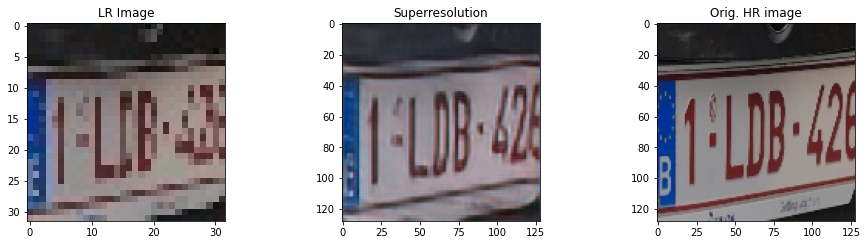

In [35]:
# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()